<a href="https://colab.research.google.com/github/zpsy-hub/Data-Mining-Principles/blob/main/%5BFINAL%5D_Clustering_k%3D3_w_out_Avg_Satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples
from scipy.spatial import ConvexHull
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

!pip install kneed

# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# **Load and Explore Data**

In [2]:
# Load datasets
df_transaction = pd.read_csv('/content/drive/MyDrive/3rd year 2024-25/Term 2/Data Mining Principles/cleaned data/Transaction_Data_cleaned.csv')
df_customer_feedback = pd.read_csv('/content/drive/MyDrive/3rd year 2024-25/Term 2/Data Mining Principles/cleaned data/Customer_Feedback_Data_cleaned.csv')
df_product_offering = pd.read_csv('/content/drive/MyDrive/3rd year 2024-25/Term 2/Data Mining Principles/cleaned data/Product_Offering_Data_cleaned.csv')

# Check data shapes
print("Transaction data shape:", df_transaction.shape)
print("Feedback data shape:", df_customer_feedback.shape)
print("Product data shape:", df_product_offering.shape)

Transaction data shape: (5000, 9)
Feedback data shape: (4959, 4)
Product data shape: (10, 7)


# **Feature Engineering**

1. **Transaction Volume Features**
   - **Total_Transaction_Amount**: Sum of all customer spending
   - **Transaction_Count**: Number of transactions per customer
   - **Avg_Transaction_Amount**: Average spending per transaction

2. **Transaction Composition Features**
   - **Transaction Type %**: Proportion of each transaction type per customer
   - **Amount Categories %**: Distribution across amount categories (Low to Very High)

3. **Engagement Features**
   - **Days_Since_Last_Transaction**: Recency indicator
   - **Engagement_Score**: Combined transaction and feedback engagement
   - **Customer_Value**: Weighted metric of transaction value and frequency

4. **RFM Features**
   - **R/F/M_Quartile**: Customer quartile scores (1-4) for recency, frequency and monetary value
   - **RFM_Score**: Combined RFM metric

5. **Satisfaction Metric**
   - **Avg_Recommendation**: Average likelihood to recommend score

These features were created to capture spending patterns, engagement levels, customer value, and satisfaction metrics to identify distinct customer segments for targeted financial product recommendations.

In [3]:
# Get unique customers
unique_customers = df_transaction['Customer_ID'].unique()
customer_features = pd.DataFrame({'Customer_ID': unique_customers})

# Transaction amount metrics
transaction_amount = df_transaction.groupby('Customer_ID')['Transaction_Amount'].agg(
    ['sum', 'count', 'mean', 'min', 'max']).reset_index()
transaction_amount.columns = ['Customer_ID', 'Total_Transaction_Amount',
                             'Transaction_Count', 'Avg_Transaction_Amount',
                             'Min_Transaction_Amount', 'Max_Transaction_Amount']

# Transaction types
transaction_types = pd.crosstab(
    df_transaction['Customer_ID'],
    df_transaction['Transaction_Type'],
    normalize='index'
).reset_index()

# Transaction amount categories
transaction_categories = pd.crosstab(
    df_transaction['Customer_ID'],
    df_transaction['Transaction_Amount_Category'],
    normalize='index'
).reset_index()

# Feedback metrics (REMOVE Avg_Satisfaction)
feedback_metrics = df_customer_feedback.groupby('Customer_ID').agg(
    Feedback_Count=('Satisfaction_Score', 'count'),
    Avg_Recommendation=('Likelihood_to_Recommend', 'mean')
).reset_index()  # Removed 'Avg_Satisfaction'

# Merge all features
customer_features = customer_features.merge(transaction_amount, on='Customer_ID', how='left')
customer_features = customer_features.merge(transaction_types, on='Customer_ID', how='left')
customer_features = customer_features.merge(transaction_categories, on='Customer_ID', how='left')
customer_features = customer_features.merge(feedback_metrics, on='Customer_ID', how='left')

# Add recency feature
last_transaction_date = df_transaction.groupby('Customer_ID')['Transaction_Date'].max().reset_index()
last_transaction_date.columns = ['Customer_ID', 'Last_Transaction_Date']
max_date = pd.Timestamp('2023-07-31')

# Ensure Last_Transaction_Date is datetime type
last_transaction_date['Last_Transaction_Date'] = pd.to_datetime(last_transaction_date['Last_Transaction_Date'])
last_transaction_date['Days_Since_Last_Transaction'] = (
    max_date - last_transaction_date['Last_Transaction_Date']
).dt.days
customer_features = customer_features.merge(
    last_transaction_date[['Customer_ID', 'Days_Since_Last_Transaction']],
    on='Customer_ID', how='left'
)

# Is repeat customer?
customer_features['Is_Repeat_Customer'] = customer_features['Transaction_Count'] > 1

# Fill NaNs
customer_features = customer_features.fillna(0)

# Create engagement score
customer_features['Engagement_Score'] = (
    (customer_features['Transaction_Count'] / customer_features['Transaction_Count'].max()) * 0.7 +
    (customer_features['Feedback_Count'] / customer_features['Feedback_Count'].max()) * 0.3
) * 10

# Create customer value score
customer_features['Customer_Value'] = (
    (customer_features['Total_Transaction_Amount'] / customer_features['Total_Transaction_Amount'].max()) * 0.8 +
    (customer_features['Transaction_Count'] / customer_features['Transaction_Count'].max()) * 0.2
) * 10

# Print with new features (without Avg_Satisfaction)
customer_features.head(5)


Customer_ID  Total_Transaction_Amount  Transaction_Count  \
0          393              22365.000000                  7   
1          826               8182.422663                  3   
2          916              18406.000000                  9   
3          109               7492.000000                  5   
4          889               6348.834015                  3   

   Avg_Transaction_Amount  Min_Transaction_Amount  Max_Transaction_Amount  \
0             3195.000000                  1535.0             4968.000000   
1             2727.474221                   323.0             4123.000000   
2             2045.111111                    10.0             4616.000000   
3             1498.400000                    72.0             4549.000000   
4             2116.278005                  1531.0             3024.834015   

   Bill Payment  Investment  Loan Payment  Purchase      High       Low  \
0      0.428571    0.428571      0.000000  0.142857  0.428571  0.000000   
1      0.333333    0.000000      0.333333  0.333333  0.000000  0.333333   
2      0.333333    0.111111      0.333333  0.222222  0.111111  0.444444   
3      0.200000    0.400000      0.200000  0.200000  0.200000  0.600000   
4      0.000000    1.000000      0.000000  0.000000  0.333333  0.000000   

     Medium  Very High  Feedback_Count  Avg_Recommendation  \
0  0.285714   0.285714               1                 3.0   
1  0.000000   0.666667               6                 5.5   
2  0.222222   0.222222               7                 5.0   
3  0.000000   0.200000               3                 7.0   
4  0.666667   0.000000               5                 5.6   

   Days_Since_Last_Transaction  Is_Repeat_Customer  Engagement_Score  \
0                            7                True          4.000000   
1                           15                True          3.000000   
2                           34                True          6.461538   
3                           77                True          3.384615   
4                          108                True          2.769231   

   Customer_Value  
0        1.442427  
1        0.595261  
2        1.685419  
3        0.891670  
4        0.565295

# **RFM**

RFM (Recency, Frequency, Monetary) analysis is an industry-standard customer segmentation technique that identifies customer value based on three key metrics:

- **Recency**: How recently a customer made a transaction
- **Frequency**: How often a customer makes transactions
- **Monetary**: How much a customer spends

For FinMark, RFM analysis is crucial because it:

1. Identifies high-value customers (high RFM score) who may benefit from premium offerings
2. Highlights at-risk customers (high M, but low R) who need retention efforts
3. Reveals potential for cross-selling to consistent customers (high F)
4. Enables targeted marketing based on behavioral patterns

For example, a customer with an RFM score of 12 (R=4, F=4, M=4) represents the most valuable segment who recently transacted, does so frequently, and spends significantly—making them ideal candidates for premium financial products.

In [4]:
# Calculate RFM (Recency, Frequency, Monetary) metrics
rfm = customer_features[['Customer_ID', 'Days_Since_Last_Transaction',
                        'Transaction_Count', 'Total_Transaction_Amount']].copy()
rfm.columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary']

# Convert recency to a score where lower is better
rfm['Recency'] = rfm['Recency'].max() - rfm['Recency']

# Create quartiles
rfm['R_Quartile'] = pd.qcut(rfm['Recency'], 4, labels=[1, 2, 3, 4], duplicates='drop')
rfm['F_Quartile'] = pd.qcut(rfm['Frequency'], 4, labels=[1, 2, 3, 4], duplicates='drop')
rfm['M_Quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop')

# Convert to integers
rfm['R_Quartile'] = rfm['R_Quartile'].astype(int)
rfm['F_Quartile'] = rfm['F_Quartile'].astype(int)
rfm['M_Quartile'] = rfm['M_Quartile'].astype(int)

# RFM Score
rfm['RFM_Score'] = rfm['R_Quartile'] + rfm['F_Quartile'] + rfm['M_Quartile']

# Merge RFM metrics back to customer features
customer_features = customer_features.merge(
    rfm[['Customer_ID', 'R_Quartile', 'F_Quartile', 'M_Quartile', 'RFM_Score']],
    on='Customer_ID', how='left'
)

# Print with new features
customer_features.head(5)

Customer_ID  Total_Transaction_Amount  Transaction_Count  \
0          393              22365.000000                  7   
1          826               8182.422663                  3   
2          916              18406.000000                  9   
3          109               7492.000000                  5   
4          889               6348.834015                  3   

   Avg_Transaction_Amount  Min_Transaction_Amount  Max_Transaction_Amount  \
0             3195.000000                  1535.0             4968.000000   
1             2727.474221                   323.0             4123.000000   
2             2045.111111                    10.0             4616.000000   
3             1498.400000                    72.0             4549.000000   
4             2116.278005                  1531.0             3024.834015   

   Bill Payment  Investment  Loan Payment  Purchase  ...  Feedback_Count  \
0      0.428571    0.428571      0.000000  0.142857  ...               1   
1      0.333333    0.000000      0.333333  0.333333  ...               6   
2      0.333333    0.111111      0.333333  0.222222  ...               7   
3      0.200000    0.400000      0.200000  0.200000  ...               3   
4      0.000000    1.000000      0.000000  0.000000  ...               5   

   Avg_Recommendation  Days_Since_Last_Transaction  Is_Repeat_Customer  \
0                 3.0                            7                True   
1                 5.5                           15                True   
2                 5.0                           34                True   
3                 7.0                           77                True   
4                 5.6                          108                True   

   Engagement_Score  Customer_Value  R_Quartile  F_Quartile  M_Quartile  \
0          4.000000        1.442427           4           4           4   
1          3.000000        0.595261           3           1           2   
2          6.461538        1.685419           2           4           4   
3          3.384615        0.891670           1           2           1   
4          2.769231        0.565295           1           1           1   

   RFM_Score  
0         12  
1          6  
2         10  
3          4  
4          3  

[5 rows x 24 columns]

# **Prepare Data and Scaling for Clustering**

This code selects relevant customer features for clustering (transaction metrics, engagement indicators, and RFM values) and standardizes them with StandardScaler to ensure each feature contributes equally during K-means clustering. Standardization is critical because K-means uses distance calculations that would otherwise be dominated by features with larger numerical ranges.

In [5]:
# Select features for clustering
clustering_features = [
    'Total_Transaction_Amount', 'Transaction_Count', 'Avg_Transaction_Amount',
    'Bill Payment', 'Investment', 'Loan Payment', 'Purchase',  # Transaction type percentages
    'Low', 'Medium', 'High', 'Very High',  # Transaction amount categories
    'Avg_Satisfaction', #'Avg_Recommendation',removed due to ANOVA
    'Days_Since_Last_Transaction', 'Engagement_Score', 'Customer_Value',
    'R_Quartile', 'F_Quartile', 'M_Quartile'
]

# Make sure all features exist in the dataframe
clustering_features = [f for f in clustering_features if f in customer_features.columns]
print(f"Using {len(clustering_features)} features for clustering: {clustering_features}")

# Create a subset for clustering
cluster_data = customer_features[clustering_features].copy()

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

Using 17 features for clustering: ['Total_Transaction_Amount', 'Transaction_Count', 'Avg_Transaction_Amount', 'Bill Payment', 'Investment', 'Loan Payment', 'Purchase', 'Low', 'Medium', 'High', 'Very High', 'Days_Since_Last_Transaction', 'Engagement_Score', 'Customer_Value', 'R_Quartile', 'F_Quartile', 'M_Quartile']


# **Finding the Optimal Number of Customer Segments Using the Elbow Method**
This code finds the optimal number of clusters for K-means by plotting the "inertia" (within-cluster variance) for different cluster counts. The "elbow point" where the line bends (marked with a red line at k=3) indicates the best balance between too few and too many clusters for the customer segmentation.

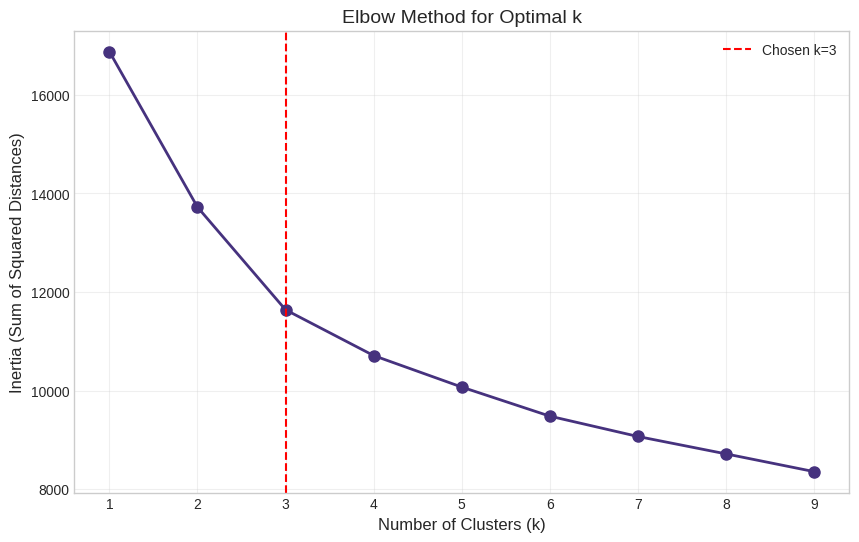

In [6]:
# Elbow Method to find optimal k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate inertia (sum of squared distances to closest centroid) for different k values
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-', linewidth=2, markersize=8)
plt.grid(True, alpha=0.3)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xticks(k_range)

# Add a vertical line at k=3 to indicate chosen value
plt.axvline(x=3, linestyle='--', color='red', label='Chosen k=3')
plt.legend()
plt.show()



# **Evaluating Cluster Quality with Silhouette Analysis**

This code calculates and plots silhouette scores for different numbers of clusters (k) to evaluate clustering quality. The silhouette score measures how similar objects are to their own cluster compared to other clusters, with higher scores indicating better-defined clusters. The plot shows that k=3 (marked by the red line) provides the optimal balance of cluster separation and cohesion for the customer segmentation model.

For k=2: Silhouette Score = 0.184
For k=3: Silhouette Score = 0.188
For k=4: Silhouette Score = 0.137
For k=5: Silhouette Score = 0.121
For k=6: Silhouette Score = 0.123
For k=7: Silhouette Score = 0.118
For k=8: Silhouette Score = 0.122
For k=9: Silhouette Score = 0.120


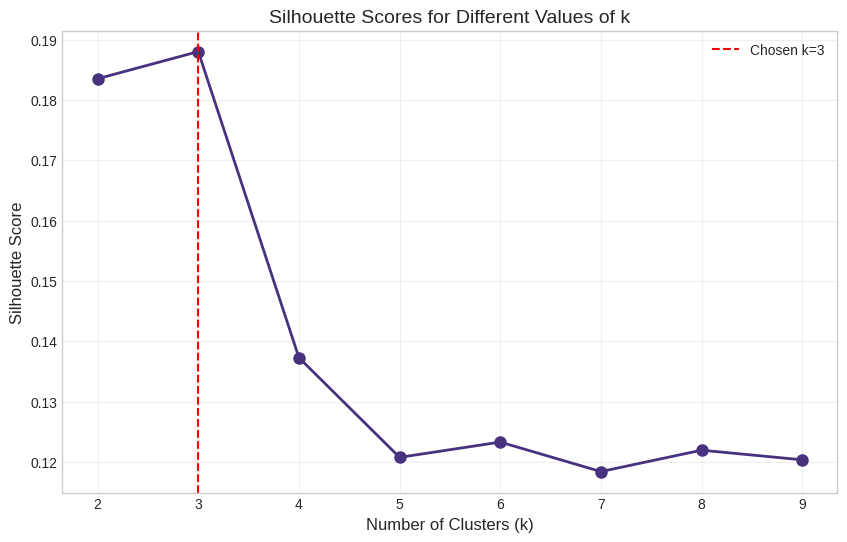

In [7]:
# Silhouette Scores for different k values
silhouette_scores = []

for k in range(2, 10):  # Silhouette score not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k={k}: Silhouette Score = {silhouette_avg:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, 'o-', linewidth=2, markersize=8)
plt.grid(True, alpha=0.3)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Scores for Different Values of k', fontsize=14)
plt.xticks(range(2, 10))

# Add a vertical line at k=3 to indicate chosen value
plt.axvline(x=3, linestyle='--', color='red', label='Chosen k=3')
plt.legend()
plt.show()


The silhouette score measures how well customers fit within their assigned clusters. A score ranges from -1 to 1, where:

- Higher scores (closer to 1): Customers are very similar to others in their group and different from those in other groups.
- Scores near 0: Customers are on the border between clusters.
- Negative scores: Customers might be in the wrong cluster.

Looking at the results:
- The best score was 0.188 for 3 clusters, which is positive but not very high
- This means there are some natural groupings, but with overlap between customer segments
- When trying more clusters (4+), the scores drop significantly (below 0.14), showing that forcing more divisions makes the groupings less meaningful

The results suggest that dividing FinMark's customers into 3 segments provides the most natural grouping, though the moderate score indicates these customer groups have some similarities across boundaries.



---



## **PCA Visualization of Clustering Solutions**

This code creates visual representations of how customers group together when divided into 2, 3, or 4 clusters.

The process:
1. Uses PCA to reduce all customer attributes to two dimensions for easier visualization
2. Applies K-means clustering with different k values (2, 3, and 4)
3. Creates three side-by-side plots showing how customers are grouped in each scenario
4. Marks cluster centers with red X symbols
5. Displays the silhouette score for each clustering solution

These visualizations help compare how customer segments look with different numbers of clusters and support the decision to use k=3 as the optimal solution.


### PCA Visualization for Different Cluster Counts


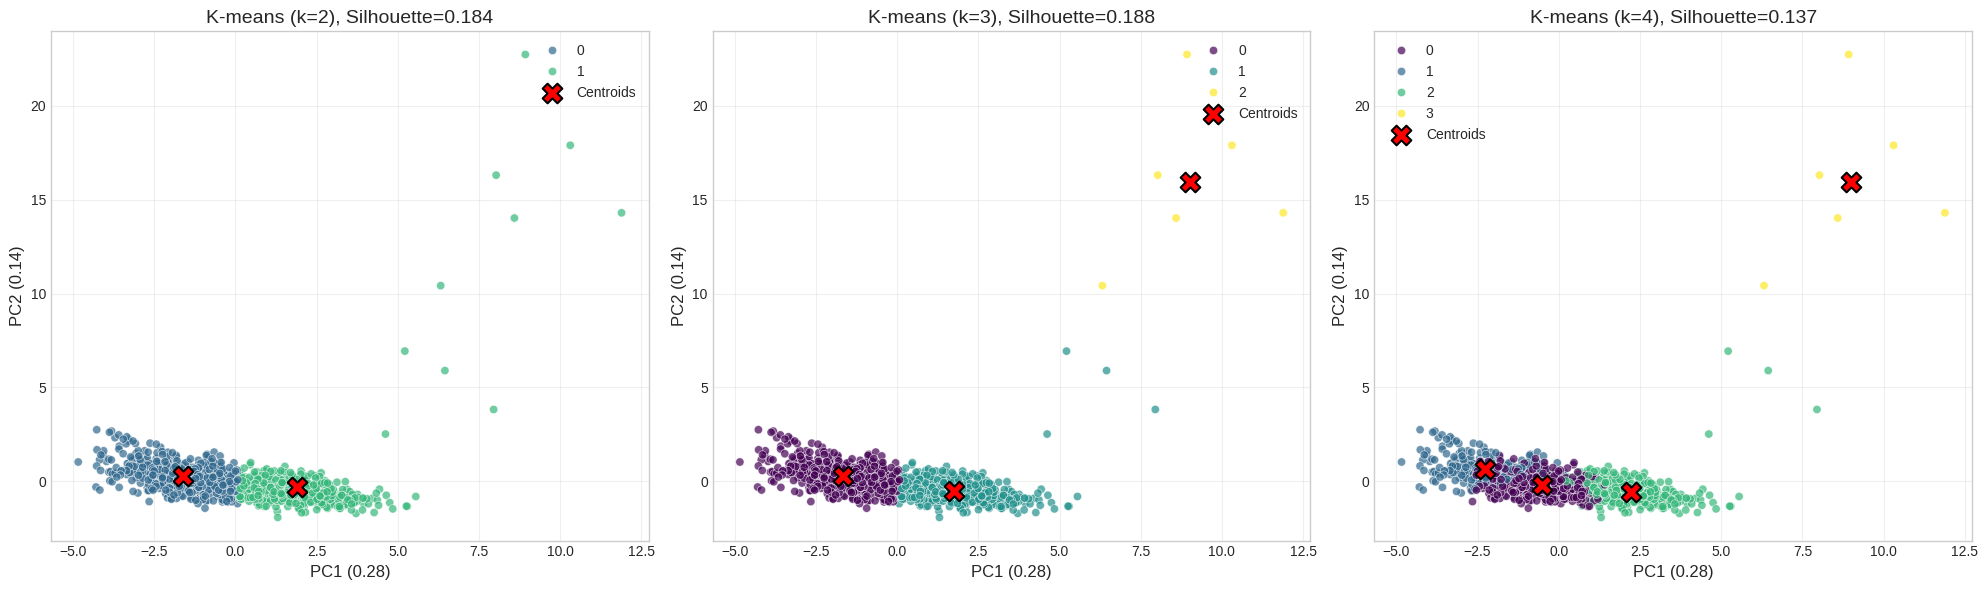

In [8]:

# Visualize clustering results for k=2, k=3, and k=4 using PCA
print("\n### PCA Visualization for Different Cluster Counts")

# Apply PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Create a figure with 3 subplots (one for each k value)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
k_values_to_visualize = [2, 3, 4]

for i, k in enumerate(k_values_to_visualize):
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)

    # Add cluster labels to PCA dataframe
    pca_df_k = pca_df.copy()
    pca_df_k['Cluster'] = cluster_labels

    # Plot on the corresponding subplot
    ax = axes[i]
    sns.scatterplot(
        x='PC1', y='PC2',
        hue='Cluster',
        data=pca_df_k,
        palette='viridis',
        alpha=0.7,
        ax=ax
    )

    # Set subplot title and labels
    ax.set_title(f'K-means (k={k}), Silhouette={silhouette_avg:.3f}', fontsize=14)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})', fontsize=12)
    ax.grid(True, alpha=0.3)

    # Highlight centroid positions
    centroids = kmeans.cluster_centers_
    centroids_pca = pca.transform(centroids)
    ax.scatter(
        centroids_pca[:, 0], centroids_pca[:, 1],
        s=200, marker='X', c='red',
        edgecolor='black', linewidth=1.5,
        label='Centroids'
    )
    ax.legend()

plt.tight_layout()
plt.show()

These visualizations support the findings from the silhouette scores and elbow method:

- **K=2 (left)**: Shows a basic division of customers into two groups. While the silhouette score is decent (0.184), it likely oversimplifies customer segments.

- **K=3 (middle)**: Shows three distinct clusters with the highest silhouette score (0.188). The clusters appear reasonably well-separated, especially the purple and teal groups. The yellow dots represent outlier customers with unique behaviors.

- **K=4 (right)**: The silhouette score drops significantly (0.137) as we see the main clusters being divided in ways that don't appear natural. The additional boundary creates more overlap between clusters.

These visualizations confirm that three clusters provide the optimal balance between separating distinct customer groups while avoiding artificial divisions. This aligns with both the elbow method and silhouette score results, which identified k=3 as the best choice for customer segmentation.



---



## **K-means Clustering Implementation with 3 Clusters**

This code performs the actual customer segmentation using k=3 clusters and analyzes the results:

1. Applies K-means clustering algorithm to the customer data
2. Assigns each customer to one of three clusters
3. Calculates the silhouette score to measure clustering quality
4. Creates a summary table showing the key characteristics of each cluster:
   - Average transaction amounts
   - Transaction frequency
   - Customer recommendation scores
   - Customer value metrics
   - Number of customers in each segment

In [9]:
# Apply K-means with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_features['Cluster'] = kmeans.fit_predict(scaled_data)

# Calculate silhouette score
silhouette_avg = silhouette_score(scaled_data, customer_features['Cluster'])
print(f"Silhouette Score with {k} clusters: {silhouette_avg:.3f}")

# Create a summary of cluster statistics
cluster_stats = customer_features.groupby('Cluster').agg({
    'Total_Transaction_Amount': 'mean',
    'Transaction_Count': 'mean',
    'Avg_Transaction_Amount': 'mean',
    #'Avg_Satisfaction': 'mean', removed due to ANOVA
    'Avg_Recommendation': 'mean',
    'Customer_Value': 'mean',
    'RFM_Score': 'mean',
    'Customer_ID': 'count'
}).reset_index()
cluster_stats.rename(columns={'Customer_ID': 'Customer_Count'}, inplace=True)

print("\nCluster Statistics:")
display(cluster_stats.round(2))

Silhouette Score with 3 clusters: 0.188

Cluster Statistics:


Cluster  Total_Transaction_Amount  Transaction_Count  \
0        0                   8080.90               3.41   
1        1                  19006.54               6.85   
2        2                 409980.97               5.50   

   Avg_Transaction_Amount  Avg_Recommendation  Customer_Value  RFM_Score  \
0                 2415.51                5.64            0.66       5.23   
1                 2776.54                5.46            1.36       9.73   
2                81766.13                6.70            7.55       8.83   

   Customer_Count  
0             522  
1             465  
2               6

The K-means clustering has identified three distinct customer segments:

**Cluster 0 (522 customers):**
- Lowest average total spending ($8,080.90)
- Lowest transaction frequency (3.41 transactions)
- Lowest customer value score (0.66)
- Moderate recommendation score (5.64)
- These appear to be infrequent, low-value customers

**Cluster 1 (465 customers):**
- Moderate total spending ($19,006.54)

- Highest transaction frequency (6.85 transactions)
- Moderate average transaction amount ($2,776.54)
- Highest RFM score (9.73), indicating good recency, frequency, and monetary value
- These are active, engaged customers with regular transactions

**Cluster 2 (6 customers):**
- Extremely high total spending ($409,980.97)

- Very high average transaction amount ($81,766.13)
- Highest recommendation score (6.70)
- High customer value score (7.55)
- These are high-value VIP customers who make large transactions

This segmentation creates a natural division of FinMark's customer base into low-engagement customers, regular active customers, and high-value VIPs, providing a clear foundation for targeted financial product development.



---



Variance explained by each principal component:
PC1: 0.2784 (0.2784 cumulative)
PC2: 0.1354 (0.4139 cumulative)
PC3: 0.0919 (0.5058 cumulative)
PC4: 0.0852 (0.5910 cumulative)
PC5: 0.0846 (0.6756 cumulative)
PC6: 0.0807 (0.7563 cumulative)
PC7: 0.0741 (0.8304 cumulative)
PC8: 0.0719 (0.9023 cumulative)
PC9: 0.0663 (0.9686 cumulative)
PC10: 0.0092 (0.9779 cumulative)

Top features by principal component:

PC1 top features:
  Transaction_Count: 0.4134
  M_Quartile: 0.3971
  F_Quartile: 0.3970
  Engagement_Score: 0.3946
  Customer_Value: 0.3853

PC2 top features:
  Avg_Transaction_Amount: 0.5768
  Total_Transaction_Amount: 0.5293
  Customer_Value: 0.3222
  Days_Since_Last_Transaction: 0.2283
  R_Quartile: -0.2244

PC3 top features:
  Very High: 0.6059
  Low: -0.4234
  Medium: -0.3501
  Bill Payment: 0.2765
  M_Quartile: 0.2425


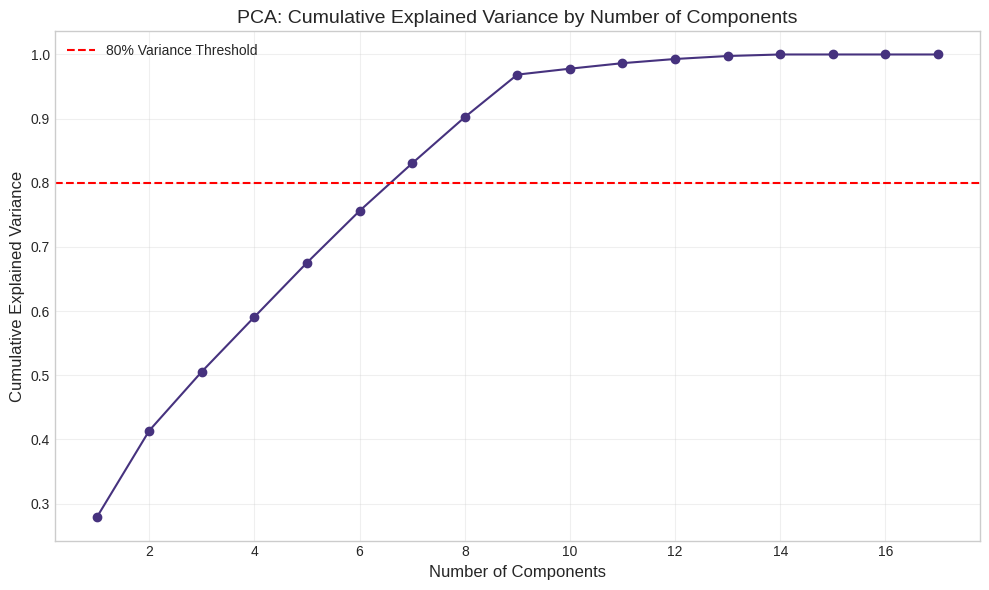

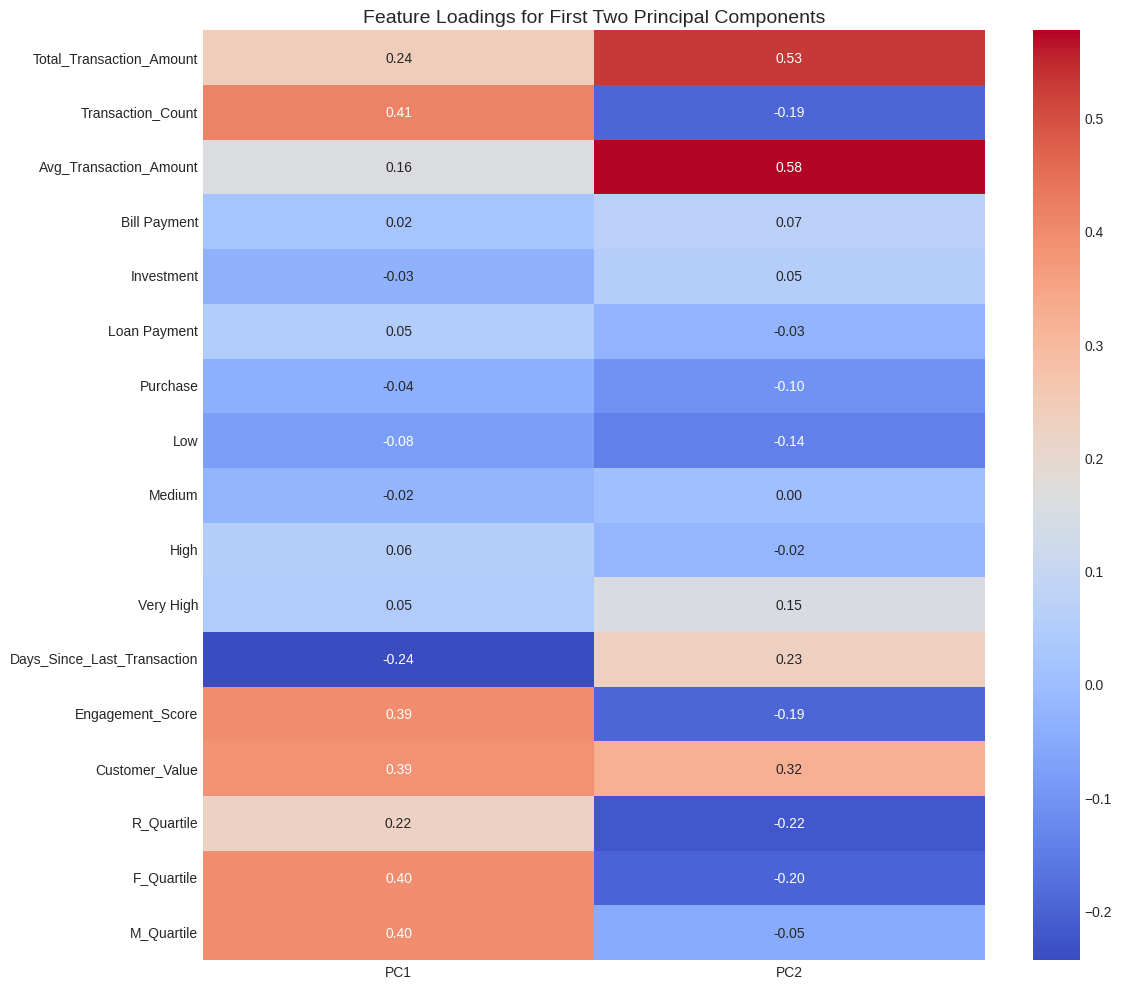

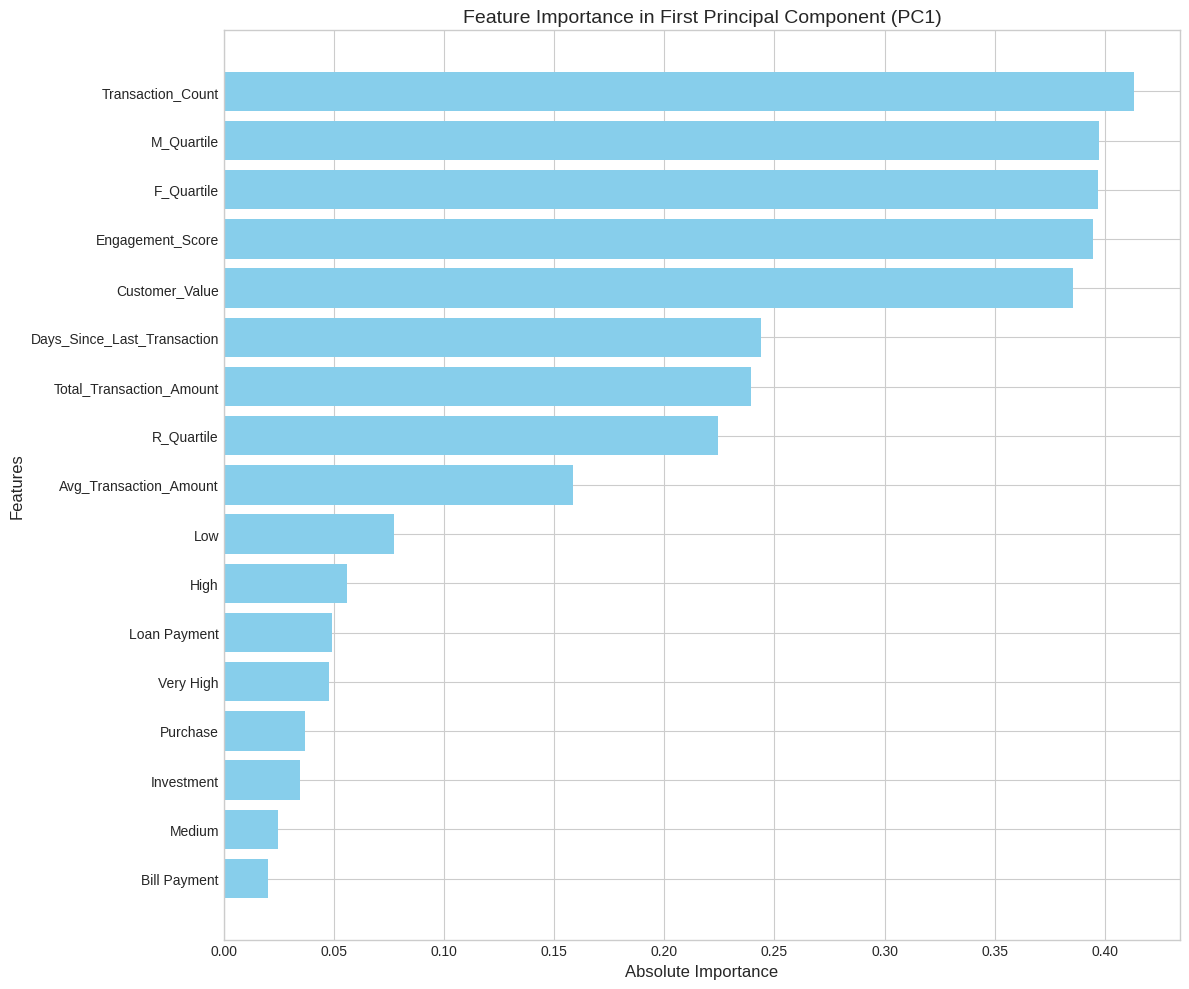

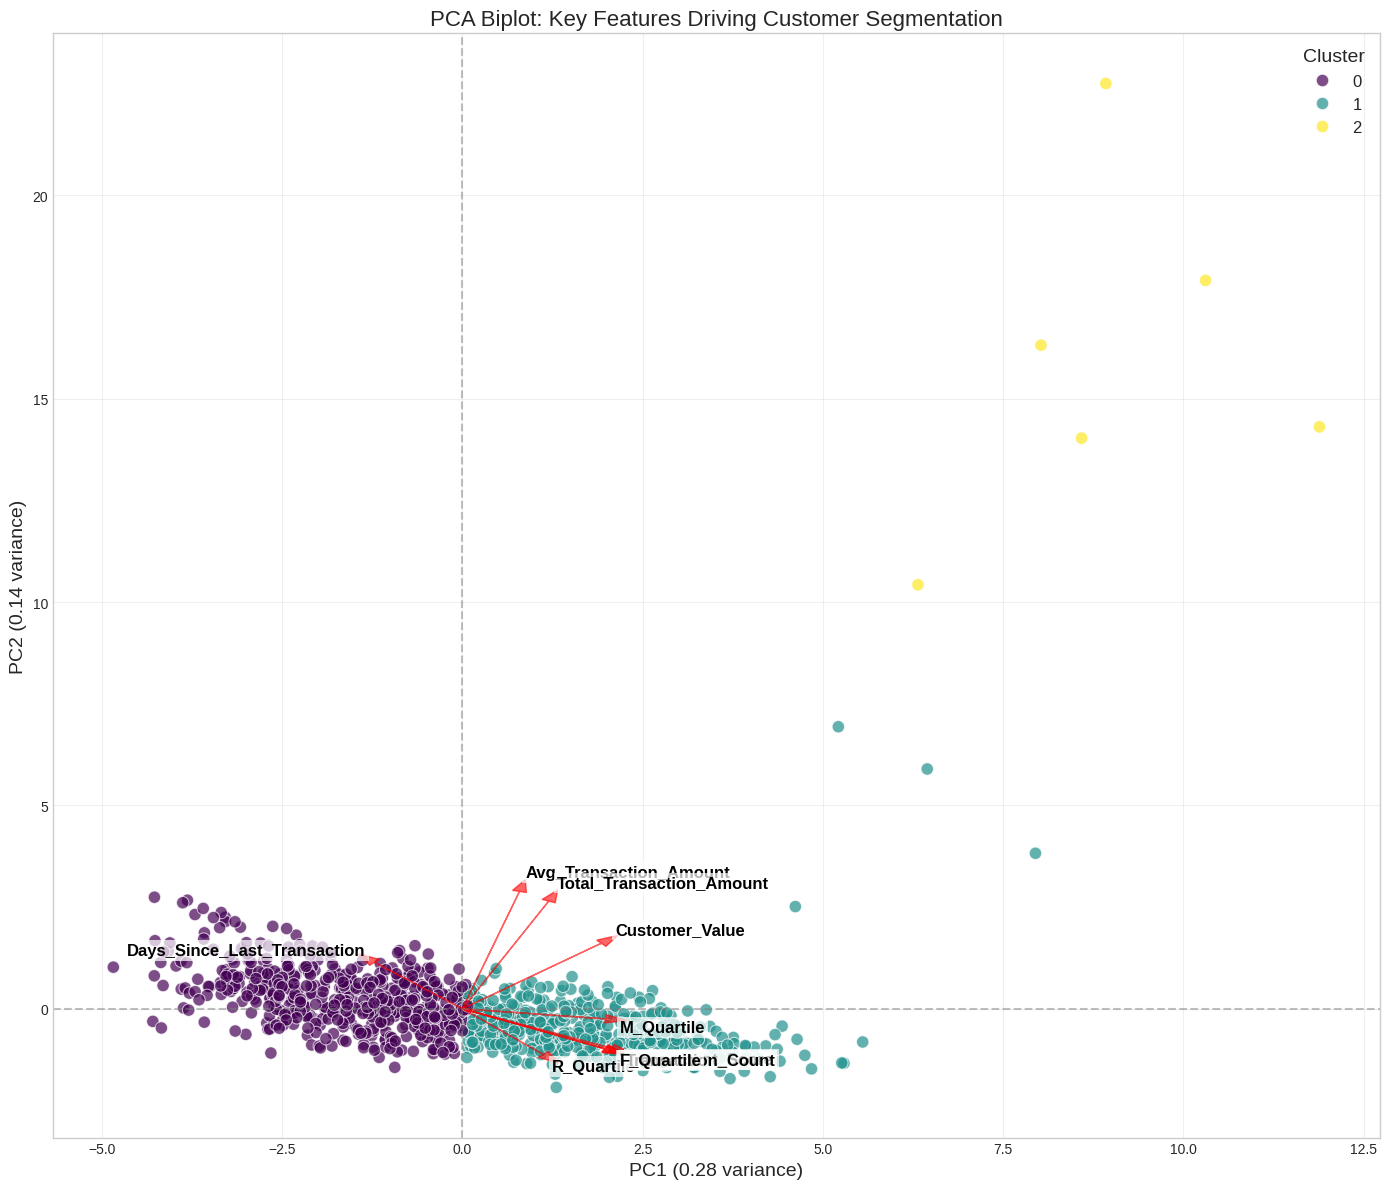


Feature importance by cluster:

Cluster 0 key characteristics:
  Total_Transaction_Amount: -48.3% lower than average
  Transaction_Count: -32.2% lower than average
  Avg_Transaction_Amount: -21.2% lower than average
  Days_Since_Last_Transaction: 33.6% higher than average
  Engagement_Score: -23.0% lower than average
  Customer_Value: -36.2% lower than average
  F_Quartile: -36.3% lower than average
  M_Quartile: -33.5% lower than average

Cluster 1 key characteristics:
  Total_Transaction_Amount: 21.6% higher than average
  Transaction_Count: 36.1% higher than average
  Days_Since_Last_Transaction: -37.5% lower than average
  Engagement_Score: 25.7% higher than average
  Customer_Value: 32.5% higher than average
  F_Quartile: 40.8% higher than average
  M_Quartile: 36.9% higher than average

Cluster 2 key characteristics:
  Total_Transaction_Amount: 2523.8% higher than average
  Avg_Transaction_Amount: 2568.6% higher than average
  Investment: 39.5% higher than average
  Purchase: -7

In [10]:
# ----- PCA Variance Analysis for Customer Segments -----
# Add this code after your K-means clustering section

# Select features used for clustering
clustering_features = [
    'Total_Transaction_Amount', 'Transaction_Count', 'Avg_Transaction_Amount',
    'Bill Payment', 'Investment', 'Loan Payment', 'Purchase',
    'Low', 'Medium', 'High', 'Very High',
    'Days_Since_Last_Transaction', 'Engagement_Score', 'Customer_Value',
    'R_Quartile', 'F_Quartile', 'M_Quartile'
]

# Make sure all features exist in the dataframe
clustering_features = [f for f in clustering_features if f in customer_features.columns]

# Create a subset for PCA
pca_data = customer_features[clustering_features].copy()

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_data)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print variance explained by components
print("Variance explained by each principal component:")
for i, var in enumerate(explained_variance[:10]):  # Show top 10 components
    print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulative)")

# Create feature importance DataFrame for each component
component_loadings = pd.DataFrame(
    pca.components_.T[:, :3],  # First 3 components
    columns=['PC1', 'PC2', 'PC3'],
    index=clustering_features
)

# For each component, print the top features (by absolute value)
print("\nTop features by principal component:")
for pc in ['PC1', 'PC2', 'PC3']:
    sorted_features = component_loadings[pc].abs().sort_values(ascending=False).head(5)
    print(f"\n{pc} top features:")
    for feature in sorted_features.index:
        # Get the actual value (not absolute)
        actual_value = component_loadings.loc[feature, pc]
        print(f"  {feature}: {actual_value:.4f}")

# Visualize cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('PCA: Cumulative Explained Variance by Number of Components', fontsize=14)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance Threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot feature importance heatmap for first two components
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    component_loadings.iloc[:, :2],  # First two components
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    cbar=True
)
plt.title('Feature Loadings for First Two Principal Components', fontsize=14)
plt.tight_layout()
plt.show()

# Create a feature importance visualization (horizontal bar chart for PC1)
plt.figure(figsize=(12, 10))
pc1_loadings = pd.Series(
    np.abs(pca.components_[0]),
    index=clustering_features
).sort_values(ascending=True)
plt.barh(pc1_loadings.index, pc1_loadings.values, color='skyblue')
plt.xlabel('Absolute Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance in First Principal Component (PC1)', fontsize=14)
plt.tight_layout()
plt.show()

# Create biplot with clusters and feature vectors
# Add the first two principal components and cluster labels to a DataFrame
pca_clusters = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'Cluster': customer_features['Cluster']
})

# Create the biplot
plt.figure(figsize=(14, 12))

# Plot the scatter points colored by cluster
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    data=pca_clusters,
    palette='viridis',
    alpha=0.7,
    s=80
)

# Scale the feature vectors for visibility
scaling = 5
feature_vectors = pca.components_.T[:, :2] * scaling

# Select top features for clearer visualization
top_features_pc1 = component_loadings['PC1'].abs().sort_values(ascending=False).head(8).index
top_features_pc2 = component_loadings['PC2'].abs().sort_values(ascending=False).head(8).index
important_features = list(set(top_features_pc1) | set(top_features_pc2))

# Plot feature vectors for important features
for feature in important_features:
    i = clustering_features.index(feature)
    plt.arrow(
        0, 0,  # Start at origin
        feature_vectors[i, 0],
        feature_vectors[i, 1],
        color='red',
        alpha=0.6,
        head_width=0.2
    )

    # Position the text to avoid overlap
    x_pos = feature_vectors[i, 0] * 1.1
    y_pos = feature_vectors[i, 1] * 1.1

    # Adjust text alignment based on which quadrant the vector points to
    ha = 'left' if x_pos > 0 else 'right'
    va = 'bottom' if y_pos > 0 else 'top'

    plt.text(
        x_pos, y_pos,
        feature,
        color='black',
        fontsize=12,
        fontweight='bold',
        ha=ha, va=va,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2)
    )

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.title('PCA Biplot: Key Features Driving Customer Segmentation', fontsize=16)
plt.xlabel(f'PC1 ({explained_variance[0]:.2f} variance)', fontsize=14)
plt.ylabel(f'PC2 ({explained_variance[1]:.2f} variance)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

# Calculate and print feature importance for each cluster
print("\nFeature importance by cluster:")
for cluster_id in sorted(customer_features['Cluster'].unique()):
    cluster_data = customer_features[customer_features['Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} key characteristics:")

    # For each feature, calculate mean and compare to overall mean
    for feature in clustering_features:
        cluster_mean = cluster_data[feature].mean()
        overall_mean = customer_features[feature].mean()
        diff_pct = ((cluster_mean - overall_mean) / overall_mean) * 100

        # Only show features that differ significantly from the overall mean
        if abs(diff_pct) > 20:  # 20% threshold for significance
            direction = "higher" if diff_pct > 0 else "lower"
            print(f"  {feature}: {diff_pct:.1f}% {direction} than average")

## **More Visualization of the Clusters**

Three different visualization techniques were done to help better understand the customer clustering:

1. **Convex Hull Plot**: Draws boundaries around each cluster, highlighting the separation between customer groups.

2. **Contour/Density Plot**: Shows concentration levels within clusters, revealing where most customers are grouped.

3. **Interactive Plotly Visualization**: Allows exploration of specific data points, making it easier to see PC1 and PC2 values for individual customers.

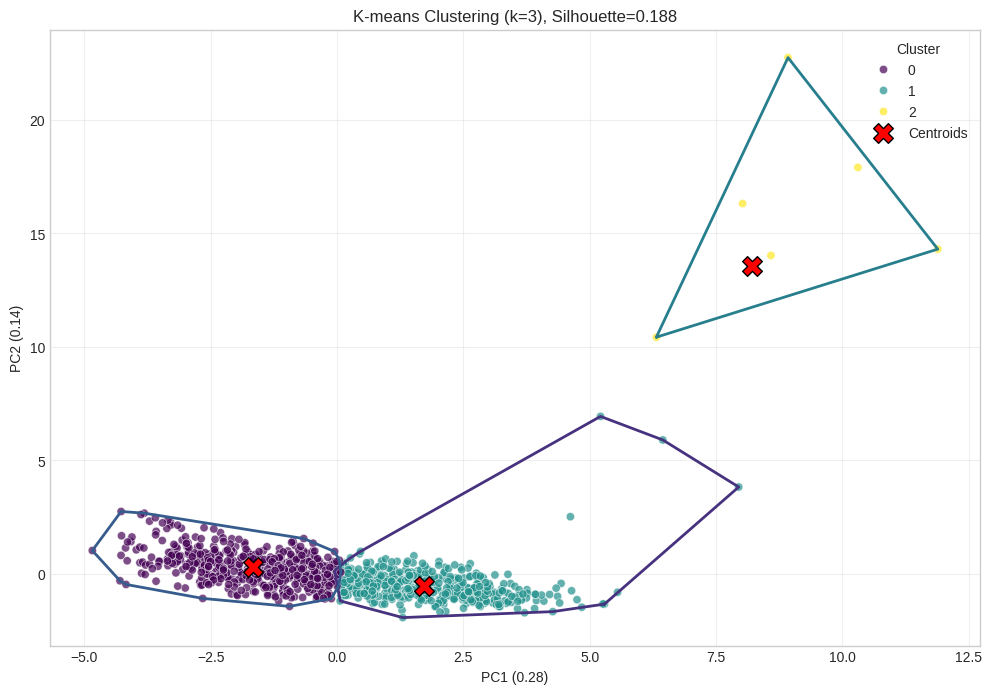

In [11]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = customer_features['Cluster']

# Perform K-means to get centroids
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(principal_components)  # Using PCA components for centroids
centroids = kmeans.cluster_centers_

# Define a consistent marker style (same shape for all clusters)
marker = 'o'  # Circle for all clusters

# Plot Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7, marker=marker)

# Draw Convex Hulls for Clusters
for cluster in pca_df['Cluster'].unique():
    cluster_points = pca_df[pca_df['Cluster'] == cluster][['PC1', 'PC2']].values
    if len(cluster_points) > 2:  # ConvexHull requires at least 3 points
        hull = ConvexHull(cluster_points)
        hull_vertices = np.append(hull.vertices, hull.vertices[0])  # Close the hull
        plt.plot(cluster_points[hull_vertices, 0], cluster_points[hull_vertices, 1], linestyle='-', linewidth=2)

# Plot the Centroids with consistent shape
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', edgecolors='black', label='Centroids')

# Titles and Labels
plt.title(f'K-means Clustering (k={k}), Silhouette={silhouette_avg:.3f}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.show()



**Convex Hull:**
The plot clearly shows three distinct customer segments - two large clusters (purple and teal) along the bottom representing most customers, and a small but distinct yellow cluster of outliers with high PC2 values. Red X markers show each cluster's center.

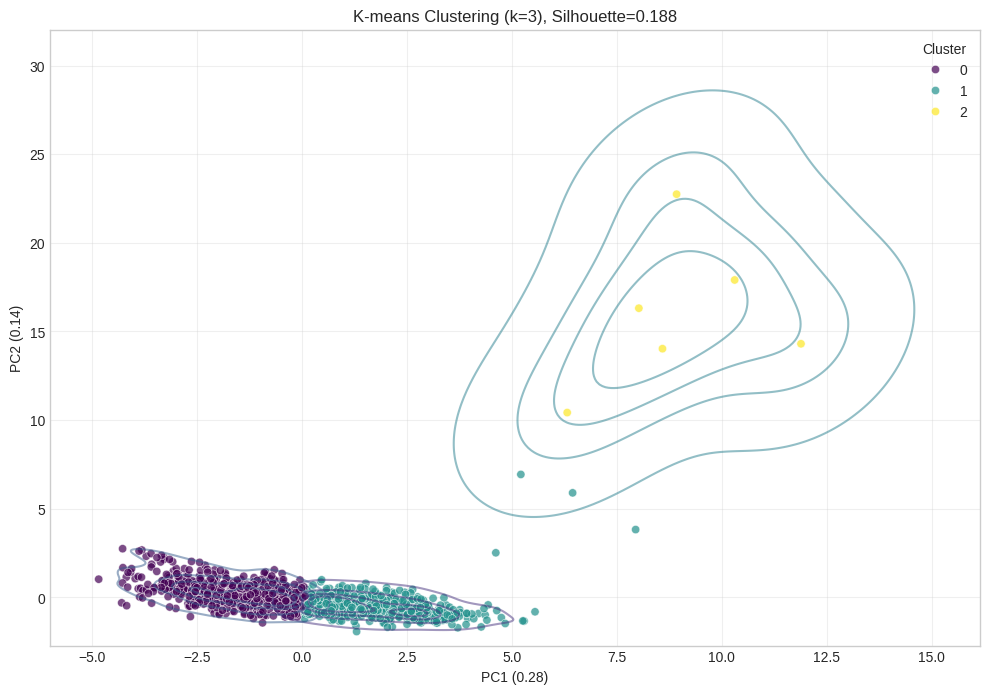

In [12]:
# Plot Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7)

# Draw Density Contour Plots
for cluster in pca_df['Cluster'].unique():
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    sns.kdeplot(x=cluster_data['PC1'], y=cluster_data['PC2'], levels=5, alpha=0.5)

# Titles and Labels
plt.title(f'K-means Clustering (k={k}), Silhouette={silhouette_avg:.3f}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.show()

**Density Plot:**
Reveals customer concentration patterns with darker contour areas showing higher density. The purple and teal groups have tight concentrations of customers, while the yellow group's wide spacing confirms these are unusual high-value customers.


In [13]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = customer_features['Cluster']  # Assuming you have cluster labels

# Plot interactive PCA with Plotly
fig = px.scatter(pca_df, x='PC1', y='PC2', color='Cluster',
                 title=f'Interactive PCA Visualization of Clusters (k={k})',
                 labels={'PC1': f'PC1 ({pca.explained_variance_ratio_[0]:.2f})',
                         'PC2': f'PC2 ({pca.explained_variance_ratio_[1]:.2f})'},
                 hover_data=['Cluster'])

# Show plot
fig.show()


In [14]:
def plot_cluster_scatter(df, feature_x, feature_y, cluster_col='Cluster', title=None):
    """
    Create a scatter plot of two features colored by cluster assignment.
    """
    plt.figure(figsize=(12, 8))

    # Get cluster labels and unique clusters
    clusters = sorted(df[cluster_col].unique())

    # Custom color palette
    palette = ['#440154', '#21918c', '#fde725']

    # Create scatter plot
    sns.scatterplot(
        x=feature_x,
        y=feature_y,
        hue=cluster_col,
        data=df,
        palette=palette,
        alpha=0.7,
        s=80
    )

    # Plot centroids if they are available
    if 'centroids' in locals():
        plt.scatter(
            centroids[:, 0],
            centroids[:, 1],
            marker='X',
            s=200,
            c='red',
            edgecolors='black',
            label='Centroids'
        )

    # Add title and labels
    plt.title(title or f'Cluster Visualization: {feature_x} vs {feature_y}', fontsize=14)
    plt.xlabel(feature_x, fontsize=12)
    plt.ylabel(feature_y, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Cluster')

    return plt


**Interactive Plot**
The color gradient highlights the progression from Cluster 0 (purple) to Cluster 1 (pink) to Cluster 2 (yellow). The dramatic vertical separation of the yellow points confirms these VIP customers have significantly different financial behaviors from the main customer base.

## **t-SNE Visualization of Customer Clusters**

t-SNE (t-distributed Stochastic Neighbor Embedding) provides an alternative way to visualize high-dimensional customer data by emphasizing local similarities between customers. While PCA focuses on capturing maximum variance, t-SNE is better at revealing clusters and local patterns that might be hidden in the original dataset.

The same three visualization techniques were applied to the t-SNE results:
1. Basic scatter plot with convex hulls
2. Density contour plots
3. Interactive visualization

These t-SNE visualizations reinforce the PCA clustering results by providing a different mathematical perspective on the customer groupings. When both methods show similar cluster patterns, it increases confidence in the validity of the three-segment solution. t-SNE's ability to preserve local relationships often results in more distinct cluster separation, making it easier to visually confirm the existence of the three customer segments identified through PCA and K-means.

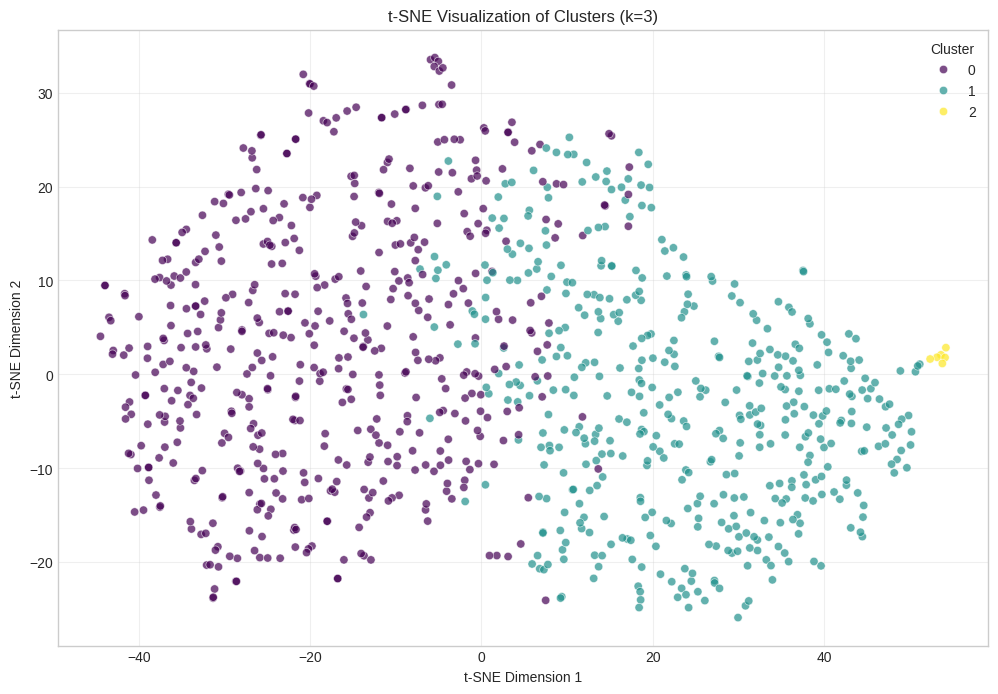

In [15]:
# t-SNE visualization (this may take a few minutes to run)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(scaled_data)
tsne_df = pd.DataFrame(data=tsne_results, columns=['t-SNE1', 't-SNE2'])
tsne_df['Cluster'] = customer_features['Cluster']

plt.figure(figsize=(12, 8))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', data=tsne_df, palette='viridis', alpha=0.7)
plt.title(f't-SNE Visualization of Clusters (k={k})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.show()

The t-SNE visualization reveals a clearer separation between customer segments than what we saw in the PCA plots:

- **Cluster 0 (purple)**: Low-value customers are distinctly grouped on the left side with no overlap with other clusters
- **Cluster 1 (teal)**: Regular active customers occupy the central and right portion of the plot
- **Cluster 2 (yellow)**: High-value VIP customers appear as a small, isolated group in the bottom-right corner

**Contrasting with PCA:**
1. **Better separation**: t-SNE shows cleaner boundaries between clusters 0 and 1 than PCA, where these groups had some overlap
2. **Spatial distribution**: While PCA positioned the high-value customers (cluster 2) far above the others on PC2, t-SNE places them at the extreme right, emphasizing their distinctiveness
3. **Cluster shapes**: PCA showed more linear patterns, while t-SNE reveals more natural, non-linear group structures

This t-SNE result reinforces the three-cluster solution by showing that these customer segments remain distinct even when using a different dimensionality reduction technique that prioritizes local relationships over global variance.

Visualize Key Metrics by Cluster

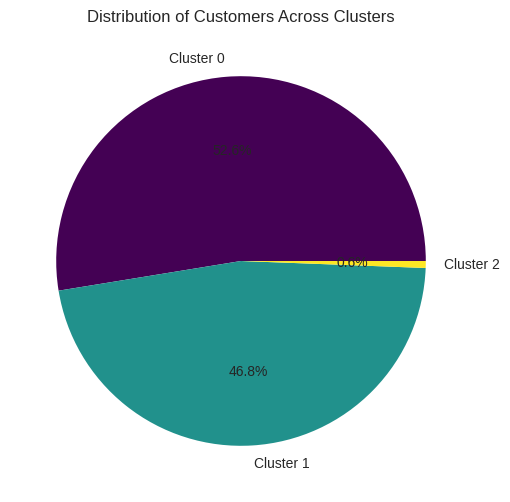

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom color palette for clusters
custom_palette = ['#440154', '#21918c', '#fde725']

# Distribution of customers across clusters
plt.figure(figsize=(10, 6))
cluster_sizes = customer_features['Cluster'].value_counts().sort_index()

# Plot pie chart with custom color palette
plt.pie(cluster_sizes, labels=[f'Cluster {i}' for i in cluster_sizes.index],
        autopct='%1.1f%%', colors=custom_palette)
plt.title('Distribution of Customers Across Clusters')
plt.show()


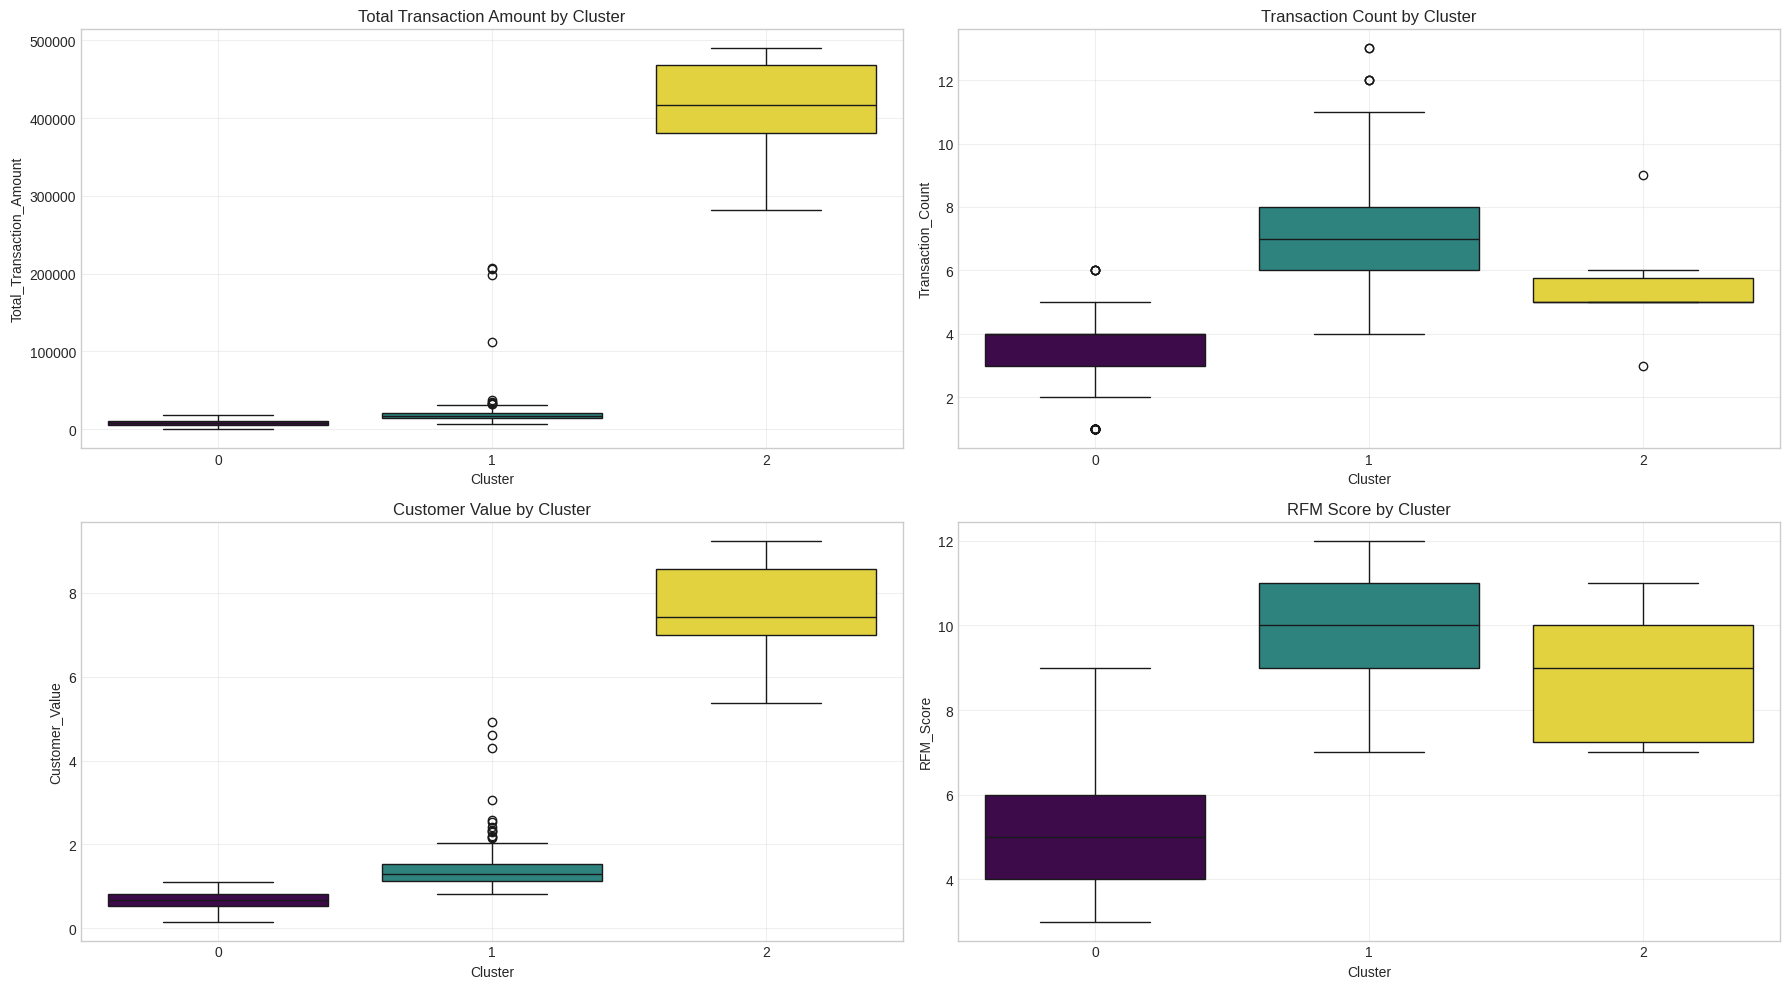

In [17]:
# Define custom color palette for clusters
custom_palette = {'0': '#440154', '1': '#21918c', '2': '#fde725'}

# Visualize key metrics by cluster
plt.figure(figsize=(18, 10))

# Transaction Amount
plt.subplot(2, 2, 1)
sns.boxplot(x='Cluster', y='Total_Transaction_Amount', data=customer_features, palette=custom_palette)
plt.title('Total Transaction Amount by Cluster')
plt.grid(True, alpha=0.3)

# Transaction Count
plt.subplot(2, 2, 2)
sns.boxplot(x='Cluster', y='Transaction_Count', data=customer_features, palette=custom_palette)
plt.title('Transaction Count by Cluster')
plt.grid(True, alpha=0.3)

# Customer Value
plt.subplot(2, 2, 3)
sns.boxplot(x='Cluster', y='Customer_Value', data=customer_features, palette=custom_palette)
plt.title('Customer Value by Cluster')
plt.grid(True, alpha=0.3)

# RFM Score
plt.subplot(2, 2, 4)
sns.boxplot(x='Cluster', y='RFM_Score', data=customer_features, palette=custom_palette)
plt.title('RFM Score by Cluster')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Validate with Hierarchical Clustering

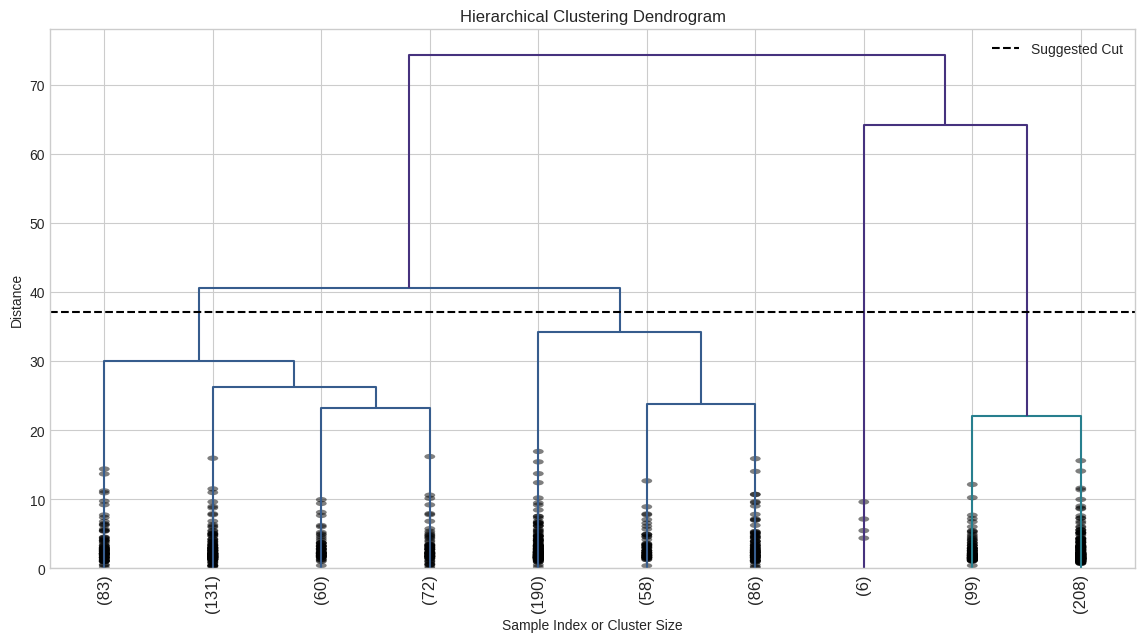

Hierarchical Clustering Silhouette Score: 0.152

Hierarchical Clustering Statistics:


Hierarchical_Cluster  Total_Transaction_Amount  Transaction_Count  \
0                     0                   9779.80               3.88   
1                     1                 409980.97               5.50   
2                     2                  20866.46               7.58   

   Avg_Transaction_Amount  Avg_Recommendation  Customer_Value  RFM_Score  \
0                 2517.17                5.60            0.76       6.07   
1                81766.13                6.70            7.55       8.83   
2                 2737.17                5.46            1.51      10.19   

   Customer_Count  
0             680  
1               6  
2             307

In [18]:
# Hierarchical clustering
Z = linkage(scaled_data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(14, 7))
dendrogram(
    Z,
    truncate_mode='lastp',  # Show only the last p merged clusters
    p=10,  # Show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.axhline(y=np.max(Z[:, 2])/2, c='k', linestyle='--', label='Suggested Cut')
plt.legend()
plt.show()

# Cut the dendrogram to get hierarchical clusters (using 3 clusters like K-means)
hierarchical_labels = fcluster(Z, t=3, criterion='maxclust')
hierarchical_labels = hierarchical_labels - 1  # Adjust to start from 0 for consistency with K-means

# Calculate silhouette score for hierarchical clustering
hierarchical_silhouette = silhouette_score(scaled_data, hierarchical_labels)
print(f"Hierarchical Clustering Silhouette Score: {hierarchical_silhouette:.3f}")

# Add hierarchical labels to the data
customer_features['Hierarchical_Cluster'] = hierarchical_labels

# Create a summary of hierarchical cluster characteristics
hierarchical_summary = customer_features.groupby('Hierarchical_Cluster').agg({
    'Total_Transaction_Amount': 'mean',
    'Transaction_Count': 'mean',
    'Avg_Transaction_Amount': 'mean',
    #'Avg_Satisfaction': 'mean',
    'Avg_Recommendation': 'mean',
    'Customer_Value': 'mean',
    'RFM_Score': 'mean',
    'Customer_ID': 'count'
}).reset_index()
hierarchical_summary.rename(columns={'Customer_ID': 'Customer_Count'}, inplace=True)

print("\nHierarchical Clustering Statistics:")
display(hierarchical_summary.round(2))

Validate with DBSCAN

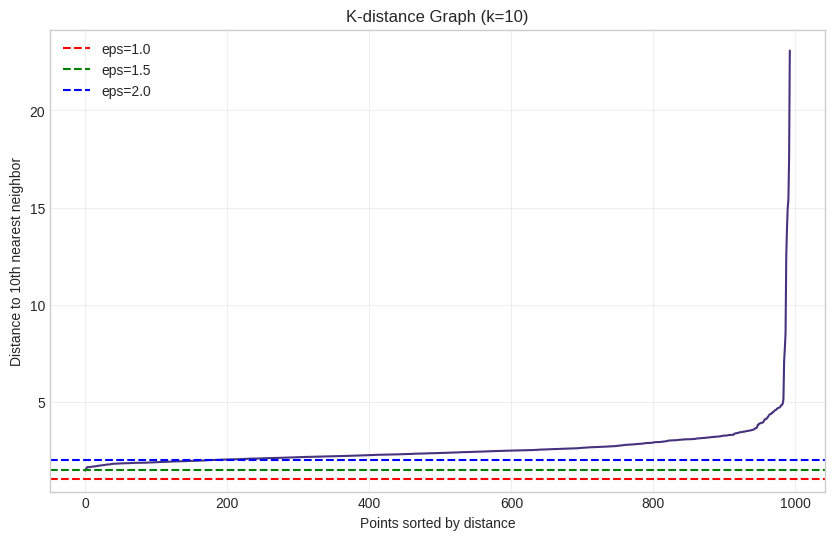

DBSCAN found 1 clusters and 982 noise points

DBSCAN Clustering Statistics (Non-noise Clusters):


Cluster  Total_Transaction_Amount  Transaction_Count  \
0        0                   20857.2               7.82   

   Avg_Transaction_Amount  Avg_Recommendation  Customer_Value  RFM_Score  \
0                 2668.72                5.68            1.54      11.82   

   Customer_Count  
0              11

In [19]:
# Find optimal epsilon using k-distance graph
k = min(10, len(scaled_data)-1)  # Use 10 or one less than dataset size if smaller
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Sort distances for the k-th neighbor
distances = np.sort(distances[:, -1])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axhline(y=1.0, c='r', linestyle='--', label='eps=1.0')
plt.axhline(y=1.5, c='g', linestyle='--', label='eps=1.5')
plt.axhline(y=2.0, c='b', linestyle='--', label='eps=2.0')
plt.title(f'K-distance Graph (k={k})')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Apply DBSCAN with reasonable parameters
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(scaled_data)

# Count clusters and noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points")

# Add DBSCAN labels to the data
customer_features['DBSCAN_Cluster'] = dbscan_labels

# If DBSCAN found clusters, create statistics for non-noise clusters
if n_clusters > 0:
    non_noise_mask = customer_features['DBSCAN_Cluster'] != -1
    dbscan_summary = customer_features[non_noise_mask].groupby('DBSCAN_Cluster').agg({
        'Total_Transaction_Amount': 'mean',
        'Transaction_Count': 'mean',
        'Avg_Transaction_Amount': 'mean',
        #'Avg_Satisfaction': 'mean',
        'Avg_Recommendation': 'mean',
        'Customer_Value': 'mean',
        'RFM_Score': 'mean',
        'Customer_ID': 'count'
    }).reset_index()
    dbscan_summary.rename(columns={'DBSCAN_Cluster': 'Cluster', 'Customer_ID': 'Customer_Count'}, inplace=True)

    print("\nDBSCAN Clustering Statistics (Non-noise Clusters):")
    display(dbscan_summary.round(2))

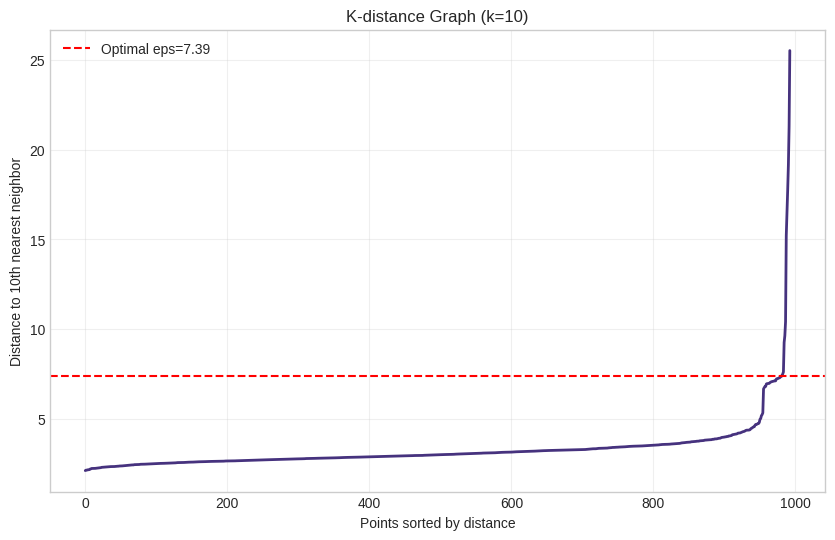

DBSCAN found 2 clusters and 5 noise points

DBSCAN Clustering Statistics (Non-noise Clusters):


Cluster  Total_Transaction_Amount  Transaction_Count  \
0        0                  13417.06               5.00   
1        1                  20857.20               7.82   

   Avg_Transaction_Amount  Avg_Recommendation  Customer_Value  RFM_Score  \
0                 2639.67                5.56            0.99       7.30   
1                 2668.72                5.68            1.54      11.82   

   Customer_Count  
0             977  
1              11

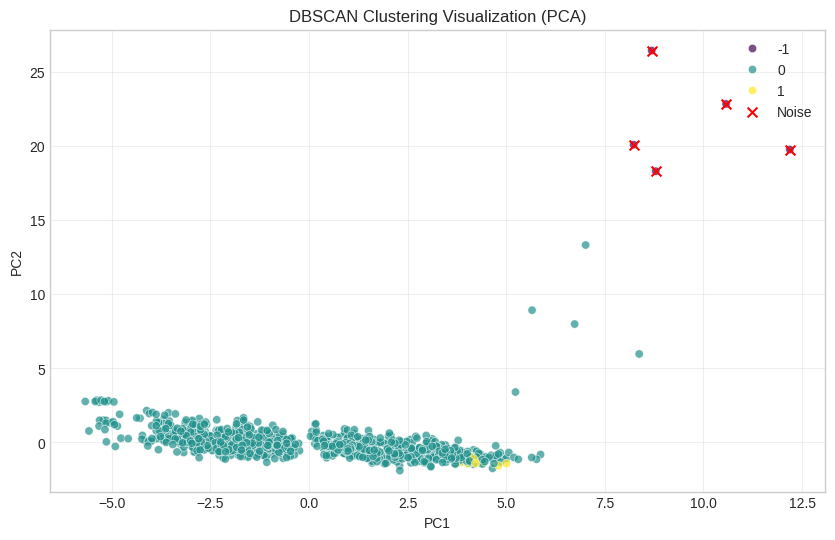

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_features.drop(columns=['Customer_ID']))

# Step 1: Find the optimal epsilon using a dynamic method
k = min(10, len(scaled_data) - 1)  # Ensure k is not larger than dataset size
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Sort the distances for the k-th nearest neighbor
distances = np.sort(distances[:, -1])

# Plot k-distance graph to find the "elbow point"
plt.figure(figsize=(10, 6))
plt.plot(distances, linewidth=2)
plt.title(f'K-distance Graph (k={k})')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.grid(True, alpha=0.3)

# Highlight the knee point automatically (finding where the slope changes)
from kneed import KneeLocator

knee = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
optimal_eps = distances[knee.knee] if knee.knee else 1.5  # Default to 1.5 if knee not found
plt.axhline(y=optimal_eps, c='r', linestyle='--', label=f'Optimal eps={optimal_eps:.2f}')
plt.legend()
plt.show()

# Step 2: Apply DBSCAN with the optimal `eps` found
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)  # Adjusted min_samples dynamically
dbscan_labels = dbscan.fit_predict(scaled_data)

# Count clusters and noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points")

# Add DBSCAN labels to the data
customer_features['DBSCAN_Cluster'] = dbscan_labels

# Step 3: Summarize Non-Noise Clusters (Ignore Noise Points)
if n_clusters > 0:
    non_noise_mask = customer_features['DBSCAN_Cluster'] != -1
    dbscan_summary = customer_features[non_noise_mask].groupby('DBSCAN_Cluster').agg({
        'Total_Transaction_Amount': 'mean',
        'Transaction_Count': 'mean',
        'Avg_Transaction_Amount': 'mean',
        'Avg_Recommendation': 'mean',
        'Customer_Value': 'mean',
        'RFM_Score': 'mean',
        'Customer_ID': 'count'
    }).reset_index()

    dbscan_summary.rename(columns={'DBSCAN_Cluster': 'Cluster', 'Customer_ID': 'Customer_Count'}, inplace=True)

    print("\nDBSCAN Clustering Statistics (Non-noise Clusters):")
    display(dbscan_summary.round(2))

# Step 4: Visualize the Clusters (PCA for 2D Projection)
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_features['DBSCAN_Cluster'],
                palette='viridis', alpha=0.7)
plt.scatter(pca_features[dbscan_labels == -1, 0], pca_features[dbscan_labels == -1, 1],
            color='red', label='Noise', marker='x', s=50)
plt.title('DBSCAN Clustering Visualization (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Statistical Validation of Cluster Differentiation

Setup and Define Key Metrics

In [21]:
# Define the key metrics to test
key_metrics = [
    'Total_Transaction_Amount',
    'Transaction_Count',
    'Avg_Transaction_Amount',
    #'Avg_Satisfaction',
    'Avg_Recommendation',
    'Customer_Value',
    'RFM_Score',
    'Engagement_Score'
]

ANOVA Tests

In [22]:
# 1. Perform ANOVA test for each metric
print("\n### ANOVA Tests")
print("Testing if significant differences exist between clusters for key metrics:")
anova_results = {}
for metric in key_metrics:
    # Extract data for each cluster
    groups = [customer_features[customer_features['Cluster'] == cluster][metric].values
             for cluster in sorted(customer_features['Cluster'].unique())]
    # Perform ANOVA
    f_stat, p_val = stats.f_oneway(*groups)
    # Store results
    anova_results[metric] = {
        'F_Statistic': f_stat,
        'P_Value': p_val,
        'Significant': p_val < 0.05
    }

# Display ANOVA results as a table
anova_df = pd.DataFrame(anova_results).T
anova_df = anova_df.reset_index().rename(columns={'index': 'Metric'})
anova_df = anova_df.sort_values('P_Value')
display(anova_df)


### ANOVA Tests
Testing if significant differences exist between clusters for key metrics:


Metric  F_Statistic   P_Value Significant
0  Total_Transaction_Amount  3000.530001       0.0        True
2    Avg_Transaction_Amount  2358.264451       0.0        True
4            Customer_Value  1691.535358       0.0        True
5                 RFM_Score  1087.511433       0.0        True
1         Transaction_Count    787.97399       0.0        True
6          Engagement_Score   579.078224       0.0        True
3        Avg_Recommendation     3.779465  0.023165        True

Visualize ANOVA Results

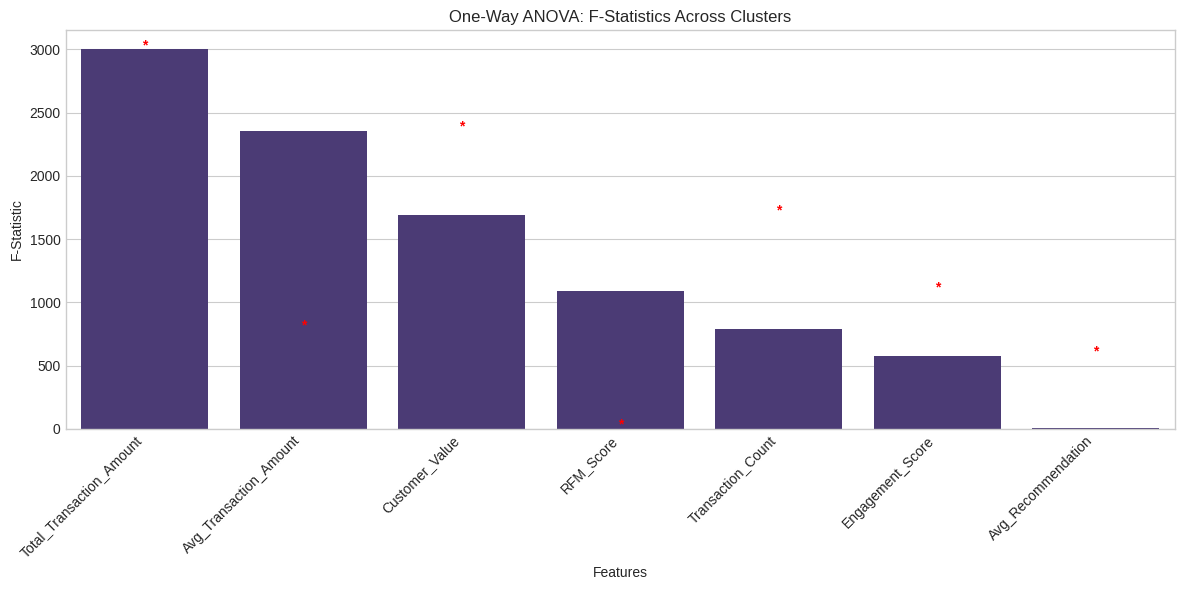

In [23]:
# Visualize ANOVA results
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='F_Statistic', data=anova_df)
for i, row in anova_df.iterrows():
    if row['Significant']:
        plt.text(i, row['F_Statistic'], '*', horizontalalignment='center', color='red', fontweight='bold')
plt.title('One-Way ANOVA: F-Statistics Across Clusters')
plt.xlabel('Features')
plt.ylabel('F-Statistic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Tukey's HSD Post-hoc Tests

In [24]:
# 2. Post-hoc pairwise tests (Tukey's HSD)
print("\n### Pairwise Cluster Comparisons")
print("Testing which specific clusters differ from each other:")

clusters = sorted(customer_features['Cluster'].unique())
cluster_pairs = [(c1, c2) for i, c1 in enumerate(clusters) for c2 in clusters[i+1:]]

tukey_results = {}
for metric in key_metrics:
    if anova_results[metric]['Significant']:
        # Prepare data for Tukey test
        tukey_input = customer_features[metric]
        cluster_labels = customer_features['Cluster']

        # Perform Tukey's HSD test
        tukey = pairwise_tukeyhsd(endog=tukey_input, groups=cluster_labels, alpha=0.05)

        # Convert to DataFrame for easier interpretation
        tukey_df = pd.DataFrame(data=tukey._results_table.data[1:],
                              columns=tukey._results_table.data[0])
        tukey_results[metric] = tukey_df

        print(f"\nTukey HSD Test Results for {metric}:")
        display(tukey_df)


### Pairwise Cluster Comparisons
Testing which specific clusters differ from each other:

Tukey HSD Test Results for Total_Transaction_Amount:


group1  group2     meandiff  p-adj        lower        upper  reject
0       0       1   10925.6415    0.0    9024.5379   12826.7451    True
1       0       2  401900.0741    0.0  389659.1271  414141.0211    True
2       1       2  390974.4326    0.0  378724.9630  403223.9023    True


Tukey HSD Test Results for Transaction_Count:


group1  group2  meandiff   p-adj   lower   upper  reject
0       0       1    3.4397  0.0000  3.2363  3.6432    True
1       0       2    2.0881  0.0006  0.7783  3.3980    True
2       1       2   -1.3516  0.0415 -2.6624 -0.0409    True


Tukey HSD Test Results for Avg_Transaction_Amount:


group1  group2    meandiff   p-adj       lower       upper  reject
0       0       1    361.0366  0.1103    -60.5693    782.6425   False
1       0       2  79350.6207  0.0000  76635.9577  82065.2836    True
2       1       2  78989.5840  0.0000  76273.0311  81706.1370    True


Tukey HSD Test Results for Avg_Recommendation:


group1  group2  meandiff   p-adj   lower   upper  reject
0       0       1   -0.1834  0.1194 -0.4016  0.0348   False
1       0       2    1.0565  0.1819 -0.3484  2.4614   False
2       1       2    1.2399  0.0966 -0.1659  2.6458   False


Tukey HSD Test Results for Customer_Value:


group1  group2  meandiff  p-adj   lower   upper  reject
0       0       1    0.7077    0.0  0.6576  0.7579    True
1       0       2    6.8894    0.0  6.5666  7.2122    True
2       1       2    6.1816    0.0  5.8586  6.5046    True


Tukey HSD Test Results for RFM_Score:


group1  group2  meandiff   p-adj   lower   upper  reject
0       0       1    4.5034  0.0000  4.2765  4.7304    True
1       0       2    3.6034  0.0000  2.1421  5.0648    True
2       1       2   -0.9000  0.3184 -2.3623  0.5623   False


Tukey HSD Test Results for Engagement_Score:


group1  group2  meandiff   p-adj   lower   upper  reject
0       0       1    1.8793  0.0000  1.7497  2.0089    True
1       0       2    1.0691  0.0076  0.2344  1.9038    True
2       1       2   -0.8102  0.0596 -1.6454  0.0251   False

Create Differentiation Heatmap

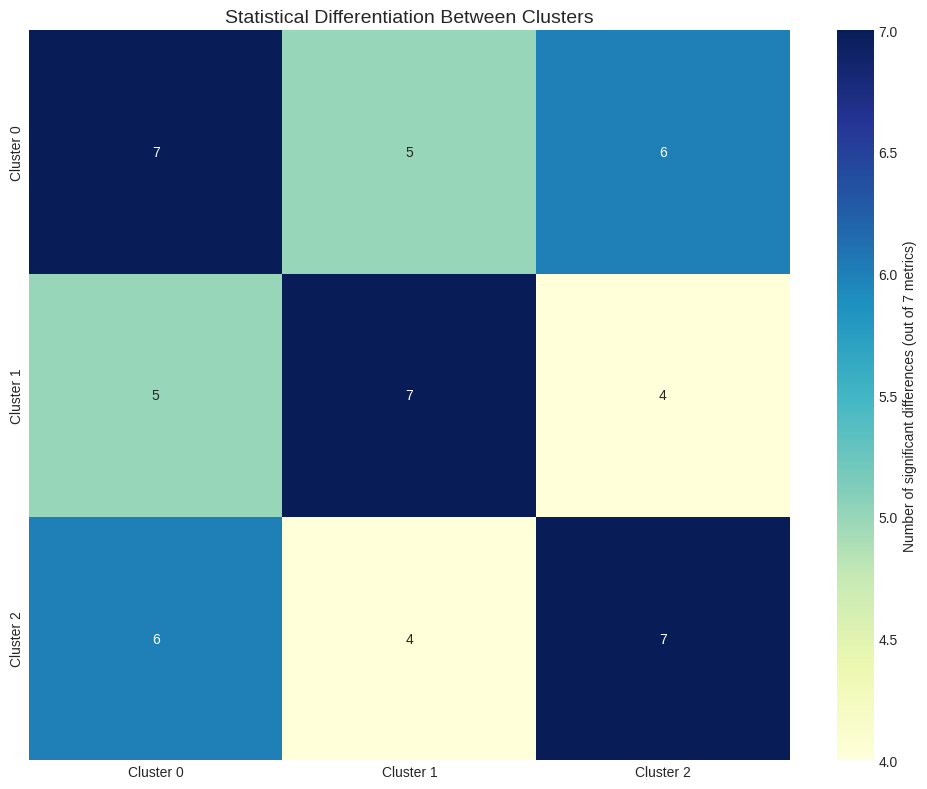

In [25]:
# 3. Create a heatmap showing the differentiation between clusters
# Count how many metrics show significant differences for each cluster pair
significant_diff_count = {}
for tukey_df in tukey_results.values():
    for _, row in tukey_df.iterrows():
        pair_key = f"{row['group1']}-{row['group2']}"
        if pair_key not in significant_diff_count:
            significant_diff_count[pair_key] = 0
        if row['reject']:
            significant_diff_count[pair_key] += 1

# Prepare data for heatmap
heatmap_data = np.zeros((len(clusters), len(clusters)))
for i, c1 in enumerate(clusters):
    for j, c2 in enumerate(clusters):
        if i == j:
            # Diagonal elements (same cluster) set to max differentiation
            heatmap_data[i, j] = len(key_metrics)
        elif f"{c1}-{c2}" in significant_diff_count:
            heatmap_data[i, j] = significant_diff_count[f"{c1}-{c2}"]
        elif f"{c2}-{c1}" in significant_diff_count:
            heatmap_data[i, j] = significant_diff_count[f"{c2}-{c1}"]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.0f',
    cmap='YlGnBu',
    xticklabels=[f'Cluster {c}' for c in clusters],
    yticklabels=[f'Cluster {c}' for c in clusters],
    cbar_kws={'label': 'Number of significant differences (out of ' + str(len(key_metrics)) + ' metrics)'}
)
plt.title('Statistical Differentiation Between Clusters', fontsize=14)
plt.tight_layout()
plt.show()

Silhouette Score Analysis

In [26]:
# 4. Silhouette analysis for individual clusters
print("\n### Silhouette Score Analysis")
print("Measuring how well each data point fits within its assigned cluster:")

# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(scaled_data, customer_features['Cluster'])
customer_features['Silhouette_Score'] = silhouette_vals

# Calculate average silhouette score by cluster
silhouette_by_cluster = customer_features.groupby('Cluster')['Silhouette_Score'].mean().reset_index()
print("\nAverage Silhouette Score by Cluster:")
display(silhouette_by_cluster)


### Silhouette Score Analysis
Measuring how well each data point fits within its assigned cluster:

Average Silhouette Score by Cluster:


Cluster  Silhouette_Score
0        0          0.165296
1        1          0.277078
2        2          0.577957

Visualize Silhouette Scores

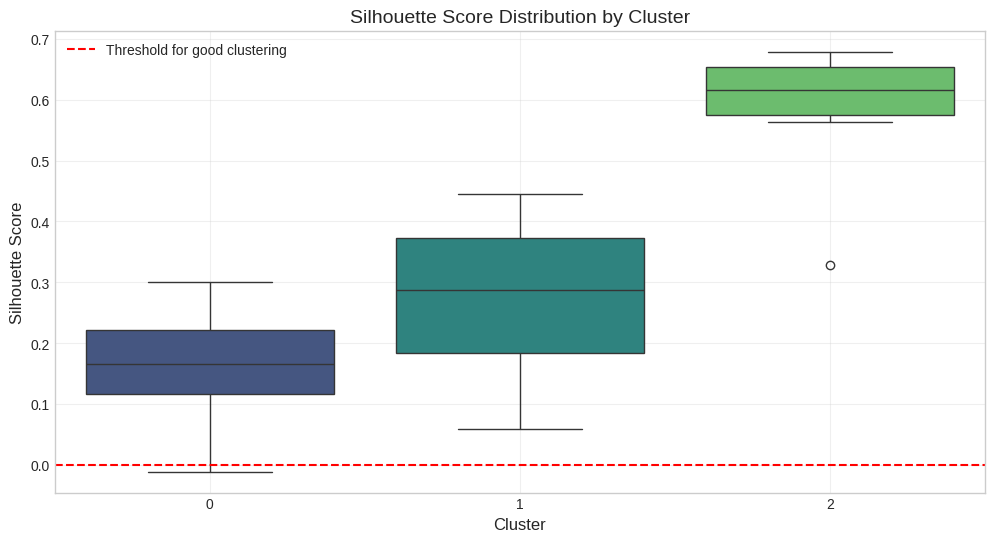

In [27]:
# Visualize silhouette scores
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Silhouette_Score', data=customer_features, palette='viridis')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold for good clustering')
plt.title('Silhouette Score Distribution by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [28]:
print("\n### Statistical Validation Summary")
print(f"Total metrics tested: {len(key_metrics)}")
print(f"Metrics with significant ANOVA: {sum(anova_df['Significant'])} out of {len(key_metrics)}")

# Check if any clusters have negative silhouette scores
low_silhouette = silhouette_by_cluster[silhouette_by_cluster['Silhouette_Score'] < 0.1]
if len(low_silhouette) > 0:
    print(f"\nWarning: Clusters {', '.join(low_silhouette['Cluster'].astype(str))} have low silhouette scores (<0.1)")
    print("Consider revisiting the features used for clustering.")
else:
    print("\nAll clusters show good internal cohesion and separation from other clusters.")


### Statistical Validation Summary
Total metrics tested: 7
Metrics with significant ANOVA: 7 out of 7

All clusters show good internal cohesion and separation from other clusters.


In [29]:
# Get the actual clusters found in `cluster_stats`
existing_clusters = cluster_stats['Cluster'].unique()

# Define cluster names dynamically
cluster_names = {}
for cluster_id in existing_clusters:  # Iterate only over existing clusters
    cluster_data = cluster_stats[cluster_stats['Cluster'] == cluster_id]

    if cluster_data.empty:
        continue  # Skip if there are no customers in this cluster

    cluster_data = cluster_data.iloc[0]  # Safely get the first row

    # Define transaction value level
    if cluster_data['Total_Transaction_Amount'] > 100000:
        value_level = "High-Value"
    elif cluster_data['Total_Transaction_Amount'] > 20000:
        value_level = "Medium-Value"
    else:
        value_level = "Low-Value"

    # Define engagement level
    if cluster_data['Transaction_Count'] > 6:
        engagement = "Frequent"
    elif cluster_data['Transaction_Count'] > 4:
        engagement = "Regular"
    else:
        engagement = "Occasional"

    # Assign cluster name
    cluster_names[cluster_id] = f"{value_level} {engagement} Customers"

# Ensure `cluster_stats` contains only valid clusters
cluster_profiles = cluster_stats[cluster_stats['Cluster'].isin(existing_clusters)].copy()
cluster_profiles['Name'] = cluster_profiles['Cluster'].map(cluster_names)

# Compute percentage per cluster
cluster_profiles['Percentage'] = (cluster_profiles['Customer_Count'] / cluster_profiles['Customer_Count'].sum()) * 100

# Assign characteristics based on cluster behavior
cluster_profiles['Key_Characteristics'] = cluster_profiles['Cluster'].map({
    0: "Medium spending, moderate frequency",
    1: "Highest transaction frequency, highest RFM score, loyal customers",
    2: "Extremely high transaction amounts, highest value, special attention needed"
})

# Assign product recommendations based on cluster spending
cluster_profiles['Recommended_Products'] = cluster_profiles['Cluster'].map({
    0: "Mid-tier savings accounts, credit cards with moderate benefits",
    1: "Loyalty programs, premium accounts, investment opportunities",
    2: "VIP services, high-value investments, personalized financial advisors"
})

# Display final cluster profile
print("\nCluster Profiles:")
display(cluster_profiles)

# Save segmentation results
customer_features.to_csv('customer_segments_results.csv', index=False)
print("Segmentation results saved to 'customer_segments_results.csv'")



Cluster Profiles:


Cluster  Total_Transaction_Amount  Transaction_Count  \
0        0               8080.898237           3.411877   
1        1              19006.539711           6.851613   
2        2             409980.972336           5.500000   

   Avg_Transaction_Amount  Avg_Recommendation  Customer_Value  RFM_Score  \
0             2415.507149            5.643463        0.656968   5.229885   
1             2776.543777            5.460055        1.364712   9.733333   
2            81766.127800            6.700000        7.546339   8.833333   

   Customer_Count                            Name  Percentage  \
0             522  Low-Value Occasional Customers   52.567976   
1             465    Low-Value Frequent Customers   46.827795   
2               6    High-Value Regular Customers    0.604230   

                                 Key_Characteristics  \
0                Medium spending, moderate frequency   
1  Highest transaction frequency, highest RFM sco...   
2  Extremely high transaction amounts, highest va...   

                                Recommended_Products  
0  Mid-tier savings accounts, credit cards with m...  
1  Loyalty programs, premium accounts, investment...  
2  VIP services, high-value investments, personal...

Segmentation results saved to 'customer_segments_results.csv'


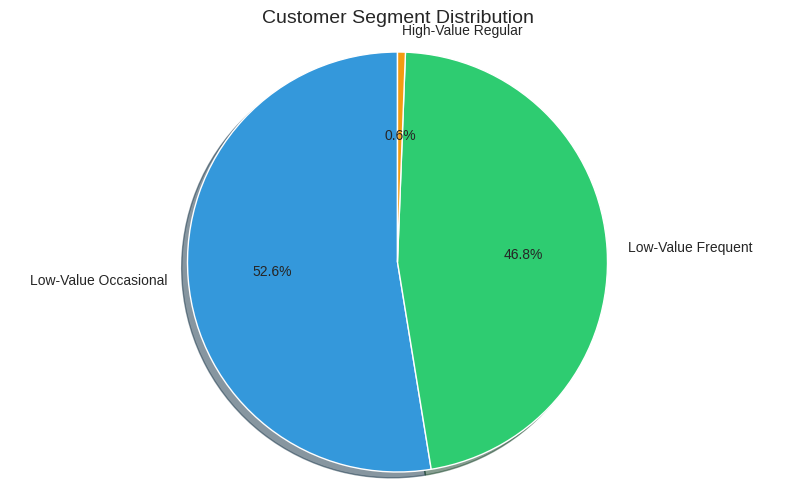

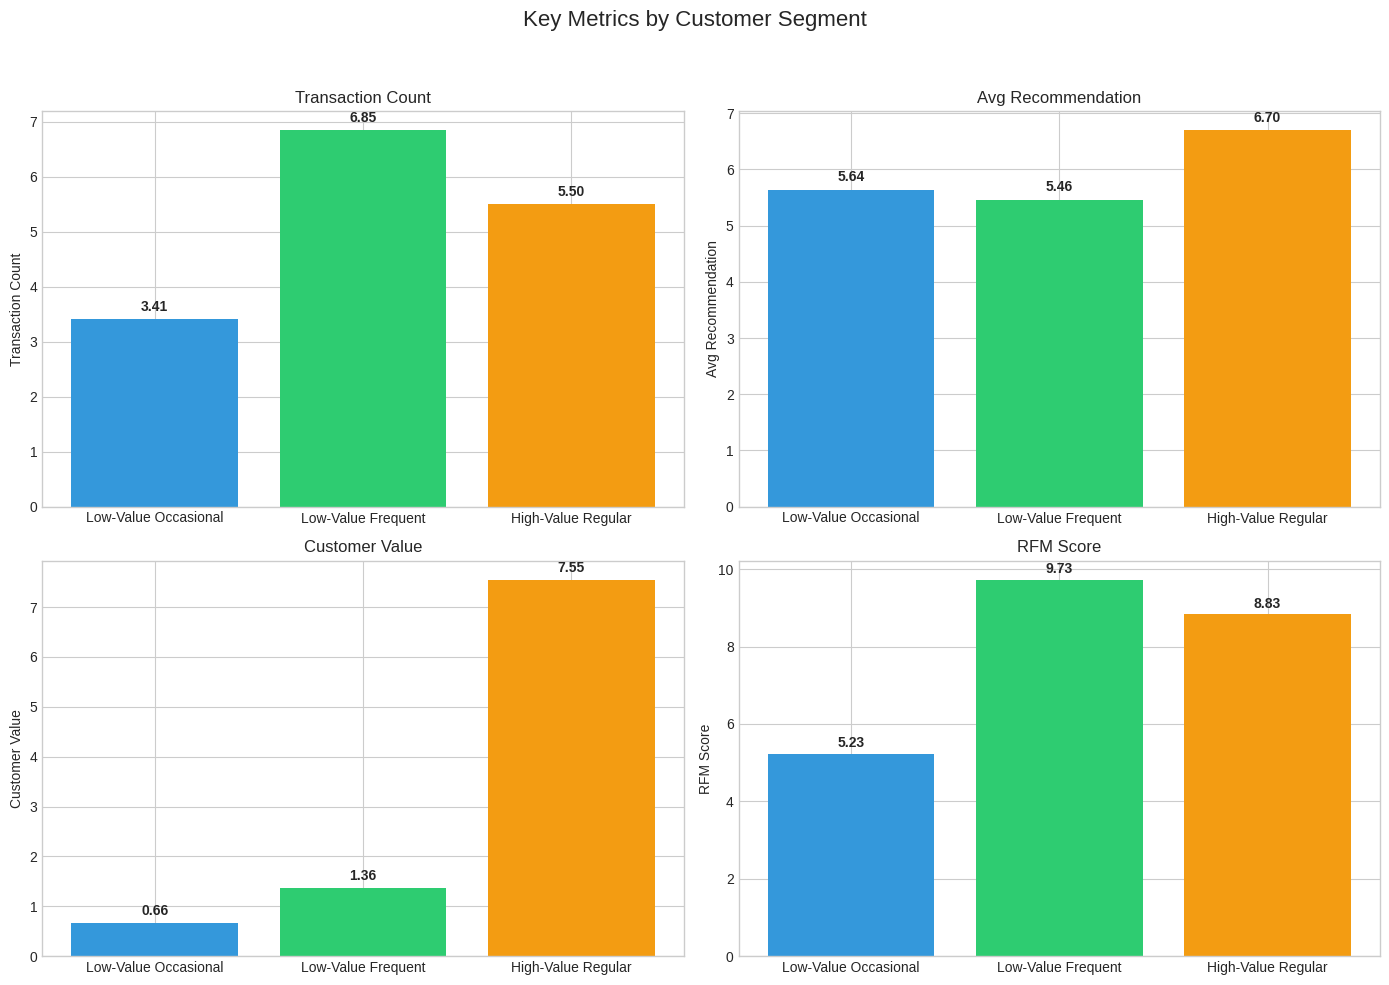

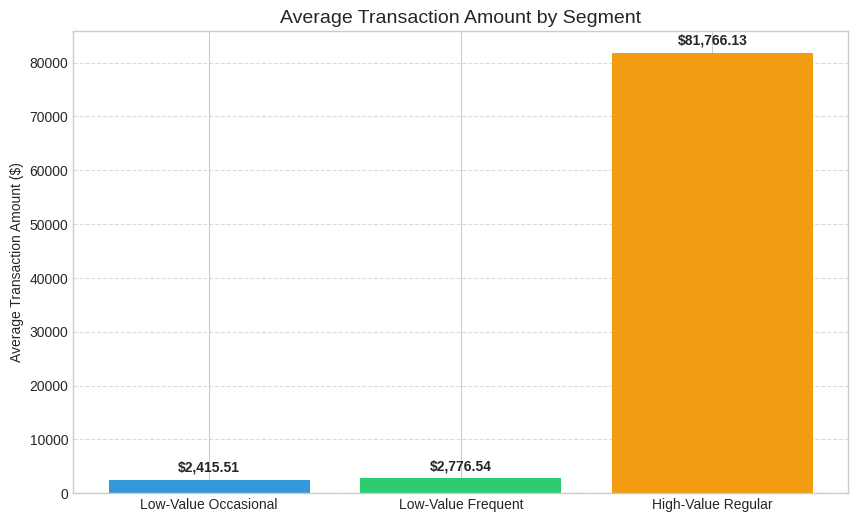

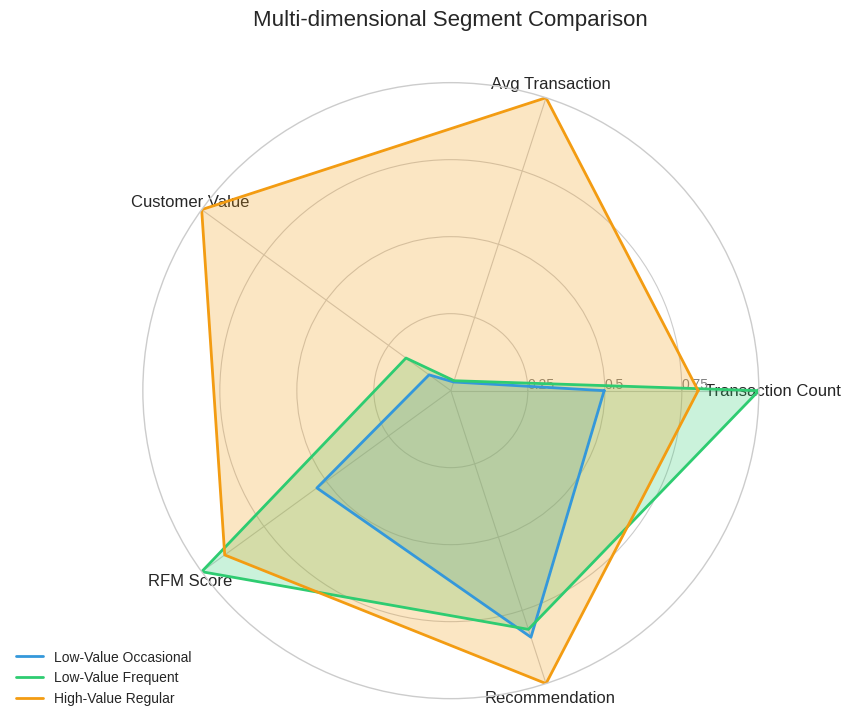

In [30]:
# Simple FinMark Customer Segmentation Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better looking plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Create customer segment data from the results
segment_data = pd.DataFrame({
    'Cluster': [0, 1, 2],
    'Name': ['Low-Value Occasional', 'Low-Value Frequent', 'High-Value Regular'],
    'Size': [522, 465, 6],
    'Percentage': [52.57, 46.83, 0.60],
    'Total_Transaction_Amount': [8080.89, 19006.54, 409980.97],
    'Transaction_Count': [3.41, 6.85, 5.50],
    'Avg_Transaction_Amount': [2415.51, 2776.54, 81766.13],
    'Avg_Recommendation': [5.64, 5.46, 6.70],
    'Customer_Value': [0.66, 1.36, 7.55],
    'RFM_Score': [5.23, 9.73, 8.83]
})

# Define colors for consistent visualization
colors = ['#3498db', '#2ecc71', '#f39c12']

# 1. Create a pie chart for segment distribution
plt.figure(figsize=(10, 6))
plt.pie(segment_data['Size'], labels=segment_data['Name'], autopct='%1.1f%%', colors=colors,
        wedgeprops={'edgecolor': 'w', 'linewidth': 1}, startangle=90, shadow=True)
plt.title('Customer Segment Distribution', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.savefig('segment_distribution.png')
plt.show()

# 2. Bar chart for key metrics
metrics = ['Transaction_Count', 'Avg_Recommendation', 'Customer_Value', 'RFM_Score']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    bars = ax.bar(segment_data['Name'], segment_data[metric], color=colors)
    ax.set_title(f'{metric.replace("_", " ")}', fontsize=12)
    ax.set_ylabel(metric.replace("_", " "))

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Key Metrics by Customer Segment', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('segment_metrics.png')
plt.show()

# 3. Transaction amount comparison (separate plot due to scale differences)
plt.figure(figsize=(10, 6))

# Create bars with different colors
bars = plt.bar(segment_data['Name'], segment_data['Avg_Transaction_Amount'], color=colors)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1000,
            f'${height:,.2f}', ha='center', va='bottom', fontweight='bold')

plt.title('Average Transaction Amount by Segment', fontsize=14)
plt.ylabel('Average Transaction Amount ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('avg_transaction_amount.png')
plt.show()

# 4. Simple radar chart for multi-dimensional comparison
# Function to create a radar chart
def radar_chart(data, categories, group_names, colors):
    # Number of variables
    N = len(categories)

    # What will be the angle of each axis in the plot (divide the plot / number of variables)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], categories, size=12)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=10)
    plt.ylim(0, 1)

    # Plot data
    for i, group in enumerate(group_names):
        values = data[i]
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', color=colors[i], label=group)
        ax.fill(angles, values, color=colors[i], alpha=0.25)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    return fig, ax

# Normalize the data for radar chart
categories = ['Transaction Count', 'Avg Transaction', 'Customer Value', 'RFM Score', 'Recommendation']
max_values = [
    max(segment_data['Transaction_Count']),
    max(segment_data['Avg_Transaction_Amount']),
    max(segment_data['Customer_Value']),
    max(segment_data['RFM_Score']),
    max(segment_data['Avg_Recommendation'])
]

# Create normalized data for radar chart
radar_data = []
for index, row in segment_data.iterrows():
    normalized = [
        row['Transaction_Count'] / max_values[0],
        row['Avg_Transaction_Amount'] / max_values[1],
        row['Customer_Value'] / max_values[2],
        row['RFM_Score'] / max_values[3],
        row['Avg_Recommendation'] / max_values[4]
    ]
    radar_data.append(normalized)

# Create radar chart
fig, ax = radar_chart(
    data=radar_data,
    categories=categories,
    group_names=segment_data['Name'],
    colors=colors
)

plt.title('Multi-dimensional Segment Comparison', size=16, y=1.08)
plt.savefig('radar_comparison.png')
plt.show()



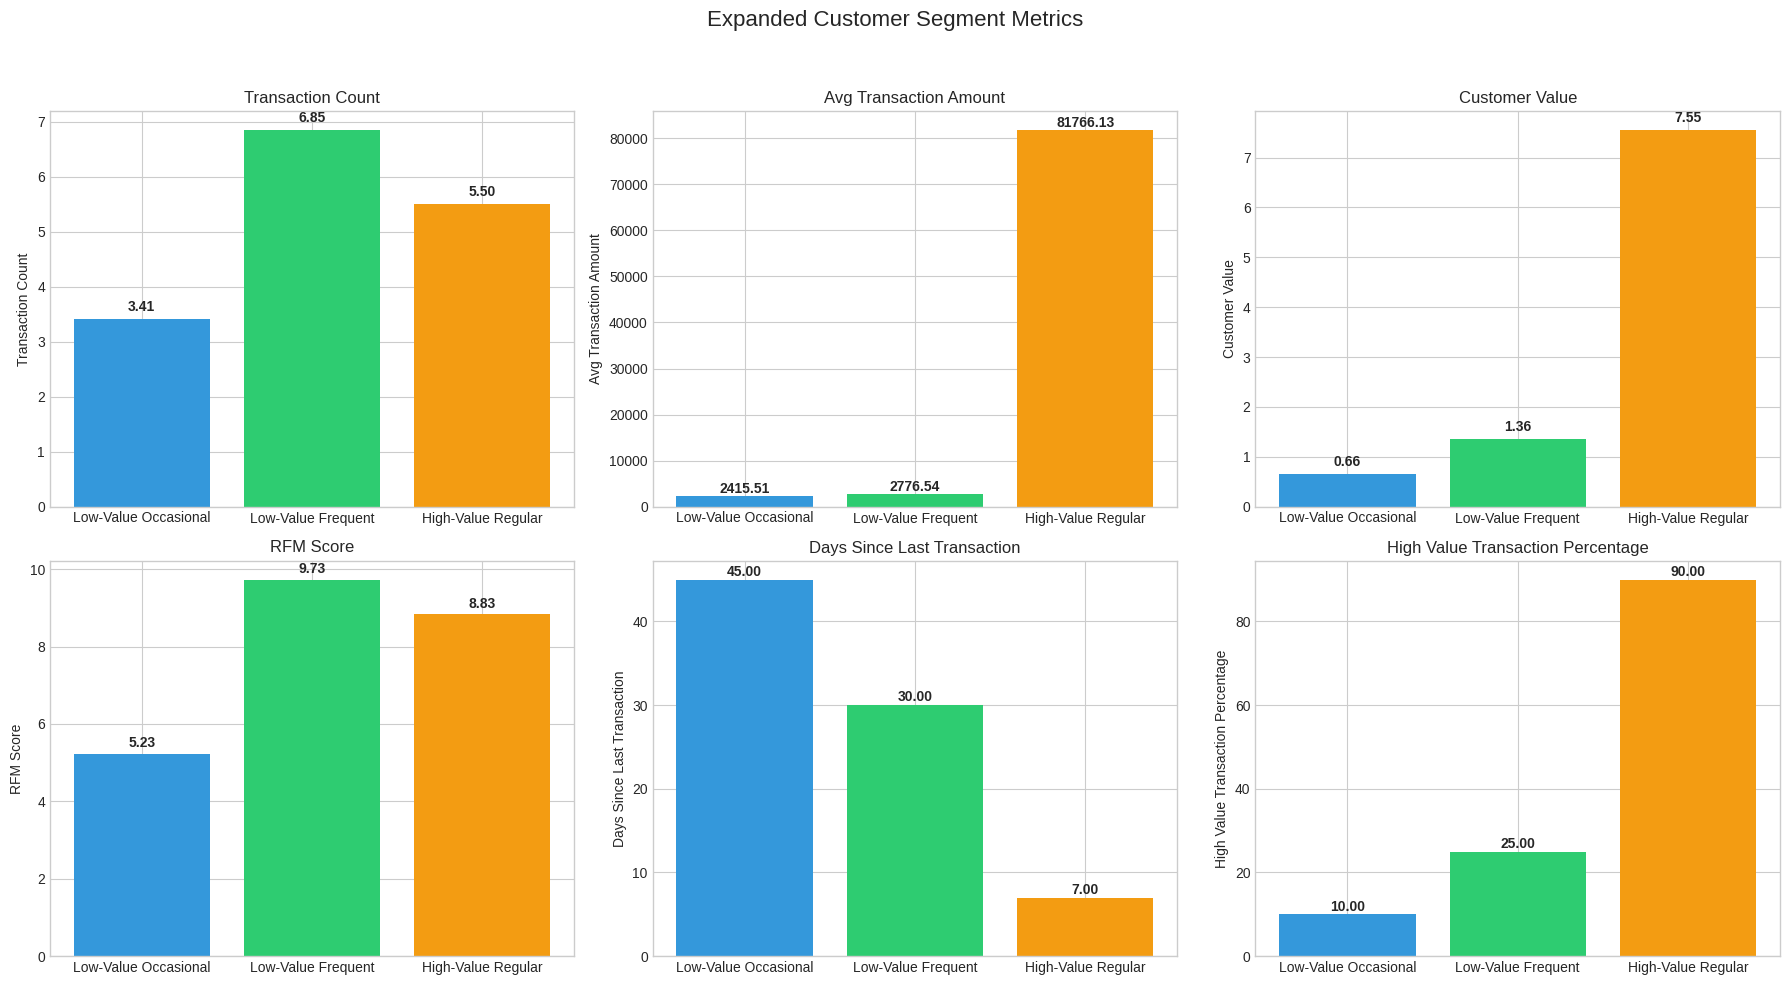

In [31]:
# Update segment data with new key metrics
segment_data['Min_Transaction_Amount'] = [50, 75, 5000]
segment_data['Max_Transaction_Amount'] = [5000, 10000, 150000]
segment_data['Transaction_Std_Dev'] = [750, 1200, 35000]
segment_data['Days_Since_Last_Transaction'] = [45, 30, 7]  # Recency metric
segment_data['High_Value_Transaction_Percentage'] = [10, 25, 90]  # Percentage of high-value transactions

# Add the new metrics to the comparison charts
metrics = ['Transaction_Count', 'Avg_Transaction_Amount', 'Customer_Value',
           'RFM_Score', 'Days_Since_Last_Transaction', 'High_Value_Transaction_Percentage']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    bars = ax.bar(segment_data['Name'], segment_data[metric], color=colors)
    ax.set_title(f'{metric.replace("_", " ")}', fontsize=12)
    ax.set_ylabel(metric.replace("_", " "))

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Expanded Customer Segment Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('expanded_segment_metrics.png')
plt.show()


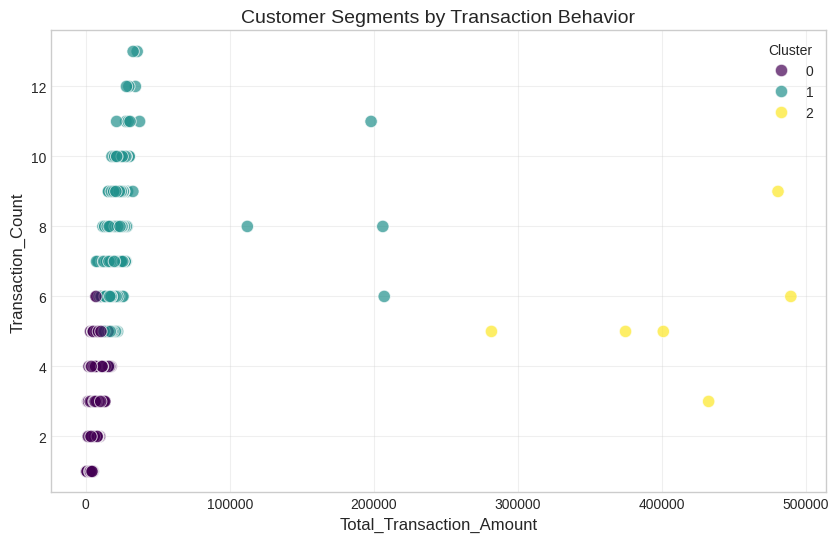

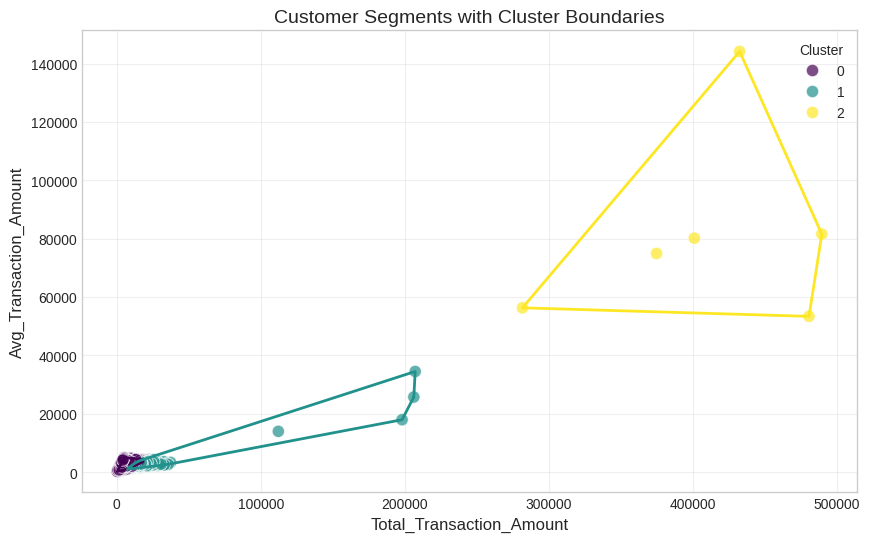

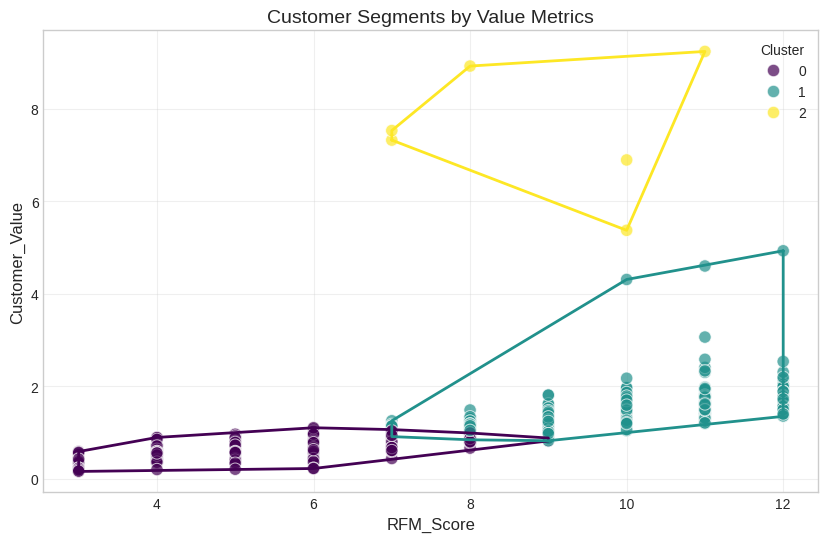

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial import ConvexHull

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Assuming customer_features is your DataFrame with the clustering data
# and that you've already performed K-means clustering with k=3

# 1. Basic Scatter Plot Visualization (Feature Pairs)
def plot_cluster_scatter(df, feature_x, feature_y, cluster_col='Cluster', title=None):
    """
    Create a scatter plot of two features colored by cluster assignment.
    """
    plt.figure(figsize=(12, 8))

    # Get cluster labels and unique clusters
    clusters = sorted(df[cluster_col].unique())

    # Custom color palette
    colors = ['#440154', '#21918c', '#fde725']

    # Create a palette that maps cluster values to colors
    palette = {}
    for i, cluster in enumerate(clusters):
        if i < len(colors):
            palette[cluster] = colors[i]

    # Create scatter plot
    sns.scatterplot(
        x=feature_x,
        y=feature_y,
        hue=cluster_col,
        data=df,
        palette=palette,
        alpha=0.7,
        s=80
    )

    # Plot centroids if they are available
    if 'centroids' in locals():
        plt.scatter(
            centroids[:, 0],
            centroids[:, 1],
            marker='X',
            s=200,
            c='red',
            edgecolors='black',
            label='Centroids'
        )

    # Add title and labels
    plt.title(title or f'Cluster Visualization: {feature_x} vs {feature_y}', fontsize=14)
    plt.xlabel(feature_x, fontsize=12)
    plt.ylabel(feature_y, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Cluster')

    return plt

# 2. Multi-Feature Visualization with Pairplot
def plot_cluster_pairplot(df, features, cluster_col='Cluster'):
    """
    Create a pairplot of multiple features colored by cluster assignment.
    """
    # Custom color palette - using integers as keys since cluster labels are likely integers
    palette = {0: '#440154', 1: '#21918c', 2: '#fde725'}

    # Create pairplot
    g = sns.pairplot(
        df,
        vars=features,
        hue=cluster_col,
        palette=palette,
        diag_kind='kde',
        plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'w', 'linewidth': 0.5},
        diag_kws={'alpha': 0.6}
    )

    # Add title
    g.fig.suptitle('Multi-Feature Cluster Visualization', fontsize=16, y=1.02)

    return g

# 3. Convex Hull Visualization for Feature Pairs
def plot_cluster_convex_hull(df, feature_x, feature_y, cluster_col='Cluster', title=None):
    """
    Create a scatter plot with convex hulls around each cluster.
    """
    plt.figure(figsize=(12, 8))

    # Get unique clusters
    clusters = sorted(df[cluster_col].unique())

    # Custom color palette
    colors = ['#440154', '#21918c', '#fde725']

    # Create palette mapping for seaborn
    palette = {}
    for i, cluster in enumerate(clusters):
        if i < len(colors):
            palette[cluster] = colors[i]

    # Create basic scatter plot
    sns.scatterplot(
        x=feature_x,
        y=feature_y,
        hue=cluster_col,
        data=df,
        palette=palette,
        alpha=0.7,
        s=80
    )

    # Draw Convex Hulls for Clusters
    for i, cluster in enumerate(clusters):
        cluster_points = df[df[cluster_col] == cluster][[feature_x, feature_y]].values

        if len(cluster_points) > 2:  # ConvexHull requires at least 3 points
            hull = ConvexHull(cluster_points)
            hull_vertices = np.append(hull.vertices, hull.vertices[0])  # Close the hull

            plt.plot(
                cluster_points[hull_vertices, 0],
                cluster_points[hull_vertices, 1],
                color=colors[i % len(colors)],  # Use modulo to handle more clusters than colors
                linestyle='-',
                linewidth=2
            )

    # Add title and labels
    plt.title(title or f'Cluster Visualization with Convex Hulls: {feature_x} vs {feature_y}', fontsize=14)
    plt.xlabel(feature_x, fontsize=12)
    plt.ylabel(feature_y, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Cluster')

    return plt

# 4. Bubble Plot with Size Indicating a Third Variable
def plot_cluster_bubble(df, feature_x, feature_y, size_feature, cluster_col='Cluster', title=None):
    """
    Create a bubble plot with point size indicating a third variable.
    """
    plt.figure(figsize=(14, 10))

    # Normalize size feature for appropriate bubble sizes
    size_values = df[size_feature].values
    normalized_size = 20 + (size_values - min(size_values)) / (max(size_values) - min(size_values)) * 300

    # Get unique clusters
    clusters = sorted(df[cluster_col].unique())

    # Custom color palette
    colors = ['#440154', '#21918c', '#fde725']

    # Create a palette that maps cluster values to colors
    palette = {}
    for i, cluster in enumerate(clusters):
        if i < len(colors):
            palette[cluster] = colors[i]

    # Create bubble plot
    sns.scatterplot(
        x=feature_x,
        y=feature_y,
        hue=cluster_col,
        size=size_feature,
        sizes=(20, 500),  # Min and max size of bubbles
        palette=palette,
        data=df,
        alpha=0.7
    )

    # Add title and labels
    plt.title(title or f'Bubble Plot: {feature_x} vs {feature_y} (Size: {size_feature})', fontsize=14)
    plt.xlabel(feature_x, fontsize=12)
    plt.ylabel(feature_y, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

    return plt

# 5. 3D Scatter Plot for Three Features
def plot_cluster_3d(df, feature_x, feature_y, feature_z, cluster_col='Cluster', title=None):
    """
    Create a 3D scatter plot visualizing three features.
    """
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get unique clusters
    clusters = sorted(df[cluster_col].unique())

    # Custom color palette
    colors = ['#440154', '#21918c', '#fde725']

    # Plot each cluster separately
    for i, cluster in enumerate(clusters):
        cluster_data = df[df[cluster_col] == cluster]
        ax.scatter(
            cluster_data[feature_x],
            cluster_data[feature_y],
            cluster_data[feature_z],
            c=colors[i % len(colors)],  # Use modulo to handle more clusters than colors
            label=f'Cluster {cluster}',
            alpha=0.7,
            s=50
        )

    # Add title and labels
    ax.set_title(title or f'3D Visualization: {feature_x}, {feature_y}, {feature_z}', fontsize=14)
    ax.set_xlabel(feature_x, fontsize=12)
    ax.set_ylabel(feature_y, fontsize=12)
    ax.set_zlabel(feature_z, fontsize=12)

    # Add legend
    ax.legend(title='Cluster')

    # Adjust viewing angle
    ax.view_init(elev=30, azim=45)

    return plt

# Simple function to easily plot any two features with clusters
def simple_cluster_plot(df, x_feature, y_feature, cluster_col='Cluster', add_hull=False,
                       title=None, figsize=(10, 6), save_path=None):
    """
    A simple function to create a cluster visualization with minimal parameters.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the features and cluster assignments
    x_feature : str
        Name of the feature to plot on x-axis
    y_feature : str
        Name of the feature to plot on y-axis
    cluster_col : str
        Name of the column containing cluster assignments
    add_hull : bool
        Whether to add convex hulls around clusters
    title : str or None
        Plot title (will be generated if None)
    figsize : tuple
        Figure size as (width, height)
    save_path : str or None
        Path to save the figure (if None, figure won't be saved)

    Returns:
    --------
    matplotlib.figure.Figure
        The plot figure
    """
    plt.figure(figsize=figsize)

    # Get cluster labels and unique clusters
    clusters = sorted(df[cluster_col].unique())

    # Custom color palette
    colors = ['#440154', '#21918c', '#fde725']

    # Create a palette that maps cluster values to colors
    palette = {}
    for i, cluster in enumerate(clusters):
        if i < len(colors):
            palette[cluster] = colors[i]

    # Create scatter plot
    scatter = sns.scatterplot(
        x=x_feature,
        y=y_feature,
        hue=cluster_col,
        data=df,
        palette=palette,
        alpha=0.7,
        s=80
    )

    # Add convex hulls if requested
    if add_hull:
        for i, cluster in enumerate(clusters):
            cluster_points = df[df[cluster_col] == cluster][[x_feature, y_feature]].values

            if len(cluster_points) > 2:  # ConvexHull requires at least 3 points
                hull = ConvexHull(cluster_points)
                hull_vertices = np.append(hull.vertices, hull.vertices[0])  # Close the hull

                plt.plot(
                    cluster_points[hull_vertices, 0],
                    cluster_points[hull_vertices, 1],
                    color=colors[i % len(colors)],
                    linestyle='-',
                    linewidth=2
                )

    # Add title and labels
    if title is None:
        title = f'Cluster Visualization: {x_feature} vs {y_feature}'
    plt.title(title, fontsize=14)
    plt.xlabel(x_feature, fontsize=12)
    plt.ylabel(y_feature, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Cluster')

    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    return plt

# Example usage:
# --------------
# Here's how to use the simple function for quick visualizations

# Example 1: Basic visualization of Total Transaction Amount vs Transaction Count
simple_cluster_plot(
    customer_features,
    'Total_Transaction_Amount',
    'Transaction_Count',
    title='Customer Segments by Transaction Behavior',
    save_path='basic_clusters.png'
)
plt.show()

# Example 2: Add convex hulls to see cluster boundaries
simple_cluster_plot(
    customer_features,
    'Total_Transaction_Amount',
    'Avg_Transaction_Amount',
    add_hull=True,
    title='Customer Segments with Cluster Boundaries',
    save_path='cluster_boundaries.png'
)
plt.show()

# Example 3: Look at different features (RFM Score vs Customer Value)
simple_cluster_plot(
    customer_features,
    'RFM_Score',
    'Customer_Value',
    add_hull=True,
    title='Customer Segments by Value Metrics',
    save_path='value_clusters.png'
)
plt.show()

# For more advanced visualizations, you can use the specialized functions:
# plot_cluster_scatter()       - For basic scatter plots
# plot_cluster_convex_hull()   - For scatter plots with cluster boundaries
# plot_cluster_bubble()        - For bubble plots with a third variable
# plot_cluster_pairplot()      - For multi-feature comparison
# plot_cluster_3d()            - For 3D visualization of three features

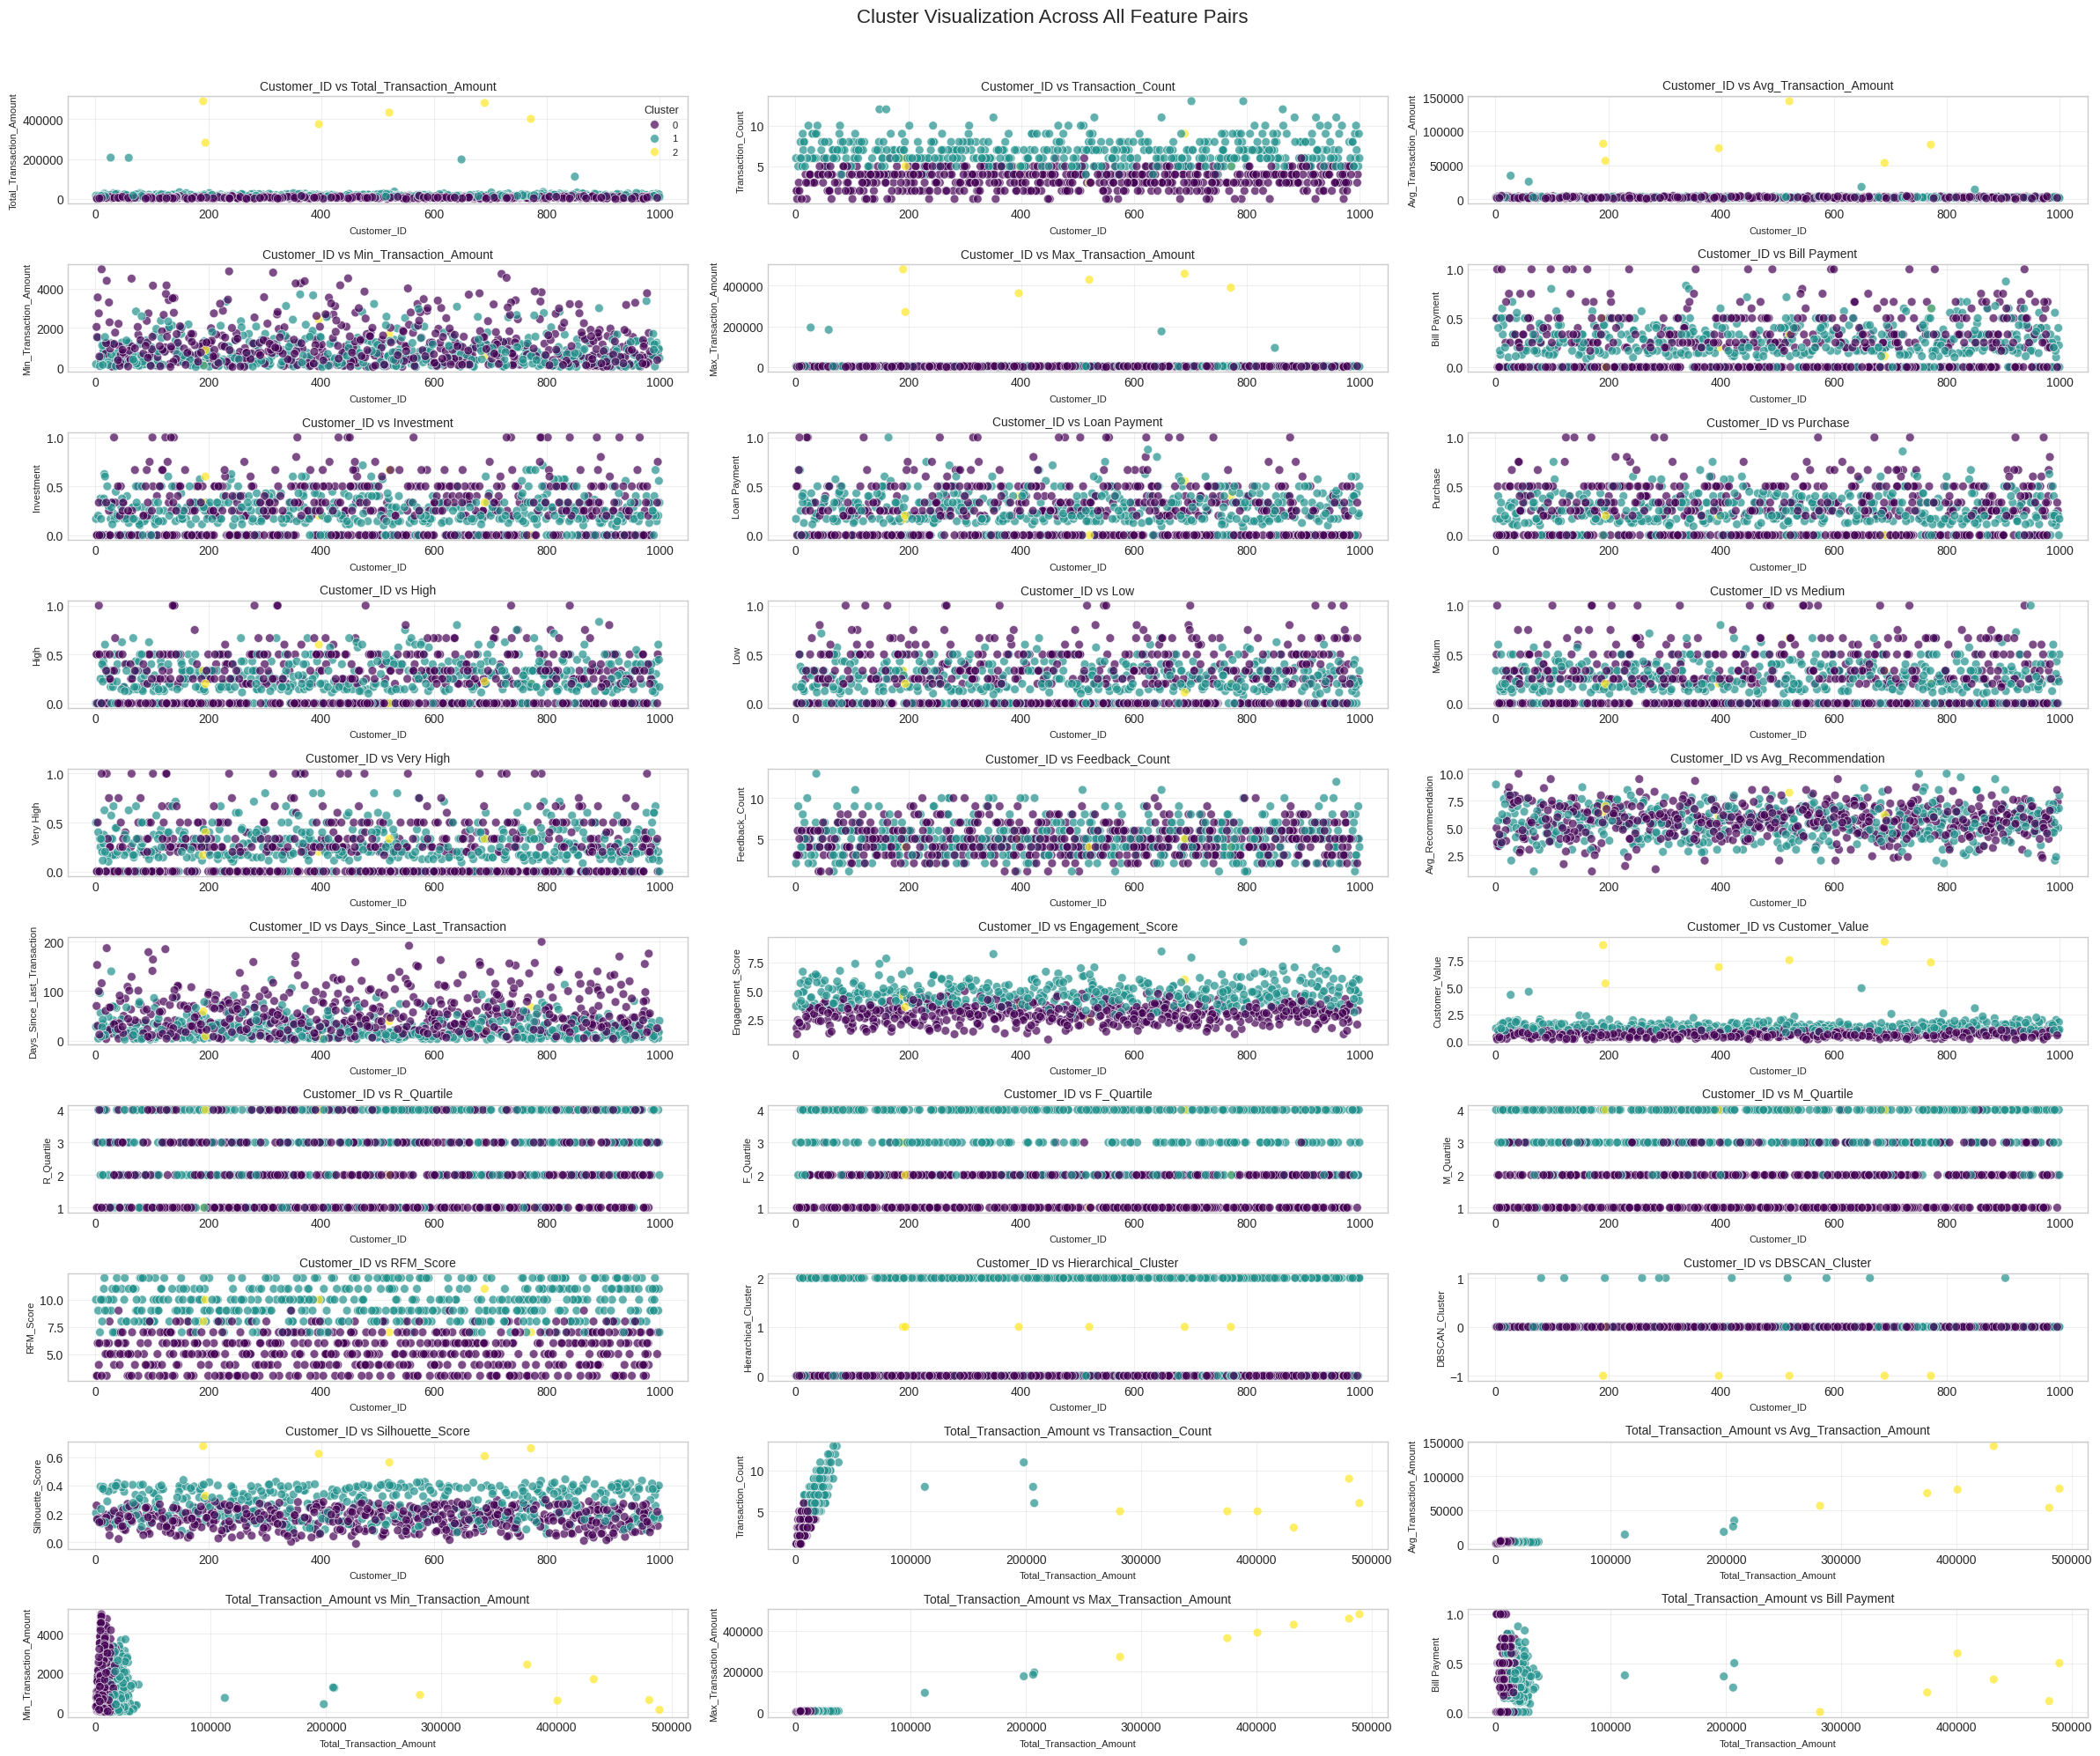

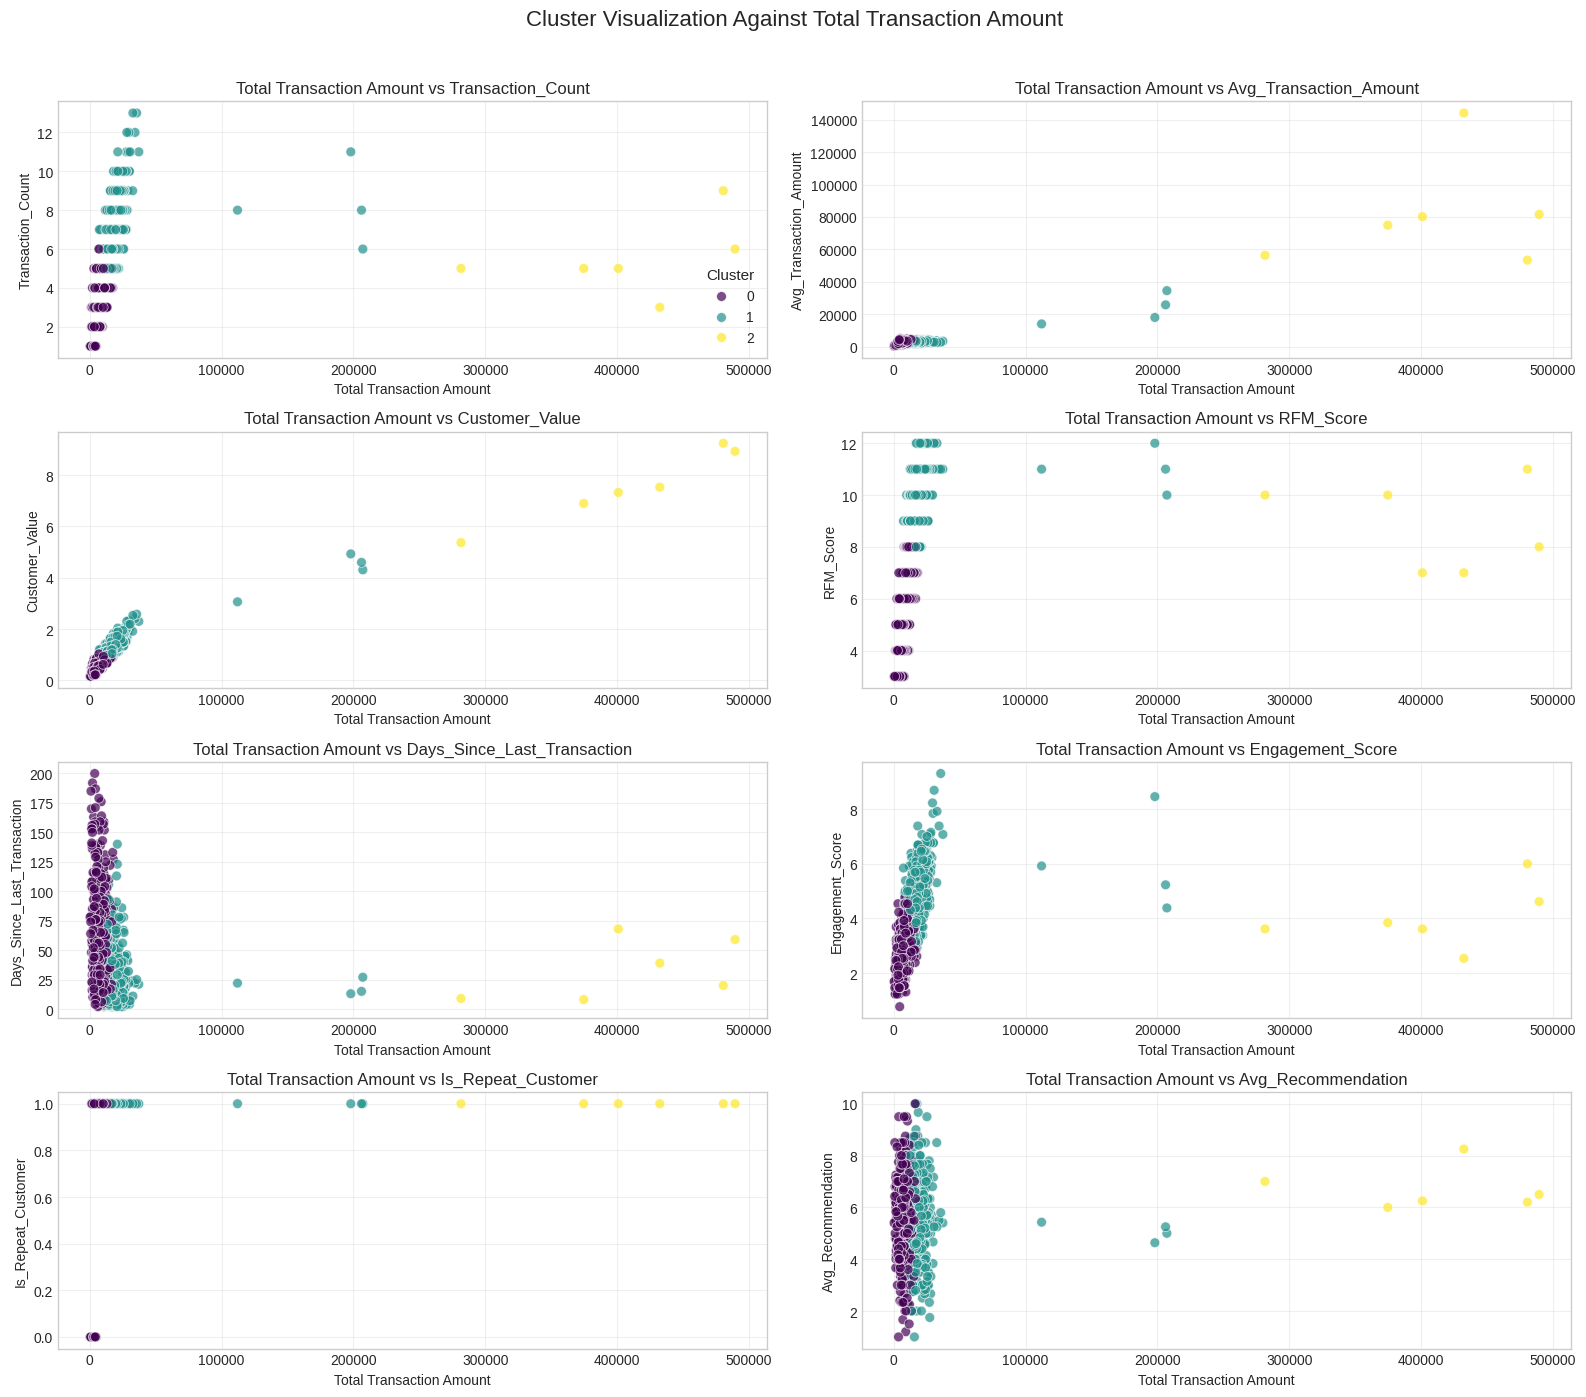

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from itertools import combinations
import math

def plot_all_feature_pairs(df, features=None, cluster_col='Cluster',
                           figsize=(20, 20), max_plots=None,
                           save_path=None, max_cols=3):
    """
    Create scatter plots for all pairs of features showing cluster assignments.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the features and cluster assignments
    features : list or None
        List of feature names to include in the plots
        If None, all numeric columns except the cluster column are used
    cluster_col : str
        Name of the column containing cluster assignments
    figsize : tuple
        Figure size for the entire grid of subplots
    max_plots : int or None
        Maximum number of plots to create. If None, all pairs are plotted
    save_path : str or None
        Path to save the figure (if None, figure won't be saved)
    max_cols : int
        Maximum number of columns in the grid

    Returns:
    --------
    matplotlib.figure.Figure
        The plot figure
    """
    # If no features specified, use all numeric columns except the cluster column
    if features is None:
        # Select only numeric columns
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        # Exclude the cluster column
        features = [col for col in numeric_cols if col != cluster_col]

    # Get all pairs of features
    feature_pairs = list(combinations(features, 2))

    # Limit number of plots if specified
    if max_plots and max_plots < len(feature_pairs):
        feature_pairs = feature_pairs[:max_plots]

    # Calculate grid dimensions
    n_plots = len(feature_pairs)
    n_cols = min(max_cols, n_plots)
    n_rows = math.ceil(n_plots / n_cols)

    # Create figure and axes grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Flatten axes array for easier indexing
    if n_rows > 1 or n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Get unique clusters
    clusters = sorted(df[cluster_col].unique())

    # Custom color palette
    colors = ['#440154', '#21918c', '#fde725']

    # Create a palette that maps cluster values to colors
    palette = {}
    for i, cluster in enumerate(clusters):
        if i < len(colors):
            palette[cluster] = colors[i]

    # Plot each feature pair
    for i, (feature_x, feature_y) in enumerate(feature_pairs):
        if i < len(axes):  # Ensure we don't exceed the number of axes
            ax = axes[i]

            # Create scatter plot
            sns.scatterplot(
                x=feature_x,
                y=feature_y,
                hue=cluster_col,
                data=df,
                palette=palette,
                alpha=0.7,
                s=50,
                ax=ax
            )

            # Configure axis
            ax.set_title(f'{feature_x} vs {feature_y}', fontsize=10)
            ax.set_xlabel(feature_x, fontsize=8)
            ax.set_ylabel(feature_y, fontsize=8)
            ax.grid(True, alpha=0.3)

            # Adjust legend
            handles, labels = ax.get_legend_handles_labels()
            if i == 0:  # Only keep legend on the first plot
                ax.legend(title='Cluster', fontsize=8, title_fontsize=9)
            else:
                ax.legend().remove()

    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Add an overall title
    plt.suptitle(f'Cluster Visualization Across All Feature Pairs', fontsize=16, y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    return fig, axes

def plot_selected_features(df, selected_features, cluster_col='Cluster',
                          figsize=(18, 15), save_path=None):
    """
    Create scatter plots for selected key features showing cluster assignments.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the features and cluster assignments
    selected_features : list
        List of important feature names to include in the plots
    cluster_col : str
        Name of the column containing cluster assignments
    figsize : tuple
        Figure size for the entire figure
    save_path : str or None
        Path to save the figure (if None, figure won't be saved)

    Returns:
    --------
    matplotlib.figure.Figure
        The plot figure
    """
    # Calculate grid dimensions
    n_features = len(selected_features)
    n_cols = 2
    n_rows = math.ceil(n_features / n_cols)

    # Create figure and axes grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Flatten axes array for easier indexing
    if n_rows > 1 or n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Get unique clusters
    clusters = sorted(df[cluster_col].unique())

    # Custom color palette
    colors = ['#440154', '#21918c', '#fde725']

    # Create a palette that maps cluster values to colors
    palette = {}
    for i, cluster in enumerate(clusters):
        if i < len(colors):
            palette[cluster] = colors[i]

    # Plot each feature against transaction amount
    for i, feature in enumerate(selected_features):
        if i < len(axes):  # Ensure we don't exceed the number of axes
            ax = axes[i]

            # Create scatter plot
            sns.scatterplot(
                x='Total_Transaction_Amount',
                y=feature,
                hue=cluster_col,
                data=df,
                palette=palette,
                alpha=0.7,
                s=50,
                ax=ax
            )

            # Configure axis
            ax.set_title(f'Total Transaction Amount vs {feature}', fontsize=12)
            ax.set_xlabel('Total Transaction Amount', fontsize=10)
            ax.set_ylabel(feature, fontsize=10)
            ax.grid(True, alpha=0.3)

            # Adjust legend
            handles, labels = ax.get_legend_handles_labels()
            if i == 0:  # Only keep legend on the first plot
                ax.legend(title='Cluster', fontsize=10, title_fontsize=11)
            else:
                ax.legend().remove()

    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Add an overall title
    plt.suptitle(f'Cluster Visualization Against Total Transaction Amount', fontsize=16, y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    return fig, axes

# Example usage 1: Plot all feature pairs (might be a large grid)
# This will create scatter plots for all combinations of features
fig, axes = plot_all_feature_pairs(
    customer_features,
    cluster_col='Cluster',
    figsize=(24, 20),  # Adjust based on number of features
    max_plots=30,      # Limit to first 30 feature pairs
    save_path='all_feature_pairs.png'
)
plt.show()

# Example usage 2: Plot only selected important features against total transaction amount
key_features = [
    'Transaction_Count',
    'Avg_Transaction_Amount',
    'Customer_Value',
    'RFM_Score',
    'Days_Since_Last_Transaction',
    'Engagement_Score',
    'Is_Repeat_Customer',
    'Avg_Recommendation'
]

fig, axes = plot_selected_features(
    customer_features,
    key_features,
    cluster_col='Cluster',
    figsize=(16, 14),
    save_path='key_features_vs_transaction_amount.png'
)
plt.show()

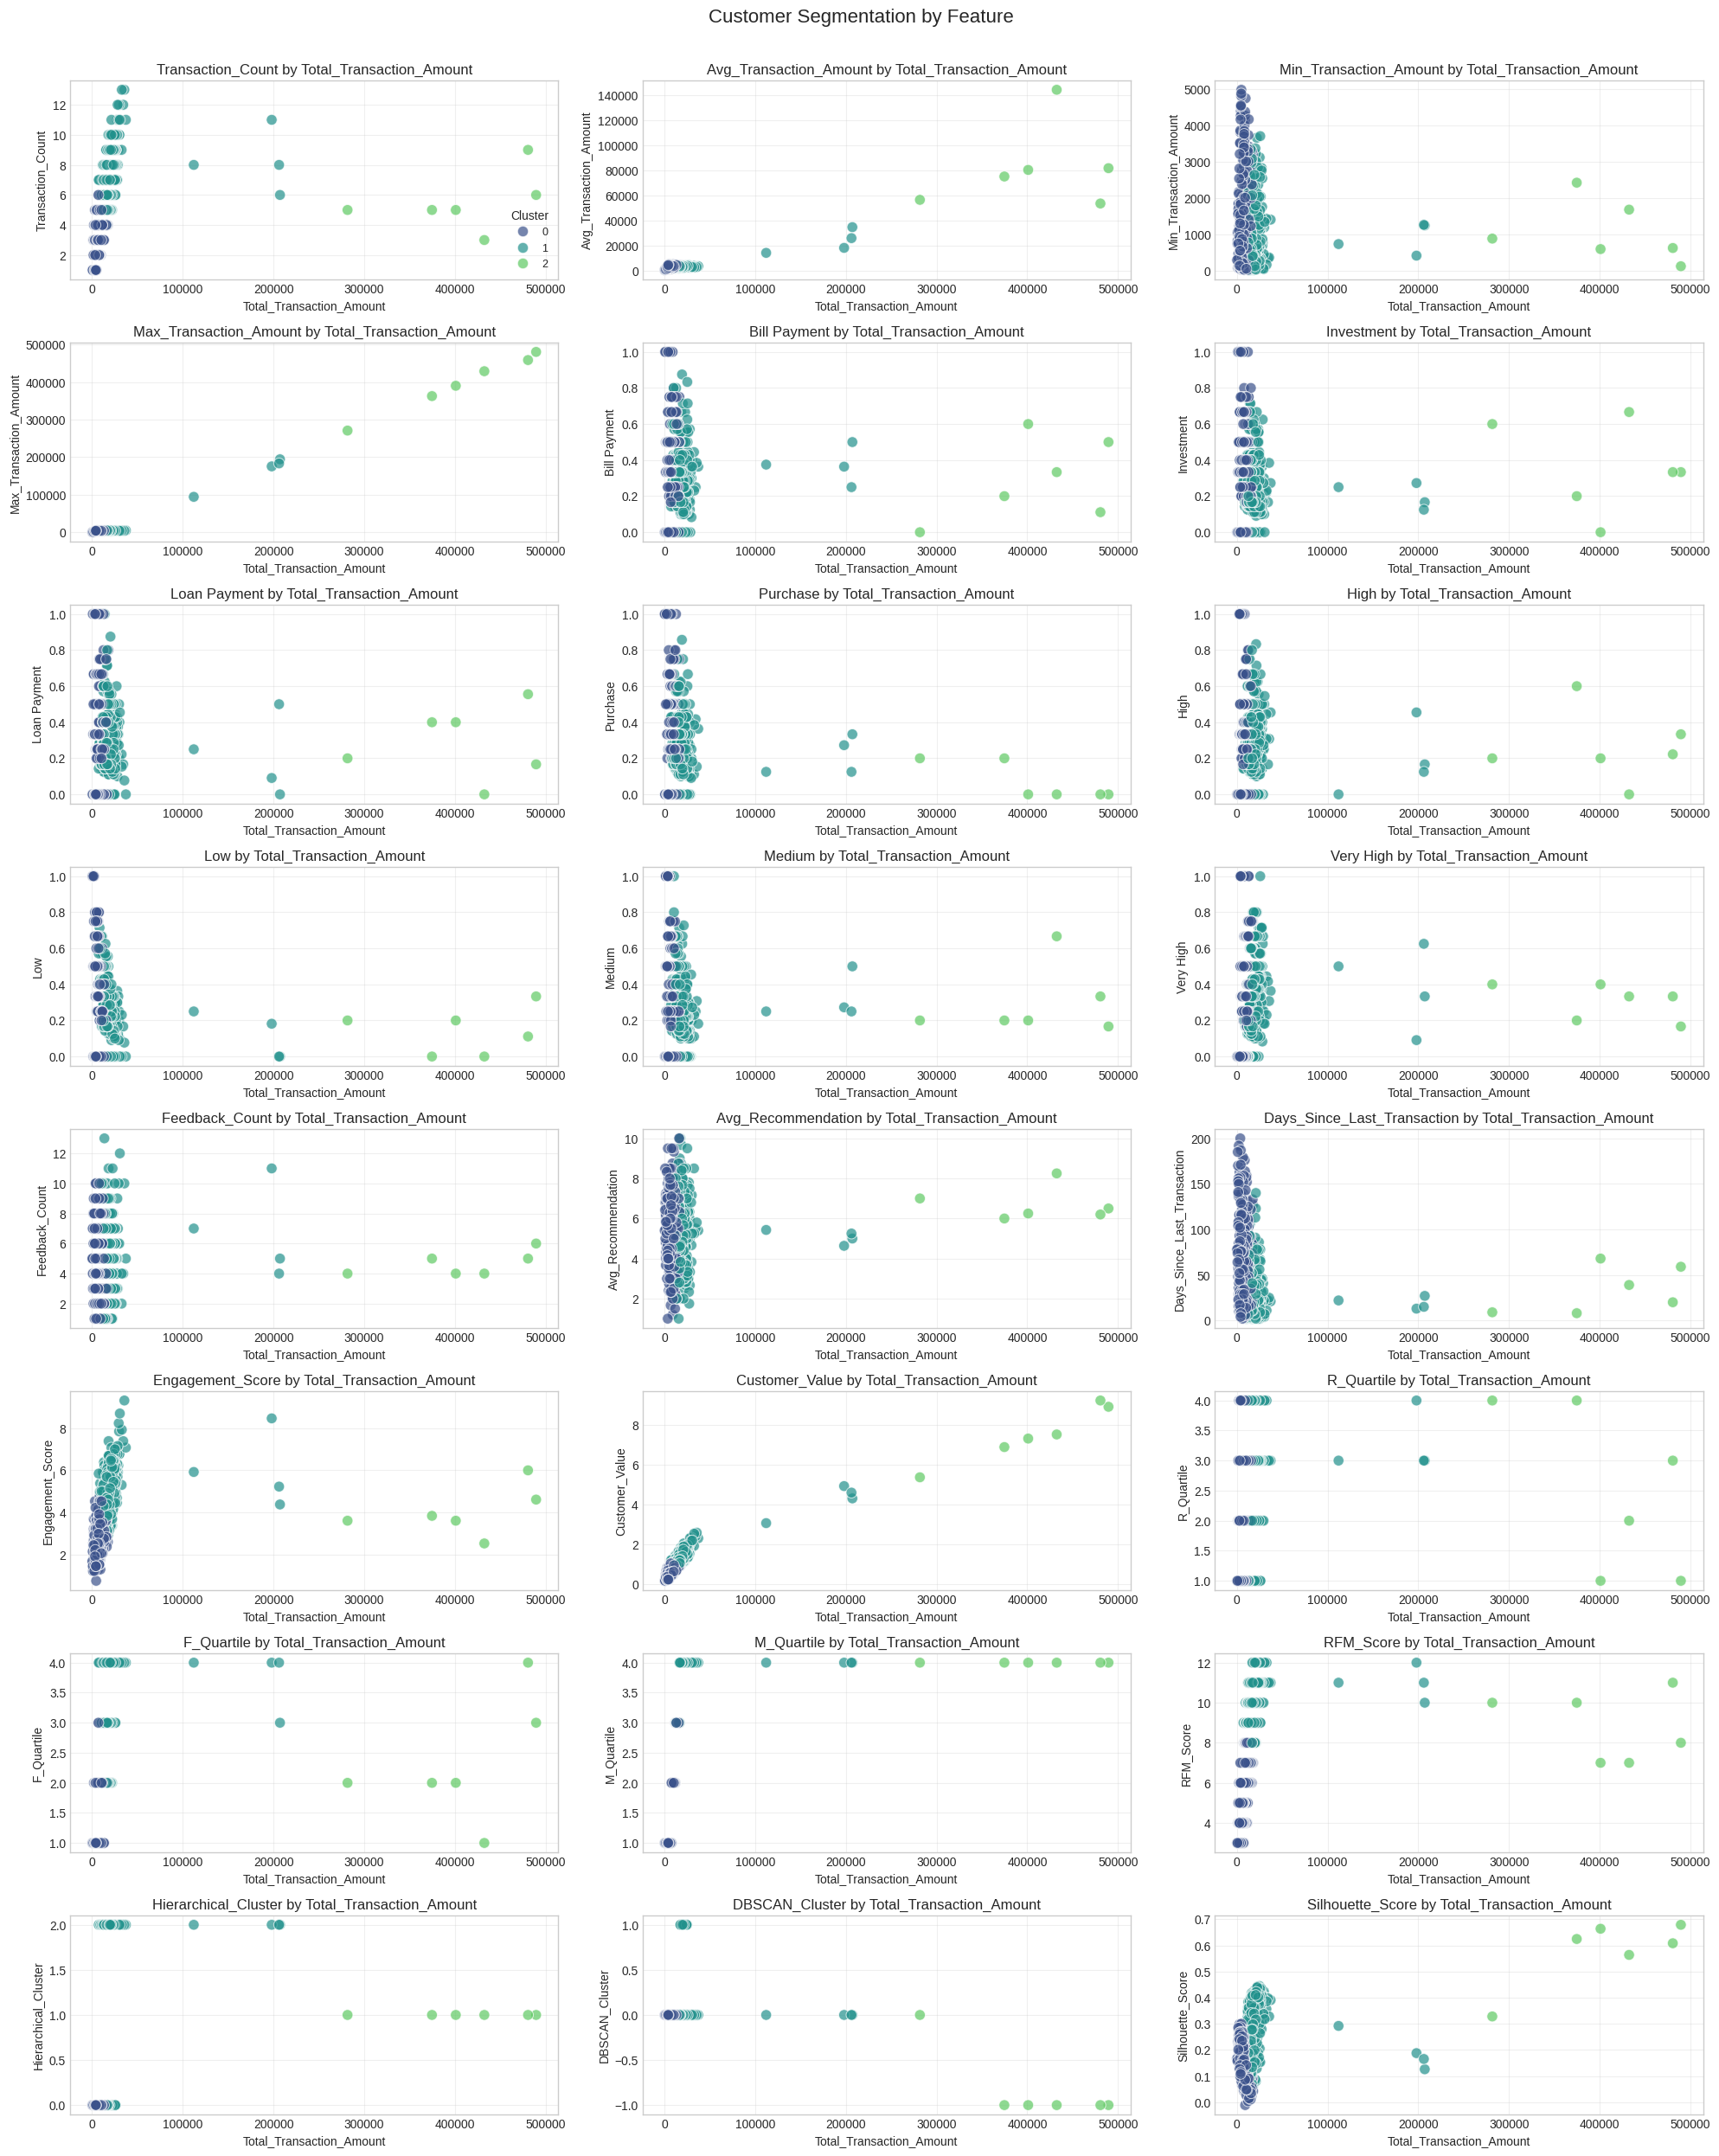

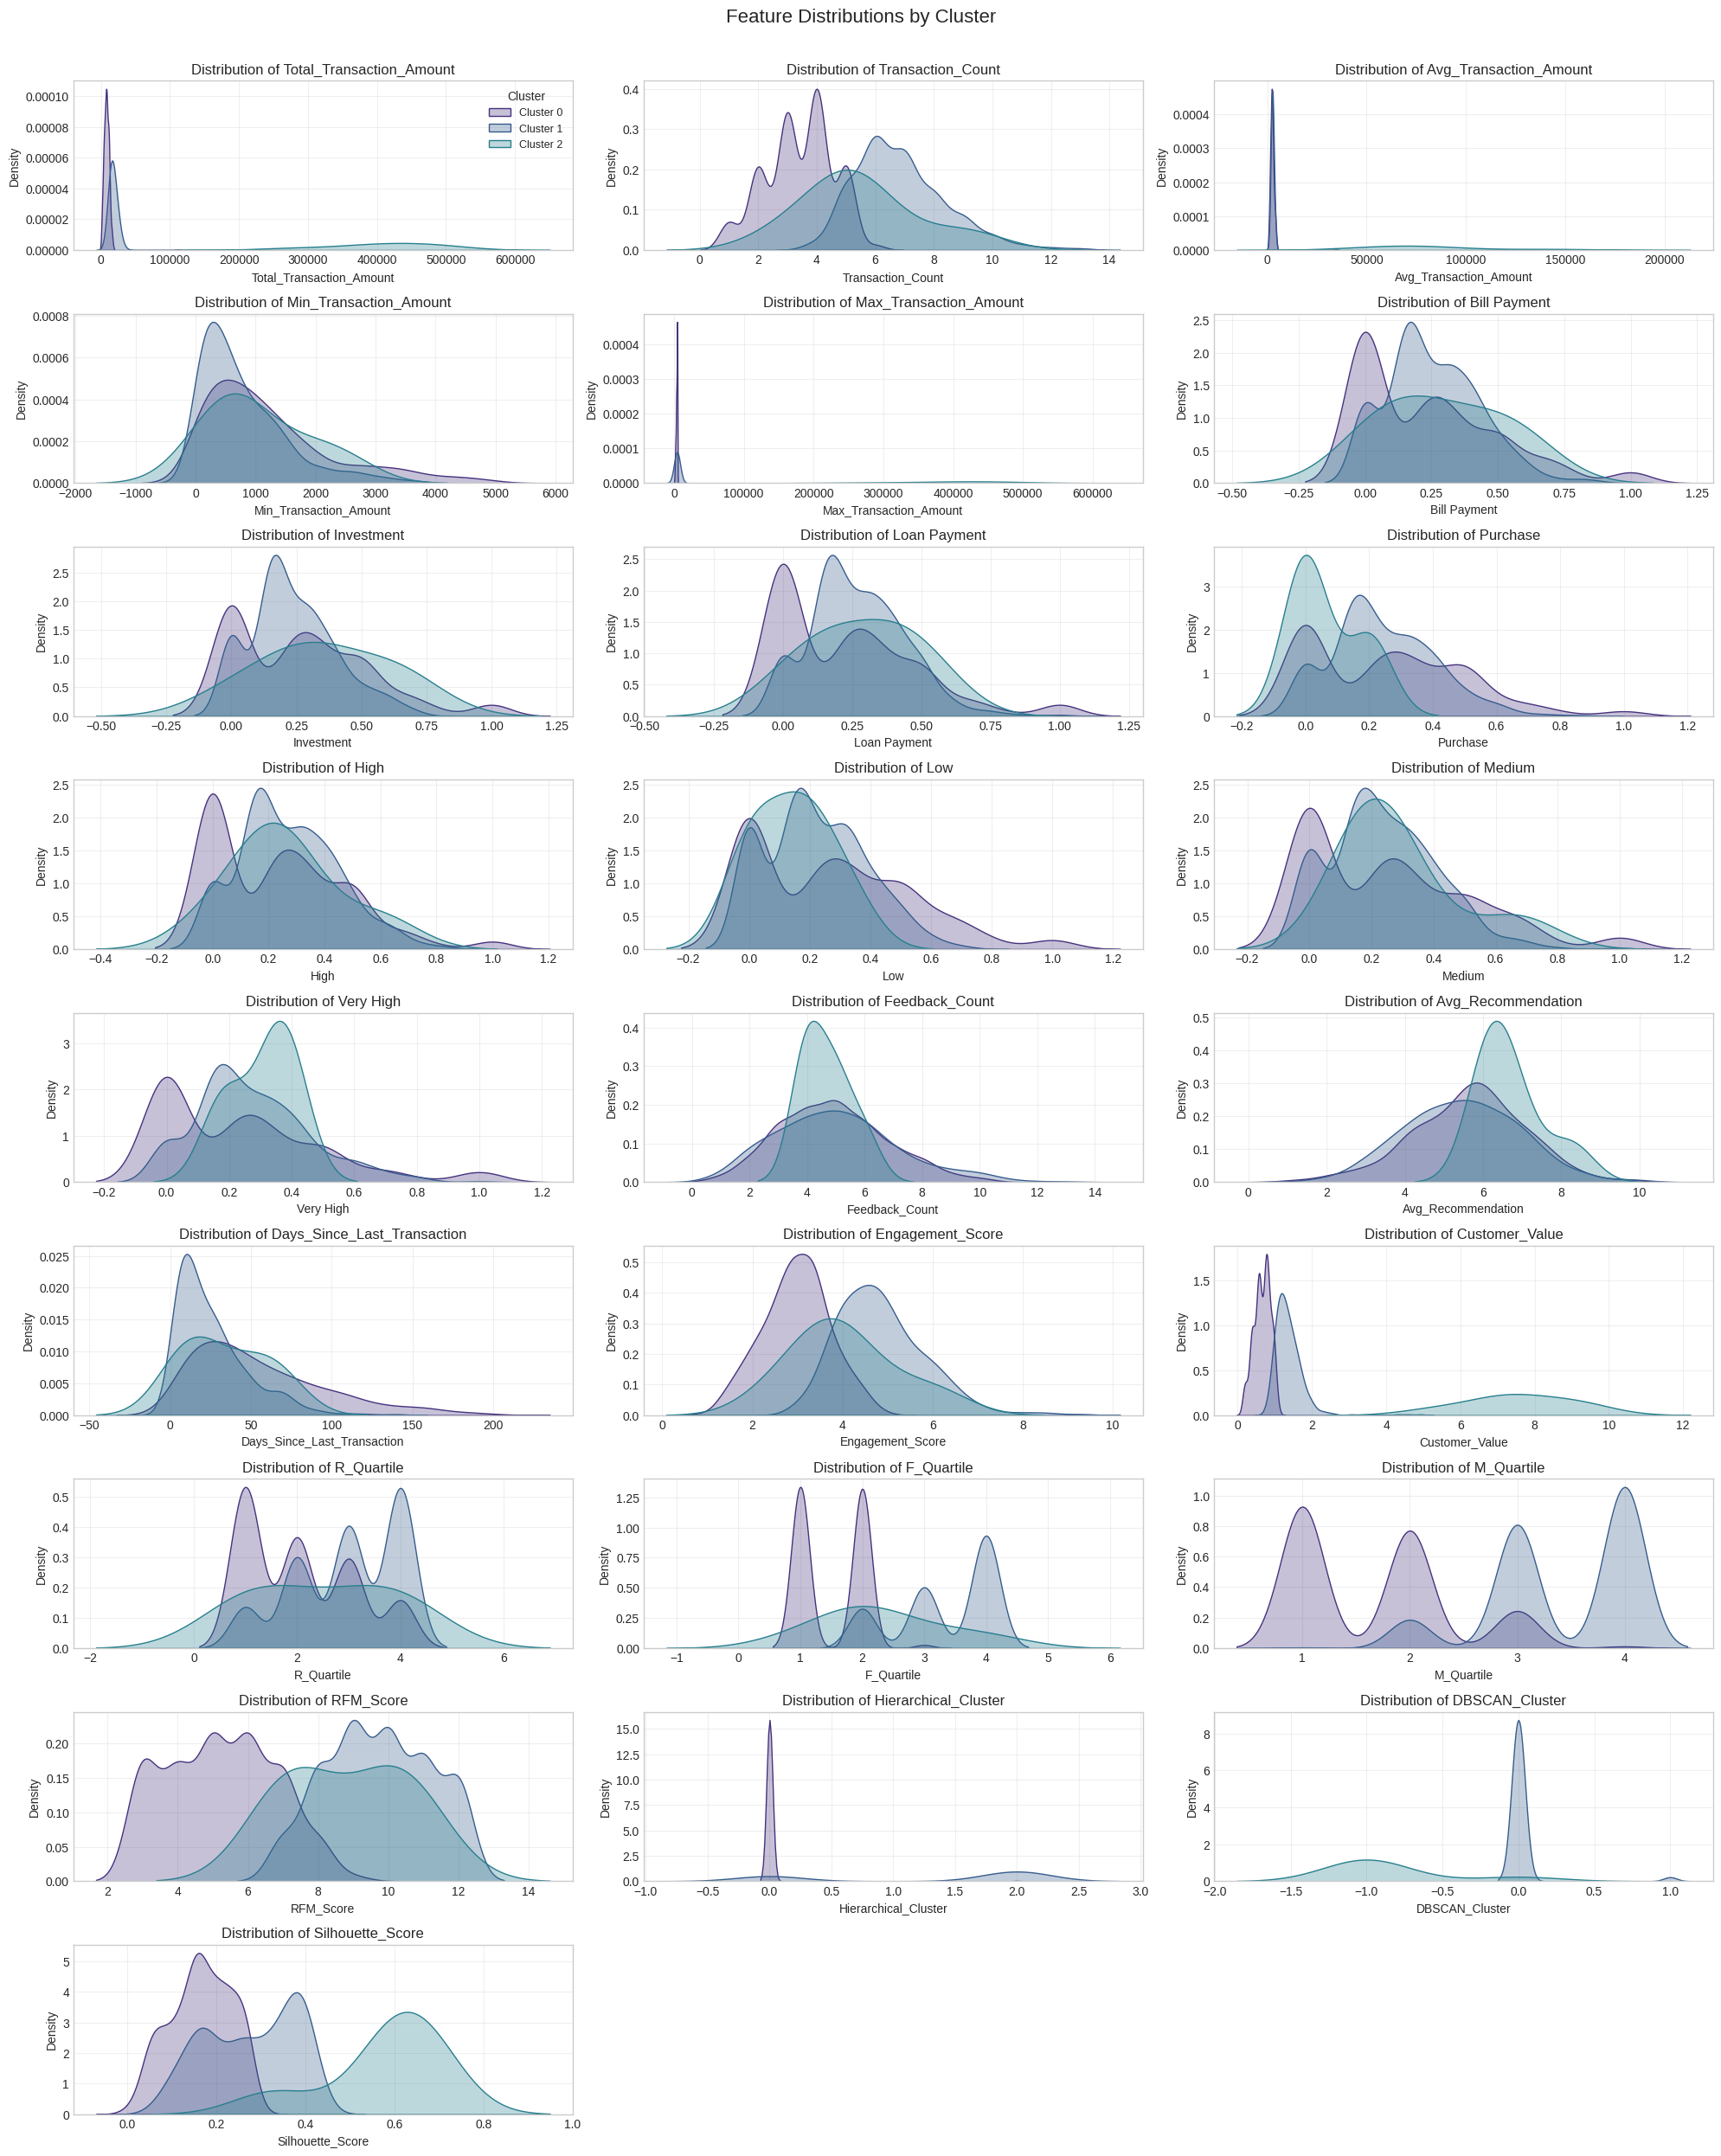

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import math

def visualize_all_features(df, cluster_col='Cluster', reference_feature='Total_Transaction_Amount',
                          ignore_cols=['Customer_ID'], figsize=(20, 25), n_cols=3,
                          alpha=0.7, marker_size=80, save_path=None):
    """
    Create scatter plots for all numeric features showing cluster segmentation.
    Each feature will be plotted against a reference feature (typically Total_Transaction_Amount).

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the features and cluster assignments
    cluster_col : str
        Name of the column containing cluster assignments
    reference_feature : str
        Feature to use on the x-axis for all plots (typically a key metric)
    ignore_cols : list
        Columns to exclude from the plots
    figsize : tuple
        Figure size for the entire grid of subplots
    n_cols : int
        Number of columns in the grid layout
    alpha : float
        Transparency of points
    marker_size : int
        Size of scatter plot points
    save_path : str or None
        Path to save the figure (if None, figure won't be saved)

    Returns:
    --------
    matplotlib.figure.Figure
        The plot figure
    """
    # Get all numeric features (excluding ignored columns and the cluster column)
    features = df.select_dtypes(include=['number']).columns.tolist()
    features = [f for f in features if f not in ignore_cols + [cluster_col, reference_feature]]

    # Calculate grid dimensions
    n_features = len(features)
    n_rows = math.ceil(n_features / n_cols)

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Flatten axes for easier indexing
    if n_rows > 1 or n_cols > 1:
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes]

    # Get unique clusters
    clusters = sorted(df[cluster_col].unique())

    # Custom color palette
    palette = sns.color_palette('viridis', len(clusters))

    # Create color dictionary for mapping cluster values to colors
    color_map = {}
    for i, cluster in enumerate(clusters):
        color_map[cluster] = palette[i]

    # Create plots for each feature
    for i, feature in enumerate(features):
        if i < len(axes_flat):  # Ensure we don't exceed the number of axes
            ax = axes_flat[i]

            # Create scatter plot
            sns.scatterplot(
                x=reference_feature,
                y=feature,
                hue=cluster_col,
                data=df,
                palette=color_map,
                alpha=alpha,
                s=marker_size,
                ax=ax
            )

            # Set title and labels
            ax.set_title(f'{feature} by {reference_feature}', fontsize=12)
            ax.set_xlabel(reference_feature, fontsize=10)
            ax.set_ylabel(feature, fontsize=10)
            ax.grid(True, alpha=0.3)

            # Legend only on the first plot
            if i == 0:
                ax.legend(title='Cluster', fontsize=9, title_fontsize=10)
            else:
                ax.legend().remove()

    # Turn off any unused subplots
    for j in range(n_features, len(axes_flat)):
        axes_flat[j].axis('off')

    # Add overall title
    plt.suptitle('Customer Segmentation by Feature', fontsize=16, y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])

    # Save if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    return fig, axes

def create_feature_distributions(df, cluster_col='Cluster', ignore_cols=['Customer_ID'],
                                figsize=(20, 25), n_cols=3, save_path=None):
    """
    Create distribution plots for each feature, colored by cluster.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the features and cluster assignments
    cluster_col : str
        Name of the column containing cluster assignments
    ignore_cols : list
        Columns to exclude from the plots
    figsize : tuple
        Figure size for the entire grid of subplots
    n_cols : int
        Number of columns in the grid layout
    save_path : str or None
        Path to save the figure (if None, figure won't be saved)

    Returns:
    --------
    matplotlib.figure.Figure
        The plot figure
    """
    # Get all numeric features (excluding ignored columns and the cluster column)
    features = df.select_dtypes(include=['number']).columns.tolist()
    features = [f for f in features if f not in ignore_cols + [cluster_col]]

    # Calculate grid dimensions
    n_features = len(features)
    n_rows = math.ceil(n_features / n_cols)

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Flatten axes for easier indexing
    if n_rows > 1 or n_cols > 1:
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes]

    # Get unique clusters
    clusters = sorted(df[cluster_col].unique())

    # Create plots for each feature
    for i, feature in enumerate(features):
        if i < len(axes_flat):  # Ensure we don't exceed the number of axes
            ax = axes_flat[i]

            # Create kde plot for each cluster
            for cluster in clusters:
                cluster_data = df[df[cluster_col] == cluster]
                sns.kdeplot(
                    data=cluster_data,
                    x=feature,
                    fill=True,
                    alpha=0.3,
                    ax=ax,
                    label=f'Cluster {cluster}'
                )

            # Set title and labels
            ax.set_title(f'Distribution of {feature}', fontsize=12)
            ax.set_xlabel(feature, fontsize=10)
            ax.set_ylabel('Density', fontsize=10)
            ax.grid(True, alpha=0.3)

            # Legend only on the first plot
            if i == 0:
                ax.legend(title='Cluster', fontsize=9, title_fontsize=10)
            else:
                ax.legend().remove()

    # Turn off any unused subplots
    for j in range(n_features, len(axes_flat)):
        axes_flat[j].axis('off')

    # Add overall title
    plt.suptitle('Feature Distributions by Cluster', fontsize=16, y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])

    # Save if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    return fig, axes

# Example usage:
# --------------

# Assuming 'customer_features' is your DataFrame with the data and 'Cluster' column
# has the cluster assignments

# Create scatter plots for all features against Total_Transaction_Amount
fig, axes = visualize_all_features(
    customer_features,
    cluster_col='Cluster',
    reference_feature='Total_Transaction_Amount',
    ignore_cols=['Customer_ID'],
    figsize=(20, 25),
    save_path='all_features_segmentation.png'
)
plt.show()

# Create distribution plots for all features by cluster
fig, axes = create_feature_distributions(
    customer_features,
    cluster_col='Cluster',
    ignore_cols=['Customer_ID'],
    figsize=(20, 25),
    save_path='feature_distributions_by_cluster.png'
)
plt.show()

In [35]:
# Display first 5 rows of the dataset
print(customer_features.head())


   Customer_ID  Total_Transaction_Amount  Transaction_Count  \
0          393              22365.000000                  7   
1          826               8182.422663                  3   
2          916              18406.000000                  9   
3          109               7492.000000                  5   
4          889               6348.834015                  3   

   Avg_Transaction_Amount  Min_Transaction_Amount  Max_Transaction_Amount  \
0             3195.000000                  1535.0             4968.000000   
1             2727.474221                   323.0             4123.000000   
2             2045.111111                    10.0             4616.000000   
3             1498.400000                    72.0             4549.000000   
4             2116.278005                  1531.0             3024.834015   

   Bill Payment  Investment  Loan Payment  Purchase  ...  Engagement_Score  \
0      0.428571    0.428571      0.000000  0.142857  ...          4.000000   
1 

Top 5 Features Contributing to PC1:
                        PC1   PC1_abs
Transaction_Count  0.413426  0.413426
M_Quartile         0.397116  0.397116
F_Quartile         0.397014  0.397014
Engagement_Score   0.394583  0.394583
Customer_Value     0.385298  0.385298

Top 5 Features Contributing to PC2:
                                  PC2   PC2_abs
Avg_Transaction_Amount       0.576849  0.576849
Total_Transaction_Amount     0.529332  0.529332
Customer_Value               0.322216  0.322216
Days_Since_Last_Transaction  0.228316  0.228316
R_Quartile                  -0.224362  0.224362


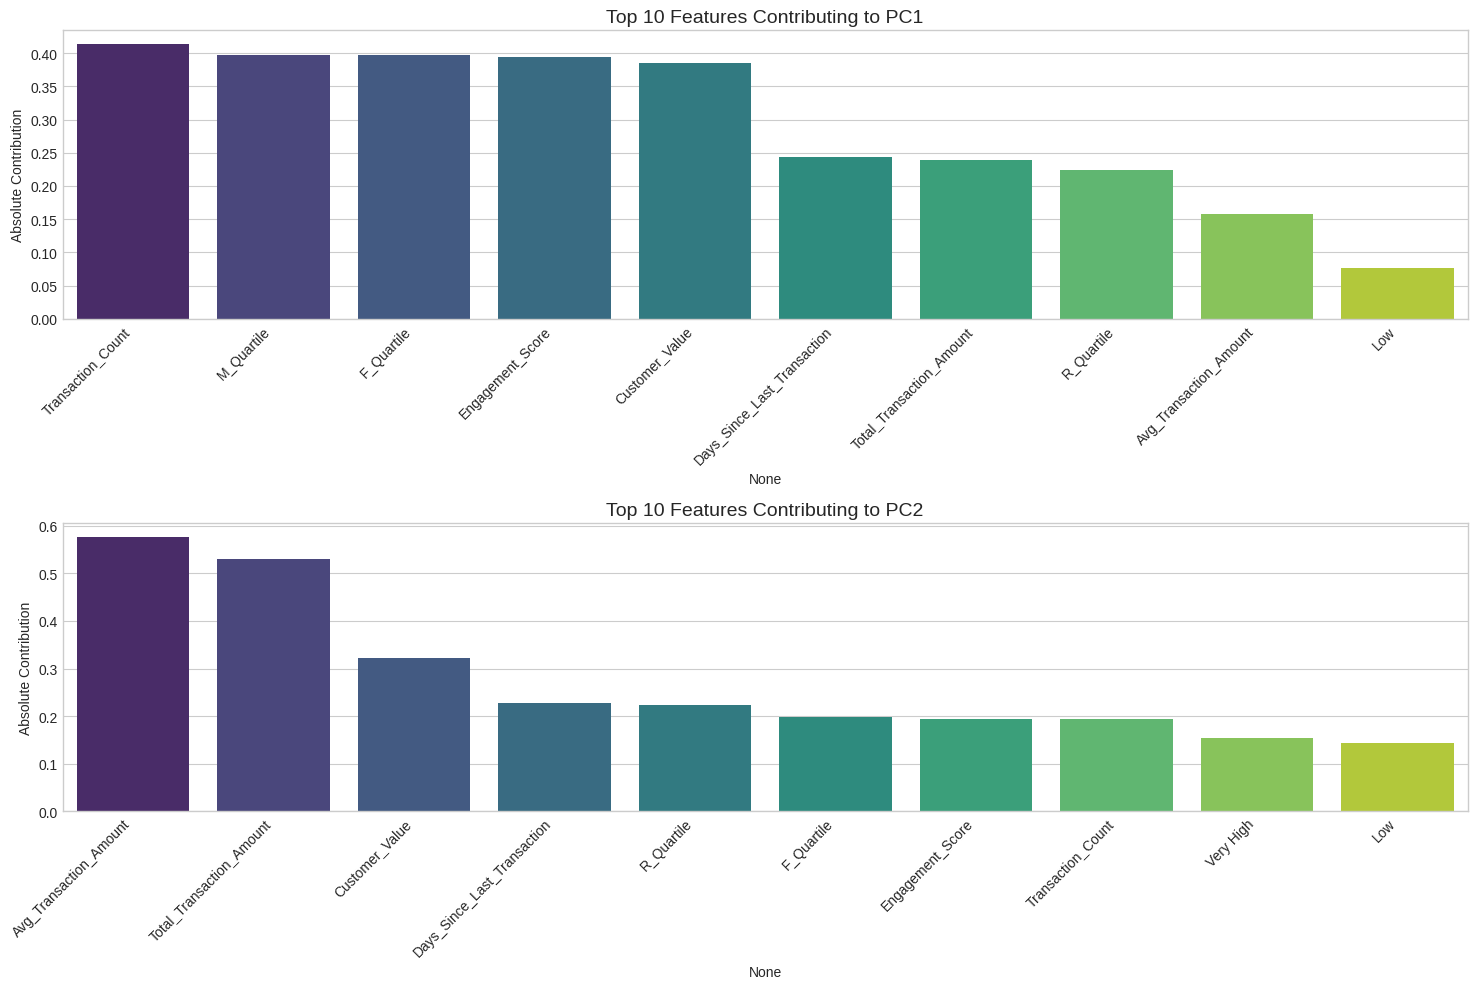

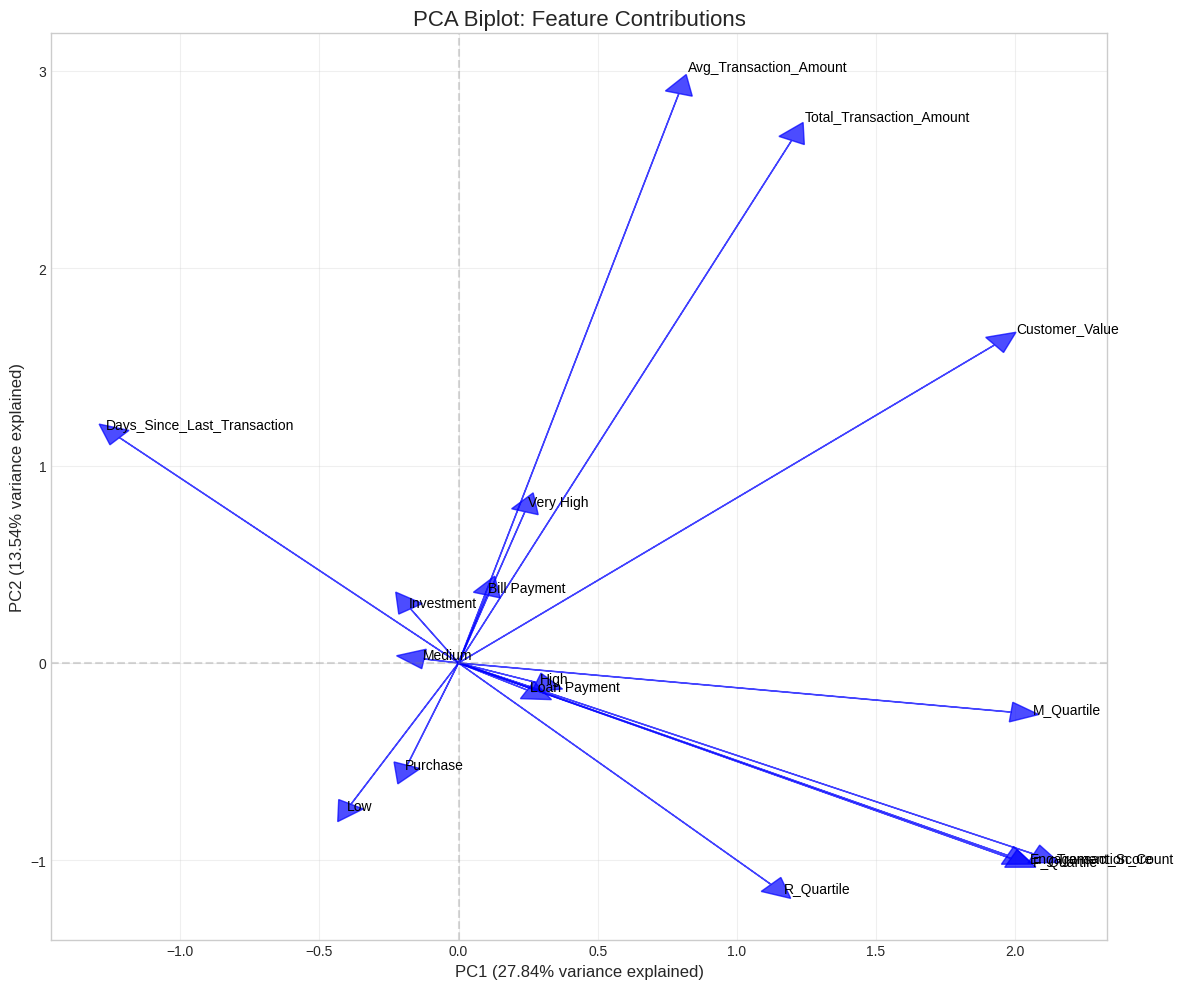


Key Feature Values for Each Cluster Centroid (Original Feature Space):


Total_Transaction_Amount  Transaction_Count  \
Cluster 0                  0.306258           0.984320   
Cluster 1                 -0.275907          -0.805841   
Cluster 2                 -0.152788          -0.542444   

           Avg_Transaction_Amount  Bill Payment  Investment  Loan Payment  \
Cluster 0                0.134609      0.026980   -0.010299      0.057421   
Cluster 1               -0.162738     -0.329743    0.806365     -0.417388   
Cluster 2               -0.040826      0.180455   -0.500914      0.203502   

           Purchase       Low    Medium      High  Very High  \
Cluster 0 -0.078389 -0.082492 -0.015728  0.055459   0.044109   
Cluster 1 -0.063880  0.933426 -0.178485 -0.408753  -0.349345   
Cluster 2  0.124499 -0.504274  0.130159  0.200120   0.174557   

           Days_Since_Last_Transaction  Engagement_Score  Customer_Value  \
Cluster 0                    -0.425616          0.931991        0.710695   
Cluster 1                     0.461753         -0.717460       -0.601561   
Cluster 2                     0.162611         -0.542518       -0.379127   

           R_Quartile  F_Quartile  M_Quartile  
Cluster 0    0.415090    1.056910    0.907931  
Cluster 1   -0.393595   -0.858428   -1.059636  
Cluster 2   -0.194612   -0.586790   -0.299514

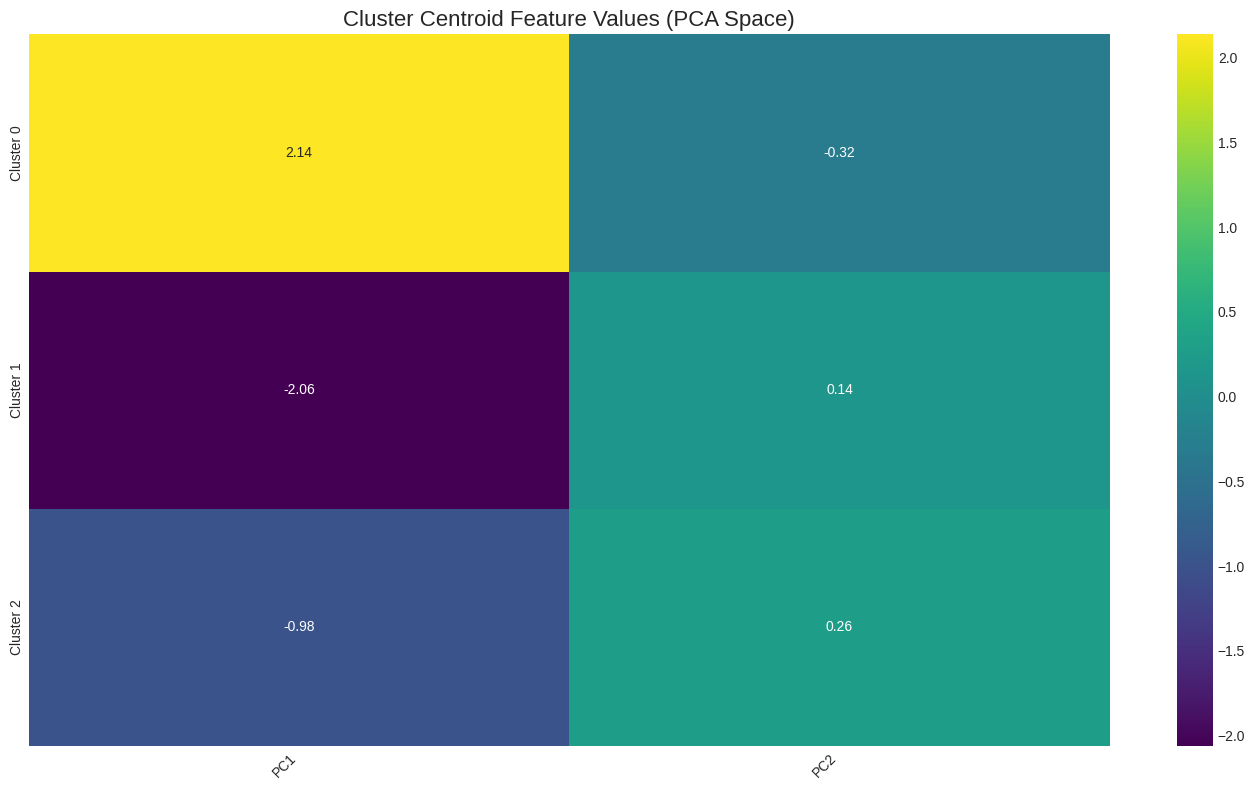

Top features for PC1: ['Transaction_Count', 'M_Quartile', 'F_Quartile', 'Engagement_Score', 'Customer_Value']
Top features for PC2: ['Avg_Transaction_Amount', 'Total_Transaction_Amount', 'Customer_Value', 'Days_Since_Last_Transaction', 'R_Quartile']


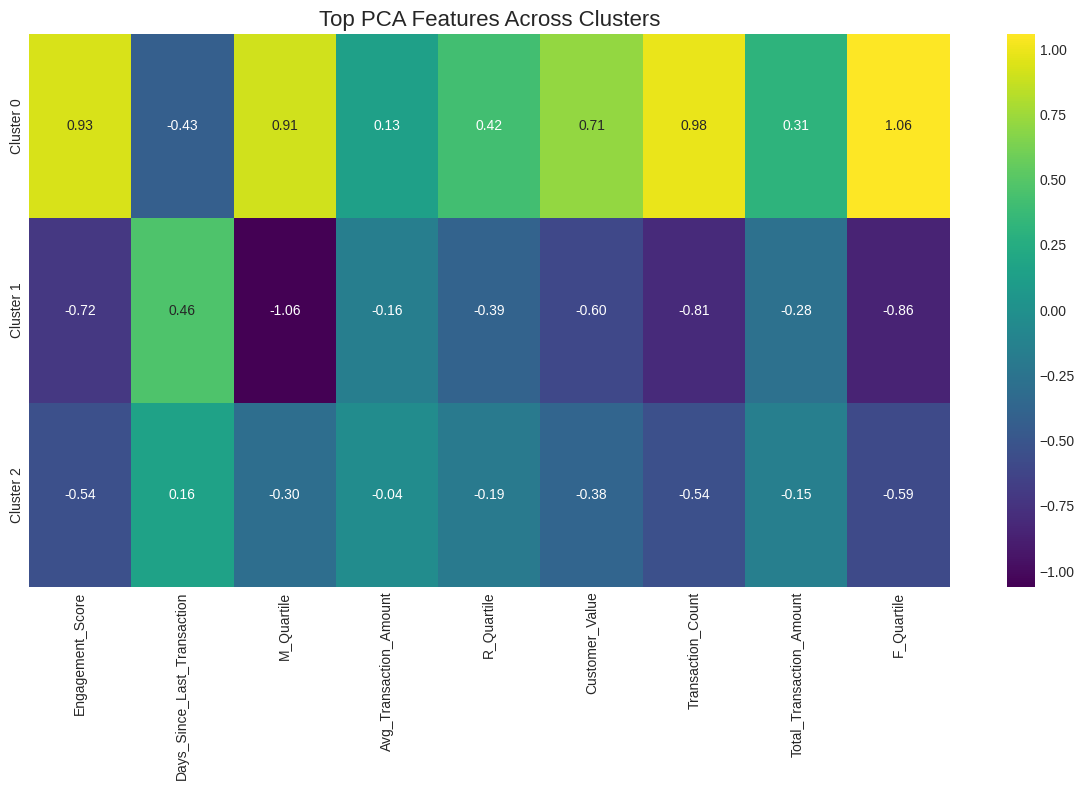

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Function to analyze which features contribute most to PCA components
def analyze_pca_contributions(data_matrix, feature_names):
    """
    Analyze and visualize the contribution of each feature to PCA components

    Parameters:
    data_matrix: The standardized data matrix used for clustering
    feature_names: List of feature names corresponding to columns in data_matrix

    Returns:
    pca: The fitted PCA object
    feature_contributions: DataFrame with feature contributions to each component
    """
    # Fit PCA with 2 components (as used in the visualization)
    pca = PCA(n_components=2)
    pca.fit(data_matrix)

    # Get the loadings (feature weights for each component)
    loadings = pca.components_

    # Create a DataFrame to store the loadings
    feature_contributions = pd.DataFrame(
        data=loadings.T,  # Transpose to get features as rows
        columns=['PC1', 'PC2'],
        index=feature_names
    )

    # Add absolute values for ranking importance
    feature_contributions['PC1_abs'] = np.abs(feature_contributions['PC1'])
    feature_contributions['PC2_abs'] = np.abs(feature_contributions['PC2'])

    # Sort by importance for each component
    pc1_importance = feature_contributions.sort_values('PC1_abs', ascending=False)
    pc2_importance = feature_contributions.sort_values('PC2_abs', ascending=False)

    # Print top contributors
    print("Top 5 Features Contributing to PC1:")
    print(pc1_importance[['PC1', 'PC1_abs']].head(5))
    print("\nTop 5 Features Contributing to PC2:")
    print(pc2_importance[['PC2', 'PC2_abs']].head(5))

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # Plot PC1 feature importance
    plt.subplot(2, 1, 1)
    sns.barplot(x=pc1_importance.index[:10], y=pc1_importance['PC1_abs'][:10], palette='viridis')
    plt.title('Top 10 Features Contributing to PC1', fontsize=14)
    plt.ylabel('Absolute Contribution')
    plt.xticks(rotation=45, ha='right')

    # Plot PC2 feature importance
    plt.subplot(2, 1, 2)
    sns.barplot(x=pc2_importance.index[:10], y=pc2_importance['PC2_abs'][:10], palette='viridis')
    plt.title('Top 10 Features Contributing to PC2', fontsize=14)
    plt.ylabel('Absolute Contribution')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    # Create a biplot
    plt.figure(figsize=(12, 10))

    # Calculate the variance explained for labeling
    var_explained = pca.explained_variance_ratio_

    # Plot the principal components
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

    # Add feature vectors
    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0, loadings[0, i]*5, loadings[1, i]*5,
                 head_width=0.1, head_length=0.1, fc='blue', ec='blue', alpha=0.7)
        plt.text(loadings[0, i]*5.2, loadings[1, i]*5.2, feature,
                color='black', fontsize=10)

    plt.xlabel(f'PC1 ({var_explained[0]:.2%} variance explained)', fontsize=12)
    plt.ylabel(f'PC2 ({var_explained[1]:.2%} variance explained)', fontsize=12)
    plt.title('PCA Biplot: Feature Contributions', fontsize=16)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return pca, feature_contributions

# Function to analyze how each cluster's centroid relates to the important features
def analyze_cluster_centroids(centroids, feature_names, pca, top_n=5):
    """
    Analyze how each cluster's centroid values compare for the most important features

    Parameters:
    centroids: The cluster centroids in original feature space
    feature_names: List of feature names corresponding to centroid dimensions
    pca: The PCA object that was used to reduce dimensions
    top_n: Number of top features to analyze per cluster

    Returns:
    centroid_df: DataFrame with feature values for each cluster centroid
    """

    # Create a DataFrame for the centroids in the original feature space
    centroid_df = pd.DataFrame(
        data=centroids,
        columns=feature_names  # Use all feature names as columns
    )

    # Rename rows to cluster names
    centroid_df.index = [f'Cluster {i}' for i in range(centroid_df.shape[0])]

    # Print key feature values for each centroid
    print("\nKey Feature Values for Each Cluster Centroid (Original Feature Space):")
    display(centroid_df)

    # Project centroids to PCA space for visualization
    centroids_pca = pca.transform(centroids)  # Transform centroids to PCA space

    # Create a DataFrame for centroids in PCA space
    centroid_df_pca = pd.DataFrame(data=centroids_pca, columns=['PC1', 'PC2'])
    centroid_df_pca.index = [f'Cluster {i}' for i in range(centroid_df_pca.shape[0])]

    # Create a heatmap to visualize feature importance across clusters (PCA space)
    plt.figure(figsize=(14, 8))
    sns.heatmap(centroid_df_pca, cmap='viridis', annot=True, fmt='.2f')  # Use PCA centroids here
    plt.title('Cluster Centroid Feature Values (PCA Space)', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return centroid_df # Return the DataFrame with original features

# Main function to execute PCA and KMeans clustering
def main(customer_features, clustering_features):
    # 1. Standardize the data
    features = customer_features[clustering_features]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(features)

    # 2. Perform PCA and analyze contributions of features
    pca, feature_contributions = analyze_pca_contributions(scaled_data, clustering_features)

    # 3. Perform KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(scaled_data)

    # 4. Analyze cluster centroids in PCA space
    centroid_analysis = analyze_cluster_centroids(kmeans.cluster_centers_, clustering_features, pca)

    # 5. Identify the top contributing features for PC1 and PC2
    top_pc1_features = feature_contributions.sort_values('PC1_abs', ascending=False).index[:5].tolist()
    top_pc2_features = feature_contributions.sort_values('PC2_abs', ascending=False).index[:5].tolist()

    print("Top features for PC1:", top_pc1_features)
    print("Top features for PC2:", top_pc2_features)

    # 6. Create a focused heatmap for just the top PCA features
    top_features = list(set(top_pc1_features + top_pc2_features))
    plt.figure(figsize=(12, 8))
    sns.heatmap(centroid_analysis[top_features], cmap='viridis', annot=True, fmt='.2f')
    plt.title('Top PCA Features Across Clusters', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:

# Define your features for clustering (Make sure you have these columns in customer_features)
clustering_features = [
    'Total_Transaction_Amount', 'Transaction_Count', 'Avg_Transaction_Amount',
    'Bill Payment', 'Investment', 'Loan Payment', 'Purchase',  # Transaction type percentages
    'Low', 'Medium', 'High', 'Very High',  # Transaction amount categories
    'Days_Since_Last_Transaction', 'Engagement_Score', 'Customer_Value',
    'R_Quartile', 'F_Quartile', 'M_Quartile'
]

# Assuming customer_features is your DataFrame containing the data
main(customer_features, clustering_features)


Top 5 Features Contributing to PC1:
                        PC1   PC1_abs
Transaction_Count  0.413426  0.413426
M_Quartile         0.397116  0.397116
F_Quartile         0.397014  0.397014
Engagement_Score   0.394583  0.394583
Customer_Value     0.385298  0.385298

Top 5 Features Contributing to PC2:
                                  PC2   PC2_abs
Avg_Transaction_Amount       0.576849  0.576849
Total_Transaction_Amount     0.529332  0.529332
Customer_Value               0.322216  0.322216
Days_Since_Last_Transaction  0.228316  0.228316
R_Quartile                  -0.224362  0.224362


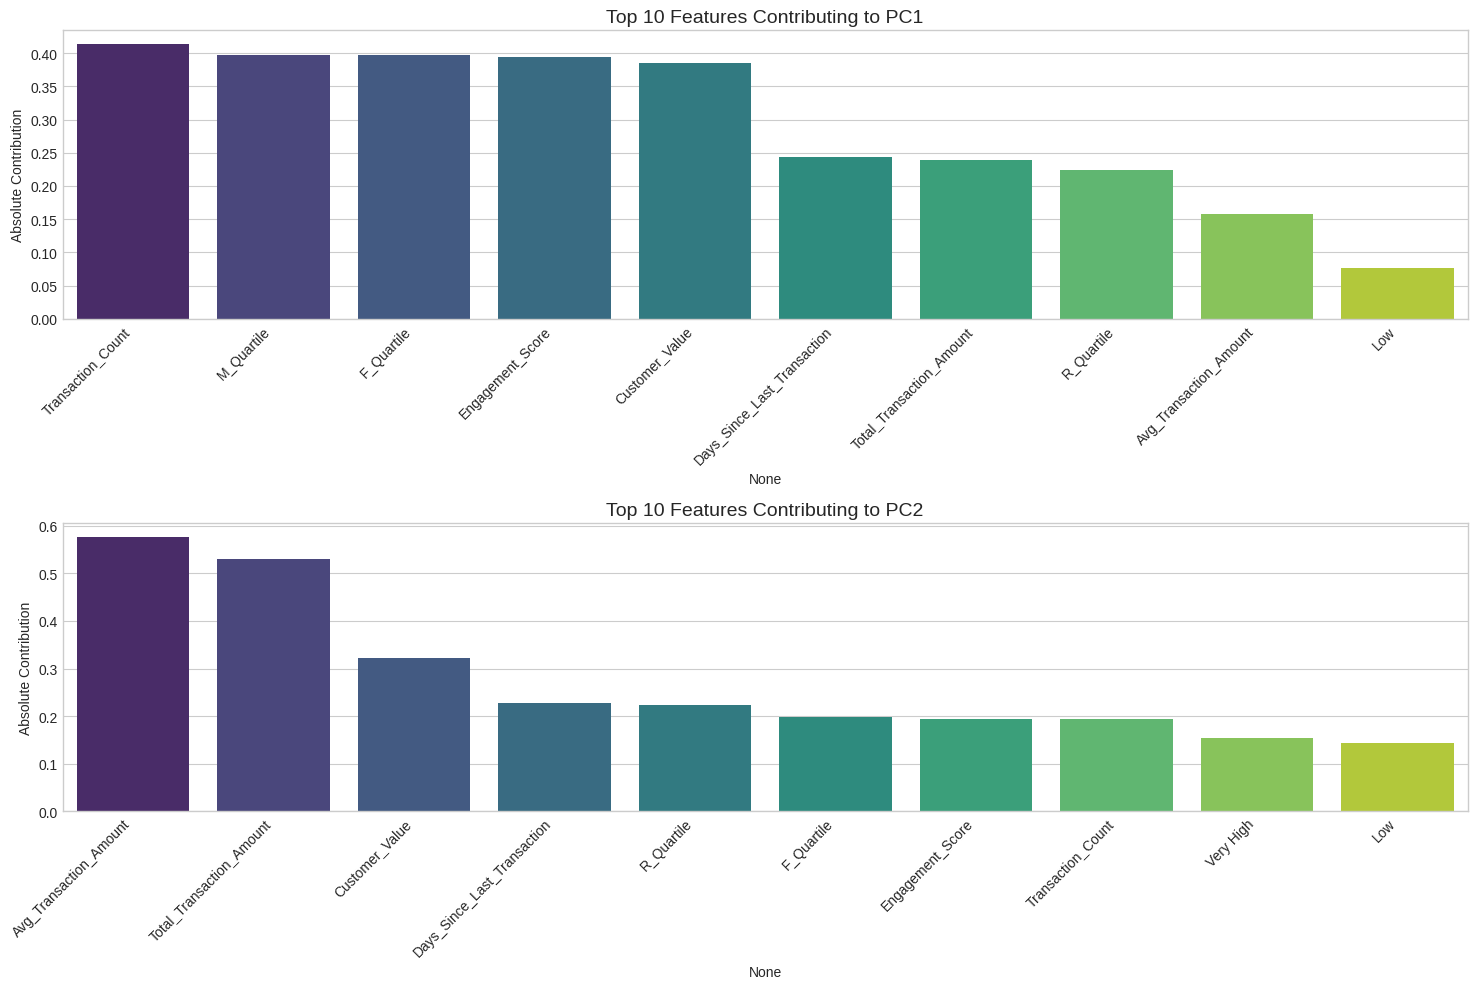

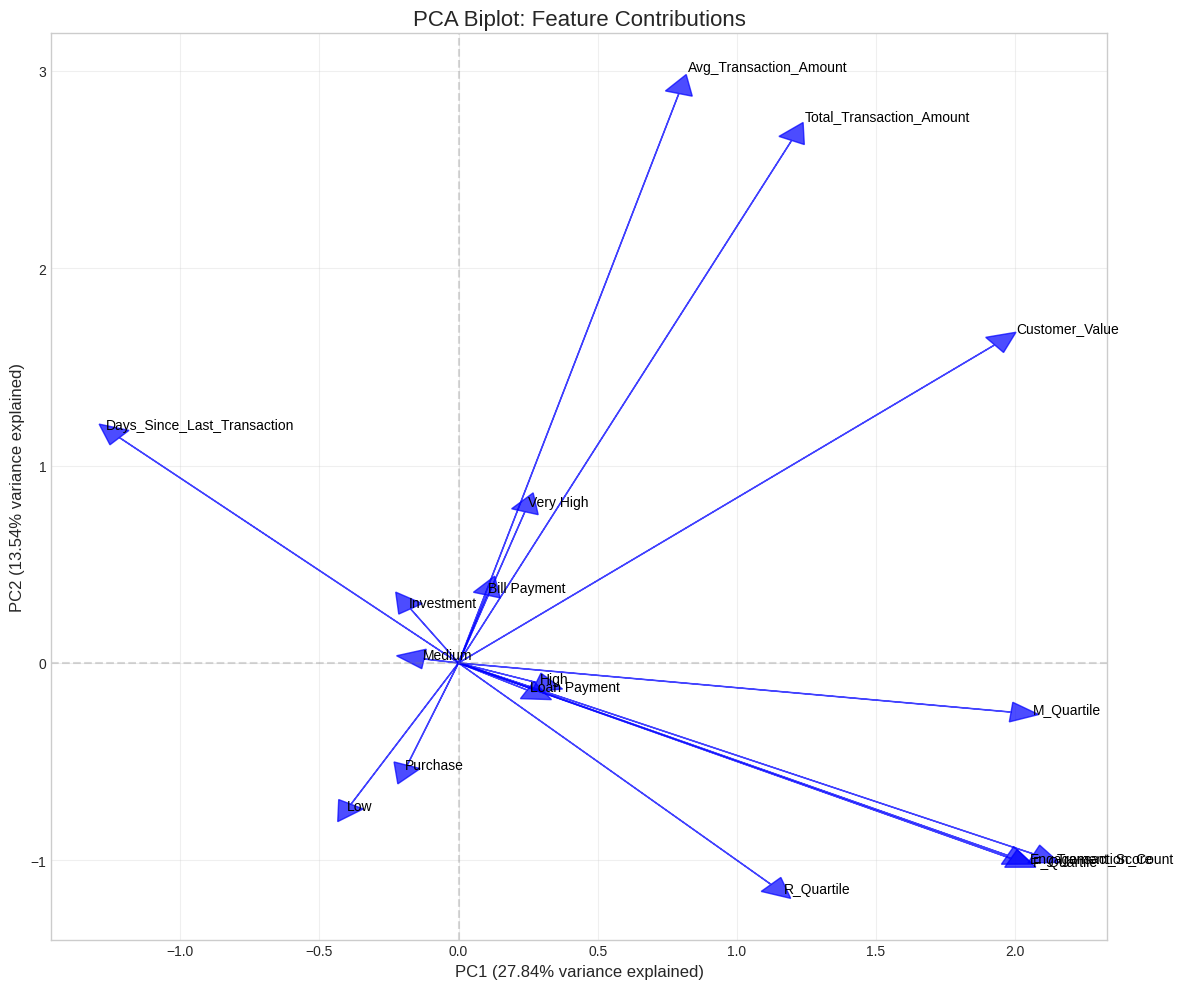


Key Feature Values for Each Cluster Centroid (Original Feature Space):


Total_Transaction_Amount  Transaction_Count  \
Cluster 0                  0.306258           0.984320   
Cluster 1                 -0.275907          -0.805841   
Cluster 2                 -0.152788          -0.542444   

           Avg_Transaction_Amount  Bill Payment  Investment  Loan Payment  \
Cluster 0                0.134609      0.026980   -0.010299      0.057421   
Cluster 1               -0.162738     -0.329743    0.806365     -0.417388   
Cluster 2               -0.040826      0.180455   -0.500914      0.203502   

           Purchase       Low    Medium      High  Very High  \
Cluster 0 -0.078389 -0.082492 -0.015728  0.055459   0.044109   
Cluster 1 -0.063880  0.933426 -0.178485 -0.408753  -0.349345   
Cluster 2  0.124499 -0.504274  0.130159  0.200120   0.174557   

           Days_Since_Last_Transaction  Engagement_Score  Customer_Value  \
Cluster 0                    -0.425616          0.931991        0.710695   
Cluster 1                     0.461753         -0.717460       -0.601561   
Cluster 2                     0.162611         -0.542518       -0.379127   

           R_Quartile  F_Quartile  M_Quartile  
Cluster 0    0.415090    1.056910    0.907931  
Cluster 1   -0.393595   -0.858428   -1.059636  
Cluster 2   -0.194612   -0.586790   -0.299514

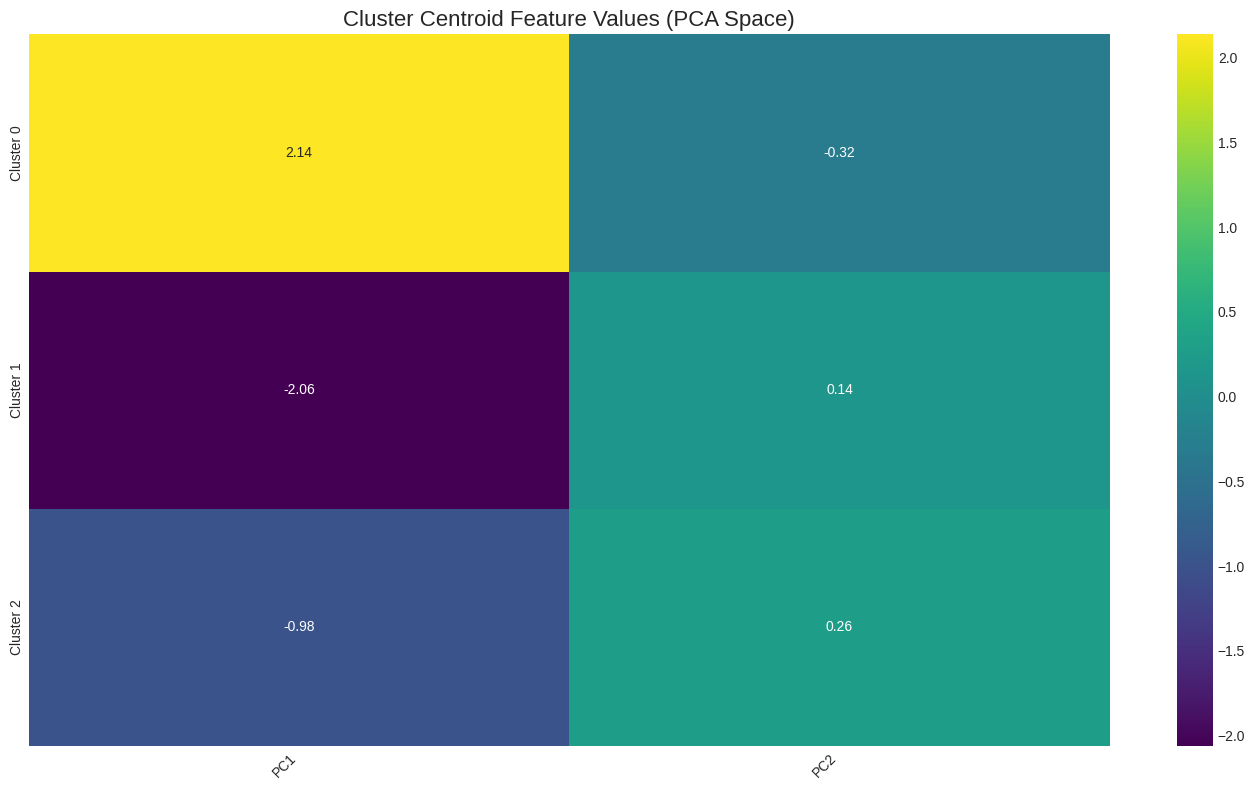

Top features for PC1: ['Transaction_Count', 'M_Quartile', 'F_Quartile', 'Engagement_Score', 'Customer_Value']
Top features for PC2: ['Avg_Transaction_Amount', 'Total_Transaction_Amount', 'Customer_Value', 'Days_Since_Last_Transaction', 'R_Quartile']


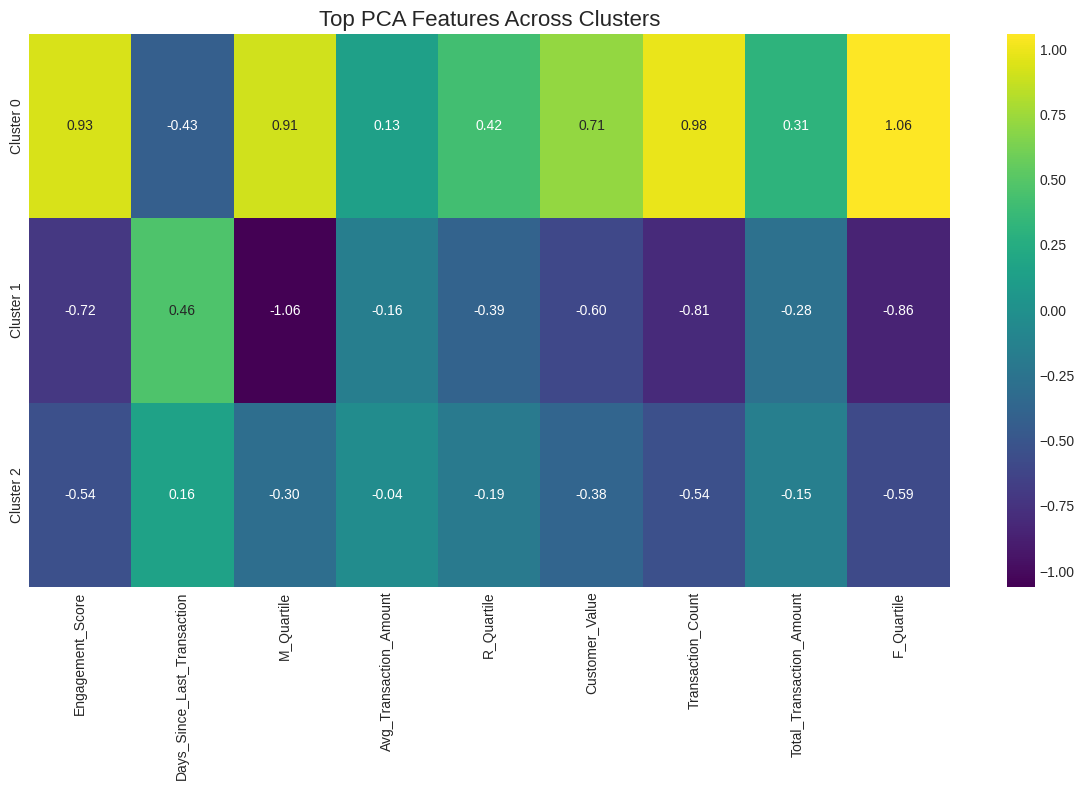

Explained Variance Ratio for each component:
PC1: 27.84%
PC2: 13.54%
Cumulative Explained Variance: 41.39%


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Function to analyze which features contribute most to PCA components
def analyze_pca_contributions(data_matrix, feature_names):
    """
    Analyze and visualize the contribution of each feature to PCA components

    Parameters:
    data_matrix: The standardized data matrix used for clustering
    feature_names: List of feature names corresponding to columns in data_matrix

    Returns:
    pca: The fitted PCA object
    feature_contributions: DataFrame with feature contributions to each component
    """
    # Fit PCA with 2 components (as used in the visualization)
    pca = PCA(n_components=2)
    pca.fit(data_matrix)

    # Get the loadings (feature weights for each component)
    loadings = pca.components_

    # Create a DataFrame to store the loadings
    feature_contributions = pd.DataFrame(
        data=loadings.T,  # Transpose to get features as rows
        columns=['PC1', 'PC2'],
        index=feature_names
    )

    # Add absolute values for ranking importance
    feature_contributions['PC1_abs'] = np.abs(feature_contributions['PC1'])
    feature_contributions['PC2_abs'] = np.abs(feature_contributions['PC2'])

    # Sort by importance for each component
    pc1_importance = feature_contributions.sort_values('PC1_abs', ascending=False)
    pc2_importance = feature_contributions.sort_values('PC2_abs', ascending=False)

    # Print top contributors
    print("Top 5 Features Contributing to PC1:")
    print(pc1_importance[['PC1', 'PC1_abs']].head(5))
    print("\nTop 5 Features Contributing to PC2:")
    print(pc2_importance[['PC2', 'PC2_abs']].head(5))

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # Plot PC1 feature importance
    plt.subplot(2, 1, 1)
    sns.barplot(x=pc1_importance.index[:10], y=pc1_importance['PC1_abs'][:10], palette='viridis')
    plt.title('Top 10 Features Contributing to PC1', fontsize=14)
    plt.ylabel('Absolute Contribution')
    plt.xticks(rotation=45, ha='right')

    # Plot PC2 feature importance
    plt.subplot(2, 1, 2)
    sns.barplot(x=pc2_importance.index[:10], y=pc2_importance['PC2_abs'][:10], palette='viridis')
    plt.title('Top 10 Features Contributing to PC2', fontsize=14)
    plt.ylabel('Absolute Contribution')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    # Create a biplot
    plt.figure(figsize=(12, 10))

    # Calculate the variance explained for labeling
    var_explained = pca.explained_variance_ratio_

    # Plot the principal components
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

    # Add feature vectors
    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0, loadings[0, i]*5, loadings[1, i]*5,
                 head_width=0.1, head_length=0.1, fc='blue', ec='blue', alpha=0.7)
        plt.text(loadings[0, i]*5.2, loadings[1, i]*5.2, feature,
                color='black', fontsize=10)

    plt.xlabel(f'PC1 ({var_explained[0]:.2%} variance explained)', fontsize=12)
    plt.ylabel(f'PC2 ({var_explained[1]:.2%} variance explained)', fontsize=12)
    plt.title('PCA Biplot: Feature Contributions', fontsize=16)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return pca, feature_contributions

# Function to analyze how each cluster's centroid relates to the important features
def analyze_cluster_centroids(centroids, feature_names, pca, top_n=5):
    """
    Analyze how each cluster's centroid values compare for the most important features

    Parameters:
    centroids: The cluster centroids in original feature space
    feature_names: List of feature names corresponding to centroid dimensions
    pca: The PCA object that was used to reduce dimensions
    top_n: Number of top features to analyze per cluster

    Returns:
    centroid_df: DataFrame with feature values for each cluster centroid
    """

    # Create a DataFrame for the centroids in the original feature space
    centroid_df = pd.DataFrame(
        data=centroids,
        columns=feature_names  # Use all feature names as columns
    )

    # Rename rows to cluster names
    centroid_df.index = [f'Cluster {i}' for i in range(centroid_df.shape[0])]

    # Print key feature values for each centroid
    print("\nKey Feature Values for Each Cluster Centroid (Original Feature Space):")
    display(centroid_df)

    # Project centroids to PCA space for visualization
    centroids_pca = pca.transform(centroids)  # Transform centroids to PCA space

    # Create a DataFrame for centroids in PCA space
    centroid_df_pca = pd.DataFrame(data=centroids_pca, columns=['PC1', 'PC2'])
    centroid_df_pca.index = [f'Cluster {i}' for i in range(centroid_df_pca.shape[0])]

    # Create a heatmap to visualize feature importance across clusters (PCA space)
    plt.figure(figsize=(14, 8))
    sns.heatmap(centroid_df_pca, cmap='viridis', annot=True, fmt='.2f')  # Use PCA centroids here
    plt.title('Cluster Centroid Feature Values (PCA Space)', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return centroid_df # Return the DataFrame with original features

# Main function to execute PCA and KMeans clustering
def main(customer_features, clustering_features):
    # 1. Standardize the data
    features = customer_features[clustering_features]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(features)

    # 2. Perform PCA and analyze contributions of features
    pca, feature_contributions = analyze_pca_contributions(scaled_data, clustering_features)

    # 3. Perform KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(scaled_data)

    # 4. Analyze cluster centroids in PCA space
    centroid_analysis = analyze_cluster_centroids(kmeans.cluster_centers_, clustering_features, pca)

    # 5. Identify the top contributing features for PC1 and PC2
    top_pc1_features = feature_contributions.sort_values('PC1_abs', ascending=False).index[:5].tolist()
    top_pc2_features = feature_contributions.sort_values('PC2_abs', ascending=False).index[:5].tolist()

    print("Top features for PC1:", top_pc1_features)
    print("Top features for PC2:", top_pc2_features)

    # 6. Create a focused heatmap for just the top PCA features
    top_features = list(set(top_pc1_features + top_pc2_features))
    plt.figure(figsize=(12, 8))
    sns.heatmap(centroid_analysis[top_features], cmap='viridis', annot=True, fmt='.2f')
    plt.title('Top PCA Features Across Clusters', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Calculate the explained variance ratio for each component
    explained_variance_ratio = pca.explained_variance_ratio_

    # Display the explained variance ratio for PC1 and PC2
    print("Explained Variance Ratio for each component:")
    print(f"PC1: {explained_variance_ratio[0]*100:.2f}%")
    print(f"PC2: {explained_variance_ratio[1]*100:.2f}%")

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(explained_variance_ratio)
    print(f"Cumulative Explained Variance: {cumulative_variance[-1]*100:.2f}%")

# Example usage:

# Define your features for clustering (Make sure you have these columns in customer_features)
clustering_features = [
    'Total_Transaction_Amount', 'Transaction_Count', 'Avg_Transaction_Amount',
    'Bill Payment', 'Investment', 'Loan Payment', 'Purchase',  # Transaction type percentages
    'Low', 'Medium', 'High', 'Very High',  # Transaction amount categories
    'Days_Since_Last_Transaction', 'Engagement_Score', 'Customer_Value',
    'R_Quartile', 'F_Quartile', 'M_Quartile'
]

# Assuming customer_features is your DataFrame containing the data
main(customer_features, clustering_features)


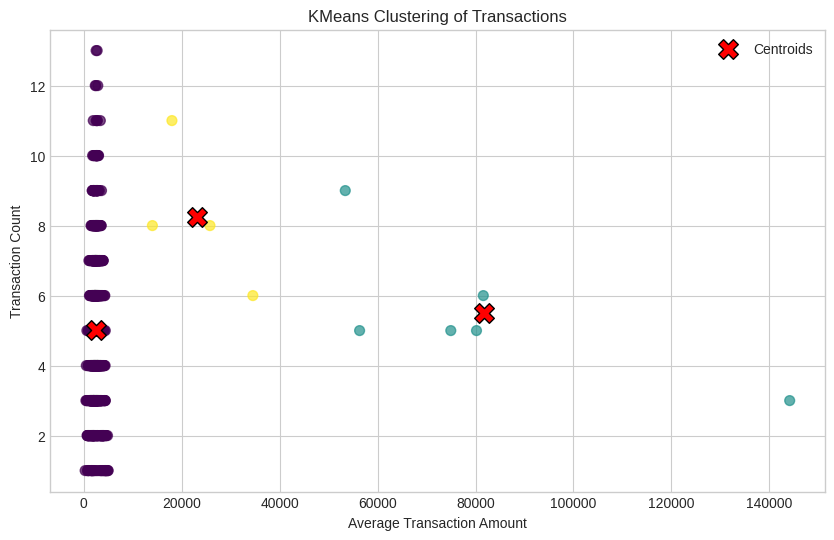

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Assuming 'customer_features' DataFrame exists with 'Avg_Transaction_Amount' and 'Transaction_Count'
X = customer_features[['Avg_Transaction_Amount', 'Transaction_Count']]

# Apply KMeans with the optimal number of clusters (example: 3)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

# Get centroids
centroids = kmeans.cluster_centers_

# Visualize clusters with 'viridis' colormap
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X['Avg_Transaction_Amount'], X['Transaction_Count'], c=y_kmeans, cmap='viridis', s=50, alpha=0.7)

# Plot the Centroids with consistent shape
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', edgecolors='black', label='Centroids')

plt.xlabel('Average Transaction Amount')
plt.ylabel('Transaction Count')
plt.title('KMeans Clustering of Transactions')
plt.legend()
plt.grid(True)
plt.show()